In [1]:
import zipfile
import tarfile

import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import csv

import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

import torch
import numpy as np


import random
from tqdm import tqdm

In [2]:
backGroundMinLayer = 8
backGroundMaxLayer = 13
layerSoundChild = 16
layerOggettiInTubo = 18

In [3]:
asd = torch.zeros((3,5))

asd[1][1:3] = 6

#asd[0:2, 1:3] = 5
#asd
#torch.flip(asd, [-2])
#asd[1:3, 3] = 4
#asd[0][1:3] = 6
asd

tensor([[0., 0., 0., 0., 0.],
        [0., 6., 6., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [4]:
asd.size()[1]

5

In [5]:
objectLayer = {}
objectShape = {}
with open('CorrispondenzeOggettiClasse.csv', mode='r') as f:
    lines = f.readlines()
    lines[0] = '0;0;0\n'
for line in lines:
    keyValue = line.split(';')
    objectLayer[int(keyValue[0])] = int(keyValue[1])
    objectShape[int(keyValue[0])] = int(keyValue[2][:-1])

In [6]:
def checkSameBytes(firstBytes, secondBytes):
    for idx, b in enumerate(secondBytes):
        if firstBytes[idx] != b:
            return False
    return True

In [7]:
def instanceAllObjects(className, bytesArray, count, size):
    instanceList = []
    startByte = 0
    constructor = globals()[className]
    for o in range(0, count):
        instance = constructor()
        instance.fromBytes(bytesArray[startByte:startByte + size])
        startByte += size
        instanceList.append(instance)
    return instanceList

In [8]:
def addZeros(bytesArray, finalSize):
    if(len(bytesArray) < finalSize):
        missingBytes = finalSize - len(bytesArray)
        zero = 0
        zeroByte = zero.to_bytes(1, 'little')
        bytesArray = bytesArray + (zeroByte * missingBytes)
    return bytesArray  

In [9]:
def fromListToBytes(objects, finalSize):
    objectsBytes =  bytearray()
    if len(objects) > 0:
        objectsBytesLists = list(map(lambda o: o.toBytes(), objects))
        objectsBytes = objectsBytesLists[0]
        for ob in objectsBytesLists[1:]:
            objectsBytes += ob
    return addZeros(objectsBytes, finalSize)    
    

In [10]:
class ObjectBytes(ABC):
    @abstractmethod
    def toBytes(self):
        pass
    @abstractmethod
    def fromBytes(self, objectBytes):
        pass

In [11]:
class GameObject(ObjectBytes):
    
    def fromBytes(self, objectBytes):
        self.xPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)
        self.xOriginalPosition = int.from_bytes(objectBytes[:4],"little", signed = False)
        self.yOriginalPosition = int.from_bytes(objectBytes[4:8],"little", signed = False)        
        self.middleTileX = True if (self.xPosition - 80) % 160 != 0 else False
        self.xPosition = (self.xPosition - 80) // 160
        self.middleTileY = True if (self.yPosition - 80) % 160 != 0 else False
        self.yPosition = (self.yPosition - 80) // 160
        self.padding = int.from_bytes(objectBytes[8:10],"little", signed = False)
        self.objectWidth = objectBytes[10]
        self.objectHeight = objectBytes[11]
        self.objectFlags = int.from_bytes(objectBytes[12:16],"little", signed = False)
        self.childObjectFlags = int.from_bytes(objectBytes[16:20],"little", signed = False)
        self.extendedData = int.from_bytes(objectBytes[20:24],"little", signed = False)
        self.objectType = int.from_bytes(objectBytes[24:26],"little", signed = False)
        self.childObjectType = int.from_bytes(objectBytes[26:28],"little", signed = False)
        self.linkID = int.from_bytes(objectBytes[28:30],"little", signed = False)
        self.soundEffect = int.from_bytes(objectBytes[30:32],"little", signed = False)
        self.layer = objectLayer[self.objectType] #MIO
        self.flagsType = int.from_bytes(objectBytes[12:16] + objectBytes[24:26],"little", signed = False) #MIO
        self.childFlagsType= int.from_bytes(objectBytes[16:20] + objectBytes[26:28],"little", signed = False) #MIO
        self.shape = objectShape[self.objectType] #MIO
        
    def fromValues(self, xPosition, yPosition, objectWidth, objectHeight, objectFlags, objectType, childObjectFlags, childObjectType, soundEffect, extendedData = 0):
        #Aggiungere gestione del middleTile
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.padding = 0
        self.objectWidth = objectWidth
        self.objectHeight = objectHeight
        self.objectFlags = objectFlags
        self.childObjectFlags = childObjectFlags
        self.objectType = objectType
        self.childObjectType = childObjectType
        self.linkID = 0 #TODO capire che fa sto coso
        self.extendedData = extendedData
        self.soundEffect = soundEffect
        
    
    def toBytes(self):
        xPositionBytes = (self.xPosition * 160) + 80
        yPositionBytes = (self.yPosition * 160) + 80
        if self.middleTileX:
            xPositionBytes +=80
        if self.middleTileY:
            yPositionBytes +=80
        xBytes = xPositionBytes.to_bytes(4, 'little')
        yBytes = yPositionBytes.to_bytes(4, 'little')
        padding = self.padding.to_bytes(2, 'little')
        width = self.objectWidth.to_bytes(1, 'little')
        height = self.objectHeight.to_bytes(1, 'little')
        flags = self.objectFlags.to_bytes(4, 'little')
        childObjectFlags = self.childObjectFlags.to_bytes(4, 'little')
        extendedData = self.extendedData.to_bytes(4, 'little')
        objectType = self.objectType.to_bytes(2, 'little')
        childObjectType = self.childObjectType.to_bytes(2, 'little')
        linkID = self.linkID.to_bytes(2, 'little')
        soundEffect = self.soundEffect.to_bytes(2, 'little')
        return xBytes + yBytes + padding + width + height + flags + childObjectFlags + extendedData + objectType + childObjectType + linkID + soundEffect
    
    def __str__(self):
        return 'Tipo:' + str(self.objectType) + '\nPosizione:(' + str(self.xPosition) + ',' + str(self.yPosition) + ')' \
            + '\nDimensioni:(' + str(self.objectWidth) + ',' + str(self.objectHeight) + ')' \
            + ('Ha figlio di tipo:' + str(self.childObjectType) if self.childObjectType != 65535 else 'non ha figlio') \
            + '\nflags: ' + str(self.objectFlags)\
            + ' posizione originale:' + str(self.xOriginalPosition) + ' ' + str(self.yOriginalPosition)

In [12]:
class FreestandingSoundEffect(ObjectBytes):
    layer = 17
    def fromBytes(self, soundBytes):
        self.effectType = soundBytes[0]
        self.xPosition = soundBytes[1]
        self.yPosition = soundBytes[2]
        self.padding = soundBytes[3]
        
    def fromValues(self,effectType, xPosition, yPosition):
        self.effectType = effectType
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.padding = 0
        
    def toBytes(self):
        effectType = self.effectType.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return effectType + xPosition + yPosition + padding

In [13]:
class SnakeNode(ObjectBytes):
    objectID = 127
    layer = 1
    def fromBytes(self, snakeNodeBytes):
        self.index = int.from_bytes(snakeNodeBytes[:2],"little", signed = False) #parte da zero
        self.direction = int.from_bytes(snakeNodeBytes[2:4],"little", signed = False)
        self.always100 = int.from_bytes(snakeNodeBytes[4:6],"little", signed = False)
        self.padding = int.from_bytes(snakeNodeBytes[6:8],"little", signed = False) 
        self.directionSnake = int.from_bytes(self.direction.to_bytes(4, 'little') + SnakeNode.objectID.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    def fromValues(index, direction):
        self.index = index
        self.direction = direction
        self.always100 = 100
        self.padding = 0 
        
    
    def toBytes(self):
        index = self.index.to_bytes(2, 'little')
        direction = self.direction.to_bytes(2, 'little')
        always100 = self.always100.to_bytes(2, 'little')
        padding = self.padding.to_bytes(2, 'little')
        return index + direction + always100 + padding

In [14]:
class SnakeBlockTrack(ObjectBytes):
    objectID = 84
    layer = 1
    def fromBytes(self, snakeBytes):
        self.linkID = snakeBytes[0] #sarà 0 1 2 3 4?
        self.nodeCount = snakeBytes[1]
        self.always1 = snakeBytes[2]
        self.padding = snakeBytes[3]
        self.snakeNodes = instanceAllObjects('SnakeNode', snakeBytes[4:], self.nodeCount, 8)
        
    def fromValues(self,linkID, snakeNodes):
        self.linkID = linkID
        self.snakeNodes = snakeNodes
        self.nodeCount = len(snakeNodes)
        self.always1 = 1
        self.padding = 0
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        snakeNodes = fromListToBytes(self.snakeNodes, 960)
        return linkID + nodeCount + always1 + padding + snakeNodes  

In [15]:
class ClearPipeNode(ObjectBytes):
    def fromBytes(self, clearPipeNodesBytes):
        self.unknownDirection = clearPipeNodesBytes[0]
        self.index = clearPipeNodesBytes[1]
        self.unKnowCoordinates = clearPipeNodesBytes[2]
        self.unKnowCoordinates2 = clearPipeNodesBytes[3]
        self.always2 = clearPipeNodesBytes[4]
        self.unknown = clearPipeNodesBytes[5] 
        self.always1 = clearPipeNodesBytes[6]
        self.unknown0123 = clearPipeNodesBytes[7]
        
    def toBytes(self):
        unknownDirection = self.unknownDirection.to_bytes(1, 'little')
        index = self.index.to_bytes(1, 'little')
        unKnowCoordinates = self.unKnowCoordinates.to_bytes(1, 'little')
        unKnowCoordinates2 = self.unKnowCoordinates2.to_bytes(1, 'little')
        always2 = self.always2.to_bytes(1, 'little')
        unknown = self.unknown.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        unknown0123 = self.unknown0123.to_bytes(1, 'little')
        return unknownDirection + index + unKnowCoordinates + unKnowCoordinates2 + always2 + unknown + always1 + unknown0123

In [16]:
class ClearPipe(ObjectBytes):
    def fromBytes(self, clearPipeBytes):
        self.linkID = clearPipeBytes[0]
        self.nodeCount = clearPipeBytes[1]
        self.always1 = clearPipeBytes[2]
        self.padding = clearPipeBytes[3]
        self.clearPipeNodes = instanceAllObjects('ClearPipeNode', clearPipeBytes[4:], self.nodeCount, 8)
        
    def toBytes(self):
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        always1 = self.always1.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        clearPipeNodes = fromListToBytes(self.clearPipeNodes, 288)
        return linkID + nodeCount + always1 + padding + clearPipeNodes  

In [17]:
class PiranhaCreeperNode(ObjectBytes):
    def fromBytes(self, piranhaCreeperNodeBytes):
        self.always1 = piranhaCreeperNodeBytes[0] 
        self.direction = piranhaCreeperNodeBytes[1]
        self.always0_1 = piranhaCreeperNodeBytes[2]
        self.always0_2 = piranhaCreeperNodeBytes[3]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        always0_1 = self.always0_1.to_bytes(1, 'little')
        always0_2 = self.always0_2.to_bytes(1, 'little')
        return always1 + direction + always0_1 + always0_2

In [18]:
class PiranhaCreeperTrack(ObjectBytes):
    def fromBytes(self, piranhaCreeperTrackBytes):
        self.always1 = piranhaCreeperTrackBytes[0] 
        self.linkID = piranhaCreeperTrackBytes[1]
        self.nodeCount = piranhaCreeperTrackBytes[2]
        self.padding = piranhaCreeperTrackBytes[3]
        self.piranhaCreeperNodes = instanceAllObjects('PiranhaCreeperNode', piranhaCreeperTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        piranhaCreeperNodes = fromListToBytes(self.piranhaCreeperNodes, 80)
        return always1 + linkID + nodeCount + padding + piranhaCreeperNodes  

In [19]:
class ExpandingBlockNode(ObjectBytes):
    def fromBytes(self, expandingBlockNodeBytes):
        self.always1 = expandingBlockNodeBytes[0] 
        self.direction = expandingBlockNodeBytes[1]
        self.padding = expandingBlockNodeBytes[2:4] 
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding  

In [20]:
class ExpandingBlockTrack(ObjectBytes):
    def fromBytes(self, expandingBlockTrackBytes):
        self.always1 = expandingBlockTrackBytes[0] 
        self.linkID = expandingBlockTrackBytes[1]
        self.nodeCount = expandingBlockTrackBytes[2]
        self.padding = expandingBlockTrackBytes[3]    
        self.expandingBlockNodes = instanceAllObjects('ExpandingBlockNode', expandingBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        expandingBlockNodes = fromListToBytes(self.expandingBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + expandingBlockNodes      

In [21]:
class TrackBlockNode(ObjectBytes):
    def fromBytes(self, trackBlockNodeBytes):
        self.always1 = trackBlockNodeBytes[0]
        self.direction = trackBlockNodeBytes[1]
        self.padding = trackBlockNodeBytes[2:4]
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        direction = self.direction.to_bytes(1, 'little')
        return always1 + direction + self.padding 

In [22]:
class TrackBlockTrack(ObjectBytes):
    def fromBytes(self, trackBlockTrackBytes):
        self.always1 = trackBlockTrackBytes[0] 
        self.linkID = trackBlockTrackBytes[1]
        self.nodeCount = trackBlockTrackBytes[2]
        self.padding = trackBlockTrackBytes[3]  
        self.trackBlockNodes = instanceAllObjects('TrackBlockNode', trackBlockTrackBytes[4:], self.nodeCount, 4)
        
    def toBytes(self):
        always1 = self.always1.to_bytes(1, 'little')
        linkID = self.linkID.to_bytes(1, 'little')
        nodeCount = self.nodeCount.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        trackBlockNodes = fromListToBytes(self.trackBlockNodes, 40)
        return always1 + linkID + nodeCount + padding + trackBlockNodes  

In [23]:
class Tile(ObjectBytes):
    def fromBytes(self, tileBytes):
        self.xPosition = tileBytes[0]
        self.yPosition = tileBytes[1]
        self.tileID = tileBytes[2] 
        self.backgroundObjectID = tileBytes[3]
        
    def fromValues(xPosition, yPosition, tileID):
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.tileID = tileID 
        self.backgroundObjectID = 0
        
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        tileID = self.tileID.to_bytes(1, 'little')
        backgroundObjectID = self.backgroundObjectID.to_bytes(1, 'little')
        return xPosition + yPosition + tileID + backgroundObjectID
    
    def __str__(self):
        return str(self.xPosition) + ' ' + str(self.yPosition) + ' ' + str(self.tileID) + ' ' + str(self.backgroundObjectID) 

In [24]:
class Rail(ObjectBytes):
    layer = 7
    typeObject = 59
    def fromBytes(self, railBytes):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
        self.railDirection = int.from_bytes(self.trackType.to_bytes(4, 'little') + Rail.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    def fromValues(hasObject, xPosition, yPosition, trackType, index, railDirection):
        self.padding = int.from_bytes(railBytes[:2],"little", signed = False) 
        self.hasObject = railBytes[2]
        self.xPosition = railBytes[3]
        self.yPosition = railBytes[4]
        self.trackType = railBytes[5]
        self.index = int.from_bytes(railBytes[6:8],"little", signed = False) 
        self.unknown2 = int.from_bytes(railBytes[8:10],"little", signed = False) 
        self.unknown3 = int.from_bytes(railBytes[10:12],"little", signed = False) 
        self.railDirection = int.from_bytes(self.trackType.to_bytes(4, 'little') + Rail.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
    
    
    def toBytes(self):
        padding = self.padding.to_bytes(2, 'little')
        hasObject = self.hasObject.to_bytes(1, 'little')
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        trackType = self.trackType.to_bytes(1, 'little')
        index = self.index.to_bytes(2, 'little')
        unknown2 = self.unknown2.to_bytes(2, 'little')
        unknown3 = self.unknown3.to_bytes(2, 'little')
        return padding + hasObject + xPosition + yPosition + trackType + index + unknown2 + unknown3

In [25]:
class Icicle(ObjectBytes):
    typeObject = 118
    def fromBytes(self, icicleBytes):
        self.xPosition = icicleBytes[0]
        self.yPosition = icicleBytes[1]
        self.typeIcicle = icicleBytes[2]
        self.padding = icicleBytes[3]
        self.typeForMatrix =  int.from_bytes(self.typeIcicle.to_bytes(4, 'little') + Icicle.typeObject.to_bytes(2, 'little'),"little", signed = False)  #lunghezza 6 come per gli oggetti normali
        
    def fromValues(xPosition, yPosition, typeIcicle):
        self.xPosition = xPosition
        self.yPosition = yPosition
        self.tileID = tileID 
        self.padding = 0
            
    def toBytes(self):
        xPosition = self.xPosition.to_bytes(1, 'little')
        yPosition = self.yPosition.to_bytes(1, 'little')
        typeIcicle = self.typeIcicle.to_bytes(1, 'little')
        padding = self.padding.to_bytes(1, 'little')
        return xPosition + yPosition + typeIcicle + padding

In [26]:
def buildRail(matrix, x,y, rails = [], loop = False):  #ABBANDONATE LE TRACK
    cellValue = matrix[Rail.layer][y][x] = 0
    arrayValues = cellValue.to_bytes(6, 'little')
    typeObject = int.from_bytes(arrayValues[5:],"little", signed = False)
    direction = int.from_bytes(arrayValues[:4],"little", signed = False)
       
    

In [27]:
def buildSnake(matrix, xPosition, yPosition, snakes, objects):
    matrix[SnakeBlockTrack.layer][yPosition][xPosition:xPosition + 5] = 0 
    soundEffect = matrix[layerSoundChild][yPosition][xPosition]
    matrix[layerSoundChild][yPosition][xPosition] = 0
    extendedData = len(snakes) + 100 #todo controllare
    snakeObject = GameObject()
    snakeObject.fromValues(xPosition, yPosition, 5, 1, 100663360, 84, 0, 65535, soundEffect, extendedData)
    objects.append(snakeObject)
    
    xNode = xPosition + 5
    yNode = yPosition
    snakeNodes = []
    index = 0
    while(True):
        nodeCell = matrix[SnakeBlockTrack.layer][yNode][xNode]
        matrix[SnakeBlockTrack.layer][yNode][xNode] = 0
        
        arrayValues = nodeCell.to_bytes(6, 'little')
        direction = int.from_bytes(arrayValues[:4],"little", signed = False)
        nodeAssertion = int.from_bytes(arrayValues[5:],"little", signed = False)
        
        assert nodeAssertion != SnakeNode.objectID
        
        node = SnakeNode()
        node.fromValues(index, direction)
        index += 1
        if direction > 12: 
            break
        
        if node.direction == 1 or node.direction == 6 or node.direction == 8:#LEFT
            xNode -= 1
            continue
        if node.direction == 2 or node.direction == 10 or node.direction == 12:#RIGHT
            xNode += 1
            continue
        if node.direction == 3 or node.direction == 5 or node.direction == 9:   #DOWN
            yNode -= 1
            continue
        if node.direction == 4 or node.direction == 7 or node.direction == 11:#UP
            yNode += 1
            continue
    
     

In [101]:
class LevelArea(ObjectBytes):
    
    #def __init__(self):
    
    def fromBytes(self, levelBytes, isMain, startY = 0, endY = 0):
        self.isMain = isMain
        if isMain:
            self.startY = startY
            self.endY = endY
        self.courseTheme = levelBytes[0]
        self.autoScrollType = levelBytes[1]
        self.screenBoundaryFlags = levelBytes[2]
        self.levelHorientation = levelBytes[3]
        self.lavaWaterHeight = levelBytes[4]
        self.lavaWaterMode = levelBytes[5]
        self.lavaWaterSpeed = levelBytes[6]
        self.minimunLavaWaterHeight = levelBytes[7]
        self.rightBoundary = int.from_bytes(levelBytes[8:12],"little", signed = False) // 16
        self.topBoundary = int.from_bytes(levelBytes[12:16],"little", signed = False) // 16
        self.leftBoundary = int.from_bytes(levelBytes[16:20],"little", signed = False) // 16
        self.bottomBoundary = int.from_bytes(levelBytes[20:24],"little", signed = False) // 16
        self.areaFlags = int.from_bytes(levelBytes[24:28],"little", signed = False)
        self.objectCount = int.from_bytes(levelBytes[28:32],"little", signed = False)
        self.freeStandingSoundEffectCount = int.from_bytes(levelBytes[32:36],"little", signed = False)
        self.snakeBlockCount = int.from_bytes(levelBytes[36:40],"little", signed = False)
        self.clearPipeCount = int.from_bytes(levelBytes[40:44],"little", signed = False)
        self.piranhaCreeperCount = int.from_bytes(levelBytes[44:48],"little", signed = False)
        self.expandingBlockCount = int.from_bytes(levelBytes[48:52],"little", signed = False)
        self.trackBlockCount = int.from_bytes(levelBytes[52:56],"little", signed = False)
        self.alwaysZero = int.from_bytes(levelBytes[56:60],"little", signed = False)
        self.tileCount = int.from_bytes(levelBytes[60:64],"little", signed = False)
        self.railCount = int.from_bytes(levelBytes[64:68],"little", signed = False)
        self.icicleCount = int.from_bytes(levelBytes[68:72],"little", signed = False)
        
        
        
        objectsBytes = levelBytes[72:83272]
        self.objects = instanceAllObjects('GameObject', objectsBytes, self.objectCount, 32)
        
        
        soundEffectsBytes = levelBytes[83272:84472]
        self.soundEffects = instanceAllObjects('FreestandingSoundEffect', soundEffectsBytes, self.freeStandingSoundEffectCount, 4)
        
        
        snakesBytes = levelBytes[84472:89292]
        self.snakes = instanceAllObjects('SnakeBlockTrack', snakesBytes, 5, 964)
        
        
        clearPipeBytes = levelBytes[89292:147692]
        self.clearPipes = instanceAllObjects('ClearPipe', clearPipeBytes, self.clearPipeCount, 292)
        
        creeperBytes = levelBytes[147692:148532]
        self.creepers = instanceAllObjects('PiranhaCreeperTrack', creeperBytes, self.piranhaCreeperCount, 84)
        
        expandingBlockBytes = levelBytes[148532:148972]
        self.expandingBlocks = instanceAllObjects('ExpandingBlockTrack', expandingBlockBytes, self.expandingBlockCount, 44)
        
        trackBlockBytes = levelBytes[148972:149412]
        self.trackBlocks = instanceAllObjects('TrackBlockTrack', trackBlockBytes, self.trackBlockCount, 44)
        
        tilesBytes = levelBytes[149412:165412]
        self.tiles = instanceAllObjects('Tile', tilesBytes, self.tileCount, 4)
        
        railBytes = levelBytes[165412:183412]
        self.rails = instanceAllObjects('Rail', railBytes, self.railCount, 12)
        
        iCicleBytes = levelBytes[183412:184612]
        self.icicles = instanceAllObjects('Icicle', iCicleBytes, self.icicleCount, 4)
    
    
    def fromMatrix(self, matrix):  
        self.objects = []
        self.soundEffects = []
        self.snakes = []
        self.clearPipes = []
        self.creepers = []
        self.expandingBlocks = []
        self.expandingBlocks = []
        self.trackBlocks = []
        self.tiles = []
        self.rails = []
        self.icicles = []
        
        tileID = 0
        for layer in range(0, matrix.size()[0]):
            for y in range(0, matrix.size()[1]):
                for x in range(0, matrix.size()[2]): 
                    cellValue = matrix[layer][y][x]
                    if cellValue == 0:
                        continue
                    if cellValue == 7:
                        matrix[layer][y][x] = 0
                        terrain = Tile()
                        terrain.fromValues(x, y, tileID)
                        tileID += 1
                        continue
                        
                    
                        
                    if layer == FreestandingSoundEffect.layer:
                        matrix[layer][y][x] = 0
                        freeSound = FreestandingSoundEffect()
                        freeSound.fromValues(cellValue, x, y)
                        self.soundEffects.append(freeSound)
                        continue
                       
                
                    arrayValues = cellValue.to_bytes(6, 'little')
                    flags = int.from_bytes(arrayValues[:4],"little", signed = False)
                    typeObject = int.from_bytes(arrayValues[5:],"little", signed = False)
                    
                    
                    if typeObject == SnakeNode.objectID:
                        continue
                    
                    if typeObject == SnakeBlockTrack.objectID:
                        buildSnake(matrix, x, y, snakes, objects)
                        continue
                    
                    if typeObject == Icicle.typeObject:
                        matrix[layer][y][x] = 0
                        matrix[layer][y + 1][x] = 0
                        iCicle = Icicle()
                        iCicle.fromValues(x,y, int.from_bytes(arrayValues[:4],"little", signed = False))
                        self.icicles.append(iCicle)
                        continue
                        
                    
                        
                    
                    
    
    def calculateLayerBackground(self, matrix, objectMM, layer = -1):
        layer = layer if layer != -1 else objectMM.layer
        if layer < backGroundMinLayer or layer > backGroundMaxLayer:
            return layer
        error = False
        if objectMM.shape == 0:
            for i in range (0,objectMM.objectWidth):
                for j in range (0,objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + j][objectMM.xPosition + i] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
        else:
            for i in range (0,objectMM.objectWidth):
                if matrix[layer][objectMM.yPosition + objectMM.objectHeight - 1][objectMM.xPosition + i] != 0:
                    return self.calculateLayerBackground(matrix, objectMM, layer + 1)
            mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
            if objectMM.objectWidth % 2 == 0:
                for i in range (1, objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + i][mediumPoint] != 0 or matrix[layer][objectMM.yPosition + i][mediumPoint + 1] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
            else:
                for i in range (1, objectMM.objectHeight):
                    if matrix[layer][objectMM.yPosition + i][mediumPoint] != 0:
                        return self.calculateLayerBackground(matrix, objectMM, layer + 1)
        return layer
    
    def toPytorchMatrix(self):
        if self.isMain:
            matrix = torch.zeros((19,27,255),dtype=torch.int64)
            matrix[0][:self.startY, :5]  = 37 #Blocchi start
            matrix[0][:self.endY, self.rightBoundary - 10 : self.rightBoundary] = 37 #blocchi end

        else:
            matrix = torch.zeros((19,255,255),dtype=torch.int64)
            
        for terrain in self.tiles:
            assert matrix[1][terrain.yPosition][terrain.xPosition]  == 0, 'occupato: ' + str(matrix[1][terrain.yPosition][terrain.xPosition]) + 'posizione: (' + str(terrain.yPosition) + \
            ', ' + str(terrain.xPosition)
            matrix[1][terrain.yPosition][terrain.xPosition] = 7
            
        for sound in self.soundEffects:
            assert matrix[17][sound.yPosition][sound.xPosition]  == 0
            matrix[17][sound.yPosition][sound.xPosition] = sound.effectType
            
        #for rail in self.rails:
            #self.setRailTrack(matrix, rail)
            
        for iCicle in self.icicles:
            assert matrix[1][iCicle.yPosition][iCicle.xPosition] == 0
            assert matrix[1][iCicle.yPosition + 1][iCicle.xPosition] == 0
            matrix[1][iCicle.yPosition:(iCicle.yPosition + 2), iCicle.xPosition] = iCicle.typeForMatrix
            
        for objectMM in self.objects:
            if objectMM.layer == -1:
                continue
            layer = self.calculateLayerBackground(matrix, objectMM)
            if objectMM.objectType == SnakeBlockTrack.objectID:#è uno snake
                self.setSnakeTrack(matrix, objectMM)
                continue
            if ((layer == 0 or layer == 1 or layer == 5 or layer == 6)and objectMM.objectFlags.to_bytes(4, 'little')[1] & 4 != 0): #se questo flag è attivo, probabilmente sta su una rail
                #print(objectMM.objectType)
                continue   
            if objectMM.shape == 0: #Forma RECT
                
                
                xPosition = objectMM.xPosition
                yPosition = objectMM.yPosition
                width = objectMM.objectWidth
                height = objectMM.objectHeight
                
                if objectMM.objectType == 11: #lifter
                    xPosition -=  (width // 2) if  width % 2 != 0 else ((width // 2) - 1)
                
                if objectMM.objectType == 31: #nuvola
                    if height == 4:
                        appoggio = width
                        width = height
                        height = appoggio  
                    if height >= 2:#nuvola, sopra ci sta gente e non è mai 2
                        height = 1
                
                if objectMM.objectFlags.to_bytes(4, 'little')[2] & 1 != 0: #nemico sopra nuvola
                    yPosition += 1
                    if objectMM.objectType == 30: #caso specifico lakitu
                        height -=1
                    
                
                if objectMM.objectType == 42 or objectMM.objectType == 17: # è una koopaclowncar o ponte
                    height = 1
                    
                if objectMM.objectType == 32 or ((objectMM.objectType == 62 or objectMM.objectType == 77 or objectMM.objectType == 12 or objectMM.objectType == 31) and width == 4): #ciccioni, bowser, boom boom, banzai bill, cloud
                    xPosition -=1
                    
               # if objectMM.objectFlags.to_bytes(4, 'little')[3] & 8 != 0: #appeso
               #     yPosition -=1
                
                versoX = 1
                versoY = 1
                
                
                if objectMM.objectFlags.to_bytes(4, 'little')[0] & 1 != 0:
                    layer = layerOggettiInTubo
                
                if objectMM.objectType == 9:
                    rotation = (((objectMM.objectFlags.to_bytes(4, 'little')[0]<< 1) >> 6) & 3) << 5
                    if rotation == 96:
                        versoX = -1
                        versoY = -1
                    if rotation == 0:
                        appoggio = width
                        width = height
                        height = appoggio
                        versoY = -1
                    if rotation == 32:
                        versoX = -1
                        appoggio = width
                        width = height
                        height = appoggio 
                for i in range (0,width):
                    for j in range (0,height):
                        self.setCellMatrix(matrix, objectMM, layer, yPosition + (j * versoY), xPosition + (i * versoX), (i == 0 and j == 0))
                continue
                
                
            if objectMM.shape == 1: #Forma T
                for i in range (0,objectMM.objectWidth):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + i, i == 0)
                mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2)
                if objectMM.objectWidth % 2 == 0:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint - 1 : mediumPoint + 1] = objectMM.flagsType
                else:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint] = objectMM.flagsType
                continue
                
            if objectMM.shape == 2: #forma gentle
                rotation = objectMM.objectFlags.to_bytes(4, 'little')[2]
                if (objectMM.objectType == 87 and (rotation == 48 or rotation == 16)): 
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + objectMM.objectWidth - 1, True)
                    for i in range(1, objectMM.objectWidth - 1, 2):#discesa
                        matrix[objectMM.layer][(objectMM.yPosition + objectMM.objectHeight - (i // 2) - 2):(objectMM.yPosition + objectMM.objectHeight - (i // 2)), objectMM.xPosition + i : objectMM.xPosition + i + 2] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition, False)
                elif (objectMM.objectType == 87 and (rotation == 0 or rotation == 32)):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition, True)
                    for i in range(1, objectMM.objectWidth - 1, 2):#salita
                        matrix[objectMM.layer][(objectMM.yPosition + (i // 2)):(objectMM.yPosition + (i // 2)) + 2, objectMM.xPosition + i : objectMM.xPosition + i + 2] = objectMM.flagsType                    
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + objectMM.objectWidth - 1, False)
                continue
            
            
            
            
            if objectMM.shape == 3: #forma steep
                rotation = objectMM.objectFlags.to_bytes(4, 'little')[2]
                if (objectMM.objectType == 88 and (rotation == 48 or rotation == 16)) or (objectMM.objectType == 94 and rotation == 32): #discesa riflesso
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + objectMM.objectWidth - 1, True)
                    for i in range(1, objectMM.objectWidth - 1): #discesa da destra
                        matrix[objectMM.layer][(objectMM.yPosition + i - 1):(objectMM.yPosition + i + 1), objectMM.xPosition + objectMM.objectWidth - i - 1] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition , False)
                elif (objectMM.objectType == 88 and (rotation == 0 or rotation == 32)) or (objectMM.objectType == 94 and rotation == 16): #salita normale
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition, True)
                    for i in range(1, objectMM.objectWidth - 1): #salita
                        matrix[objectMM.layer][(objectMM.yPosition + i - 1):(objectMM.yPosition + i + 1), objectMM.xPosition + i] = objectMM.flagsType
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition + objectMM.objectHeight - 1, objectMM.xPosition + objectMM.objectWidth - 1 , False)
                continue
                    
            if objectMM.shape == 4: #forma T contraria
                for i in range (-1,objectMM.objectWidth -1):
                    self.setCellMatrix(matrix, objectMM, layer, objectMM.yPosition, objectMM.xPosition + i, i == 0)
                mediumPoint = objectMM.xPosition + (objectMM.objectWidth // 2) - 1
                if objectMM.objectWidth % 2 == 0:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint : mediumPoint + 2] = objectMM.flagsType
                else:
                    matrix[objectMM.layer][objectMM.yPosition:(objectMM.yPosition + objectMM.objectHeight - 1), mediumPoint] = objectMM.flagsType
            
        return matrix
                
        
    def setSnakeTrack(self, matrix, objectMM):
        leftSnake = False
        extendData = objectMM.extendedData
        if extendData > 10:
            leftSnake = True
            extendData -= 16
            
        snakeBlock = self.snakes[extendData - 1]
        assert snakeBlock.nodeCount > 0
        for i in range ( -objectMM.objectWidth // 2 + 1 if objectMM.objectWidth % 2 == 0 else 0, (objectMM.objectWidth // 2) + 1):
            self.setCellMatrix(matrix, objectMM, SnakeBlockTrack.layer, objectMM.yPosition, objectMM.xPosition + i, (i == 0))
        
        xCurrentTrack = objectMM.xPosition + (objectMM.objectWidth // 2 if not leftSnake else -(objectMM.objectWidth // 2))
        if leftSnake:
            if objectMM.objectWidth % 2 == 0:
                xCurrentTrack += 1
        yCurrentTrack = objectMM.yPosition
        
        firstNode = snakeBlock.snakeNodes[0]

        if firstNode.direction == 1 or firstNode.direction == 5 or firstNode.direction == 7 or firstNode.direction == 14:#LEFT
            xCurrentTrack -= 1
        elif firstNode.direction == 2 or firstNode.direction == 9 or firstNode.direction == 11 or firstNode.direction == 13:#RIGHT
            xCurrentTrack += 1
        elif firstNode.direction == 3 or firstNode.direction == 6 or firstNode.direction == 10 or firstNode.direction == 16:   #DOWN
            yCurrentTrack -= 1
        elif firstNode.direction == 4 or firstNode.direction == 8 or firstNode.direction == 12 or firstNode.direction == 15:#UP
            yCurrentTrack += 1

        
        for node in snakeBlock.snakeNodes:
            assert matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack] == 0, 'occupato: ' + str(matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack]) + ' id:' + str(snakeBlock.linkID) + \
            '\nPosizione: ' + str(yCurrentTrack) + ' ' + str(xCurrentTrack)
            matrix[SnakeNode.layer][yCurrentTrack][xCurrentTrack] = node.directionSnake
            if node.direction == 1 or node.direction == 6 or node.direction == 8 or node.direction == 14:#LEFT
                xCurrentTrack -= 1
                continue
            if node.direction == 2 or node.direction == 10 or node.direction == 12 or node.direction == 13:#RIGHT
                xCurrentTrack += 1
                continue
            if node.direction == 3 or node.direction == 5 or node.direction == 9 or node.direction == 16:   #DOWN
                yCurrentTrack -= 1
                continue
            if node.direction == 4 or node.direction == 7 or node.direction == 11 or node.direction == 15:#UP
                yCurrentTrack += 1
                continue
    
    
    
    def setRailTrack(self, matrix, rail):
        assert matrix[Rail.layer][rail.yPosition][rail.xPosition] == 0
        matrix[Rail.layer][rail.yPosition][rail.xPosition] = rail.railDirection
    
    def setCellMatrix(self, matrix, objectMM, layer, yPosition, xPosition, childSoundCell):
        if yPosition >= 28:
            print(str(objectMM.objectType) + ' ' + str(objectMM.objectWidth) + ' ' + str(objectMM.objectHeight)\
        + ' ' + str(objectMM.middleTileX) + ' ' + str(objectMM.middleTileY) + ' ' + str(objectMM.yOriginalPosition) + ' ' + str(objectMM.xOriginalPosition) + ' ' + str(objectMM.linkID) + ' ' + str(childSoundCell)\
        + ' ' + str(yPosition) + ' ' + str(xPosition) + ' Flags: ' + str(objectMM.objectFlags))
        if matrix[layer][yPosition][xPosition] != 0 and (objectMM.objectType == 88 or objectMM.objectType == 87):
            return
        assert matrix[layer][yPosition][xPosition] == 0 or matrix[layer][yPosition][xPosition] == 7, 'occupato: ' + str(matrix[layer][yPosition][xPosition]) + ' ' + str(objectMM.objectType) + ' ' + str(objectMM.objectWidth) + ' ' + str(objectMM.objectHeight)\
        + ' ' + str(objectMM.middleTileX) + ' ' + str(objectMM.middleTileY) + ' ' + str(objectMM.yOriginalPosition) + ' ' + str(objectMM.xOriginalPosition) + ' ' + str(objectMM.linkID) + ' ' + str(childSoundCell)\
        + ' ' + str(yPosition) + ' ' + str(xPosition) + ' Flags: ' + str(objectMM.objectFlags)
        matrix[layer][yPosition][xPosition] = objectMM.flagsType
        if(childSoundCell):
            if(objectMM.childObjectType != 65535):
                assert matrix[15][yPosition][xPosition] == 0
                matrix[15][yPosition][xPosition] = objectMM.childFlagsType
            if(objectMM.soundEffect != 65535):
                #assert matrix[layerSoundChild][yPosition][xPosition] == 0, str(matrix[layerSoundChild][yPosition][xPosition]) + 'Posizione: (' + str(yPosition) + ', ' + str(xPosition) + ')\noggetto' + str(objectMM) + str(objectMM.soundEffect)
                #Se due oggetti stanno sulla stessa cella e hanno un figlio, sta cosa esplode.
                matrix[layerSoundChild][yPosition][xPosition] = objectMM.soundEffect
    
    def toBytes(self):
        courseTheme = self.courseTheme.to_bytes(1, 'little')
        autoScrollType = self.autoScrollType.to_bytes(1, 'little')
        screenBoundaryFlags = self.screenBoundaryFlags.to_bytes(1, 'little')
        levelHorientation = self.levelHorientation.to_bytes(1, 'little')
        lavaWaterHeight = self.lavaWaterHeight.to_bytes(1, 'little')
        lavaWaterMode = self.lavaWaterMode.to_bytes(1, 'little')
        lavaWaterSpeed = self.lavaWaterSpeed.to_bytes(1, 'little')
        minimunLavaWaterHeight = self.minimunLavaWaterHeight.to_bytes(1, 'little')
        
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        topBoundary = (self.topBoundary * 16).to_bytes(4, 'little')
        leftBoundary = (self.leftBoundary * 16).to_bytes(4, 'little')
        rightBoundary = (self.rightBoundary * 16).to_bytes(4, 'little')
        bottomBoundary = self.bottomBoundary.to_bytes(4, 'little')
        areaFlags = self.areaFlags.to_bytes(4, 'little')
        objectCount = self.objectCount.to_bytes(4, 'little')
        freeStandingSoundEffectCount = self.freeStandingSoundEffectCount.to_bytes(4, 'little')
        snakeBlockCount = self.snakeBlockCount.to_bytes(4, 'little')
        clearPipeCount = self.clearPipeCount.to_bytes(4, 'little')
        piranhaCreeperCount = self.piranhaCreeperCount.to_bytes(4, 'little')
        expandingBlockCount = self.expandingBlockCount.to_bytes(4, 'little')
        trackBlockCount = self.trackBlockCount.to_bytes(4, 'little')
        alwaysZero = self.alwaysZero.to_bytes(4, 'little')
        tileCount = self.tileCount.to_bytes(4, 'little')
        railCount = self.railCount.to_bytes(4, 'little')
        icicleCount = self.icicleCount.to_bytes(4, 'little')
        returnBytes = courseTheme + autoScrollType + screenBoundaryFlags + levelHorientation + lavaWaterHeight + lavaWaterMode + lavaWaterSpeed + minimunLavaWaterHeight  \
               + rightBoundary + topBoundary + leftBoundary + bottomBoundary + areaFlags + objectCount + freeStandingSoundEffectCount + snakeBlockCount + clearPipeCount \
               + piranhaCreeperCount + expandingBlockCount + trackBlockCount + alwaysZero + tileCount + railCount + icicleCount
        objectsBytes = fromListToBytes(self.objects, 83200)
        soundEffectsBytes = fromListToBytes(self.soundEffects, 1200)
        snakesBytes = fromListToBytes(self.snakes, 4820)
        clearPipeBytes = fromListToBytes(self.clearPipes, 58400)
        creeperBytes = fromListToBytes(self.creepers, 840)
        expandingBlockBytes = fromListToBytes(self.expandingBlocks, 440)
        trackBlockBytes = fromListToBytes(self.trackBlocks, 440)
        tilesBytes = fromListToBytes(self.tiles, 16000)
        railBytes = fromListToBytes(self.rails, 18000)
        iCicleBytes = fromListToBytes(self.icicles, 1200)
        return returnBytes +  objectsBytes + soundEffectsBytes + snakesBytes + clearPipeBytes + creeperBytes + expandingBlockBytes + trackBlockBytes + tilesBytes + railBytes + iCicleBytes
        

In [81]:
class Header(ObjectBytes):
    def fromBytes(self, headerBytes):
        self.startY = headerBytes[0]
        self.endY = headerBytes[1]
        self.goalXx100 = int.from_bytes(headerBytes[2:4],"little", signed = False)
        self.timeLimit = int.from_bytes(headerBytes[4:6],"little", signed = False)
        self.targetAmountClearCondition = int.from_bytes(headerBytes[6:8],"little", signed = False)
        self.year = int.from_bytes(headerBytes[8:10],"little", signed = False)
        self.month = headerBytes[10]
        self.day = headerBytes[11]
        self.hour = headerBytes[12]
        self.minute = headerBytes[13]
        self.customAutoscrollSpeed = headerBytes[14]
        self.clearConditionType = headerBytes[15]
        self.clearConditionObject = int.from_bytes(headerBytes[16:20],"little", signed = False)
        self.gameVersion = int.from_bytes(headerBytes[20:24],"little", signed = False)
        self.levelFlags = int.from_bytes(headerBytes[24:28],"little", signed = False)
        self.clearCheckTries = int.from_bytes(headerBytes[28:32],"little", signed = False)
        self.clearCheckTime = int.from_bytes(headerBytes[32:36],"little", signed = False)
        self.creationID = int.from_bytes(headerBytes[36:40],"little", signed = False)
        self.uploadID = headerBytes[40:48]
        self.gameVersionCheck = headerBytes[48:52]
        self.padding = headerBytes[52:240]
        self.unknow2 = headerBytes[240]
        self.gameStyle = headerBytes[241:244]
        self.courseName = headerBytes[244:310]#wchar16
        self.courseDescription = headerBytes[310:512]
        
    def toBytes(self):
        startY = self.startY.to_bytes(1, 'little')
        endY = self.endY.to_bytes(1, 'little')
        goalXx100 = self.goalXx100.to_bytes(2, 'little')
        timeLimit = self.timeLimit.to_bytes(2, 'little')
        targetAmountClearCondition = self.targetAmountClearCondition.to_bytes(2, 'little')
        year = self.year.to_bytes(2, 'little')
        month = self.month.to_bytes(1, 'little')
        day = self.day.to_bytes(1, 'little')
        hour = self.hour.to_bytes(1, 'little')
        minute = self.minute.to_bytes(1, 'little')   
        customAutoscrollSpeed = self.customAutoscrollSpeed.to_bytes(1, 'little') 
        clearConditionType = self.clearConditionType.to_bytes(1, 'little') 
        clearConditionObject = self.clearConditionObject.to_bytes(4, 'little') 
        gameVersion = self.gameVersion.to_bytes(4, 'little')
        levelFlags = self.levelFlags.to_bytes(4, 'little')
        clearCheckTries = self.clearCheckTries.to_bytes(4, 'little')
        clearCheckTime = self.clearCheckTime.to_bytes(4, 'little')
        creationID = self.creationID.to_bytes(4, 'little')
        unknow2 = self.unknow2.to_bytes(1, 'little')
        
        return startY + endY + goalXx100 + timeLimit + targetAmountClearCondition + year + month + day + hour + minute + customAutoscrollSpeed + clearConditionType \
               + clearConditionObject + gameVersion + levelFlags + clearCheckTries + clearCheckTime + creationID + self.uploadID \
               + self.gameVersionCheck + self.padding + unknow2 + self.gameStyle + self.courseName + self.courseDescription

In [30]:
class MarioMaker2File(ObjectBytes):
    def fromBytes(self, fileBytes):
        self.gameVersion = fileBytes[:4]
        self.gameVersion2 = fileBytes[4:6]
        self.padding = fileBytes[6:8]
        self.CRC32 = fileBytes[8:12]
        self.SCDL = fileBytes[12:16]
        self.header = Header()
        self.header.fromBytes(fileBytes[16:528])
        self.mainLevelArea = LevelArea()
        self.mainLevelArea.fromBytes(fileBytes[528:188656], True, self.header.startY, self.header.endY)
        self.subLevelArea = LevelArea()
        self.subLevelArea.fromBytes(fileBytes[188656:376784], False)
        self.cryptoCfg = fileBytes[376784:]#non ne sono sicuro
        
    def toBytes(self):
        return self.gameVersion + self.gameVersion2 + self.padding + self.CRC32 + self.SCDL + addZeros(self.header.toBytes(), 512) + addZeros(self.mainLevelArea.toBytes(), 188128) + addZeros(self.subLevelArea.toBytes(), 188128) + self.cryptoCfg

In [31]:
levelFolder = Path("levels/")
levelsDownloaded = [f for f in listdir(levelFolder) if isfile(join(levelFolder, f))]
decryptLevelFilteredFolder = Path("levels/filtered/")
levelsDecrypted = [f for f in listdir(decryptLevelFilteredFolder) if isfile(join(decryptLevelFilteredFolder, f))]

In [32]:

levelsFiltered = []

In [33]:
levelsFilteredFile = Path("levelsFiltered.txt")
if levelsFilteredFile.is_file():
    with open(levelsFilteredFile, "r") as f:
        levelsFiltered = f.read().splitlines()

In [34]:
levelsToLoad = levelsDecrypted[:] if levelsDecrypted else levelsFiltered[:] if levelsFiltered else levelsDownloaded[:]

In [82]:
marioMakerLevels = []
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File()
    level.fromBytes(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
    levelsFiltered.append(levelName)
    if not levelsDecrypted:
        with open(join(decryptLevelFilteredFolder, levelName[:-4] + '.bcd'), 'wb') as f:
            f.write(leveldata)

100%|████████████████████████████████████████████████████████████████████████████| 13972/13972 [03:30<00:00, 66.51it/s]


In [ ]:
with open("levelsFiltered.txt", "w") as outfile:
    outfile.write("\n".join(levelsFiltered))

In [ ]:
for l in marioMakerLevels:
    levelsSet.add(l.header.creationID)

In [ ]:
len(levelsSet)

In [ ]:
for lmm in marioMakerLevels:
    for o in lmm.mainLevelArea.objects:
        if  (o.yPosition == 0) and not o.middleTileY:
            print(o)
            print(o.middleTileY)
            print(o.middleTileX)
            print(lmm.header.courseName.decode("utf-16"))

In [ ]:
archive = zipfile.ZipFile(join(levelFolder, 'flying_ghosthouse__70.zip'), 'r')
leveldata = archive.read('course_data_000.bcd')
archive.close()
with open('tools/tmp/course_data_000.bcd', 'wb') as f:
    f.write(leveldata)

In [ ]:
len(leveldata)

In [ ]:
!.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd

In [ ]:
with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
    leveldata = f.read()

In [ ]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)
len(testM.toBytes())

In [ ]:
for t in testM.mainLevelArea.tiles:
    if t.backgroundObjectID != 0:
        print(t.backgroundObjectID)

In [ ]:
checkSameBytes(leveldata, testM.toBytes())

In [ ]:
testM.mainLevelArea.expandingBlockCount

In [ ]:
testM.header.gameStyle.decode("utf-8")

In [ ]:
testM.header.courseName.decode("utf-16")[:9]

In [ ]:
testM.header.courseName.decode("utf-16").find('\x00')

In [ ]:
a = testM.toBytes()
print(len(a))
for idx, b in enumerate(leveldata):
    if a[idx] != b:
        print(idx)
        break

In [ ]:
CryptoCfg

In [ ]:
courseName.decode("utf-16")

In [ ]:
courseDescription.decode("utf-16")

In [ ]:
gameStyle.decode("utf-8")

In [ ]:
'3W\x00'.rstrip('\x00')

In [ ]:
testM.header.gameStyle.decode("utf-8") == '3W\x00'

In [ ]:
for o in testM.mainLevelArea.objects:
    #print(o.objectType)
    if o.objectType == 26:
        print('ok')

In [ ]:
sampling = random.choices(levelsDownloaded, k=100)

In [45]:
levelsError = 0
for levelName in tqdm(levelsDownloaded):
    if levelName[-4:] == '.zip':
        archive = zipfile.ZipFile(join(levelFolder, levelName), 'r')
        leveldata = archive.read('course_data_000.bcd')
        archive.close()
        with open('tools/tmp/course_data_000.bcd', 'wb') as f:
            f.write(leveldata)
    else:
        archive = tarfile.open(join(levelFolder, levelName), 'r')
        archive.extract('course_data_000.bcd', path="tools/tmp/")
        archive.close()
    !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
    with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
        leveldata = f.read()
    testM = MarioMaker2File()
    
    if testM.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    a = testM.toBytes()
    for idx, b in enumerate(leveldata):
        if a[idx] != b:
            levelsError += 1
            print(testM.header.gameStyle.decode("utf-8"))
            print(testM.header.courseName.decode("utf-16"))
            print(levelName)
            print(idx)
            print('--------********')
            print(a[idx])
            print(b)
            break


  0%|                                                                                        | 0/31502 [00:00<?, ?it/s]


TypeError: MarioMaker2File() takes no arguments

In [ ]:
levelsError

In [102]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)
asd = testM.mainLevelArea.toPytorchMatrix()[1]
torch.set_printoptions(edgeitems=60)
asd

tensor([[           0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
                    0,            0,            0,            0,            0,
          ...,            0,            0,          

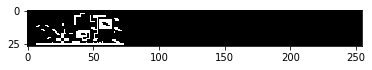

In [103]:
plt.imshow(torch.flip(asd, [-2]), cmap='gray', vmin=0, vmax=1)

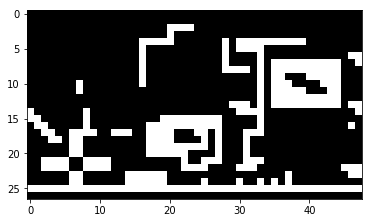

In [105]:
plt.imshow(torch.flip(asd[:,20:68], [-2]), cmap='gray', vmin=0, vmax=1)

In [183]:
for levelMM in tqdm(marioMakerLevels):
    levelMM.mainLevelArea.toPytorchMatrix()

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:00<00:00, 27.80it/s]

bene dai


AssertionError: occupato: tensor(180489289924) 62 2 2 True True 2560 20960 5 True 15 130

In [106]:
marioMakerLevels = []
levelsFiltered = []
levelsSet = set()
for levelName in tqdm(levelsToLoad[:]):
    if not levelsDecrypted:
        filePath = join(levelFolder, levelName)
        if levelName[-4:] == '.zip':
            archive = zipfile.ZipFile(filePath, 'r')
            leveldata = archive.read('course_data_000.bcd')
            archive.close()
            with open('tools/tmp/course_data_000.bcd', 'wb') as f:
                f.write(leveldata)
        else:
            archive = tarfile.open(filePath, 'r')
            archive.extract('course_data_000.bcd', path="tools/tmp/")
            archive.close()
        !.\tools\smm2dec.exe -h .\tools\tmp\course_data_000.bcd .\tools\tmp\course_data_dec.bcd >nul 2>&1
        with open('tools/tmp/course_data_dec.bcd', 'rb') as f:
            leveldata = f.read()
    else:
        filePath = join(decryptLevelFilteredFolder ,levelName)
        with open(filePath, 'rb') as f:
            leveldata = f.read()
    level = MarioMaker2File()
    level.fromBytes(leveldata)
    if level.header.gameStyle.decode("utf-8") == '3W\x00':
        continue
    if level.header.creationID in levelsSet:
        os.remove(filePath)
        continue
    levelsSet.add(level.header.creationID)
    marioMakerLevels.append(level)
#     tSet = set()
#     oSet = set()
#     for terrain in level.mainLevelArea.tiles:
#         tSet.add((terrain.xPosition, terrain.yPosition))
#         #print(str(terrain))
#         oSet.add((objectMM.xPosition, objectMM.yPosition))
        
#         if (objectMM.xPosition, objectMM.yPosition) in tSet and objectMM.layer == 1:
#             print(objectMM)
        
        
    
#     print(tSet.intersection(oSet))
    
    
    print(level.header.courseName.decode("utf-16"))
    print(levelName)
    level.mainLevelArea.toPytorchMatrix()

  0%|                                                                                        | 0/13971 [00:00<?, ?it/s]

                                 
.bcd
.                                
._12720.bcd
0-1 Strawberry Marshmallow       
0-1_strawberry_marshmallow_13844.bcd
0-2 The Wind Rises               
0-2_the_wind_rises_15637.bcd


  0%|                                                                                | 8/13971 [00:00<11:59, 19.42it/s]

000                              
000_3523.bcd
001                              
001_2447.bcd
001                              
001_4583.bcd
007 - Bond, Mario Bond ♪         
007_-_bond_mario_bond__2958.bcd
00                               
00_12889.bcd
00                               
00_4633.bcd
01castle                         

  0%|                                                                               | 11/13971 [00:00<11:03, 21.03it/s]


01castle_4415.bcd
01flyinghouse                    
01flyinghouse_4452.bcd
01Forest                         
01forest_4431.bcd


  0%|                                                                               | 16/13971 [00:00<11:04, 21.00it/s]

01ghost                          
01ghost_4139.bcd
01                               
01_12890.bcd
01                               
01_721.bcd
01 Bordel dans le desert         
01_bordel_dans_le_desert_4453.bcd
03: Kleiner Abenteuer-Dschungel  
03_kleiner_abenteuer-dschungel_878.bcd


  0%|                                                                               | 21/13971 [00:01<12:40, 18.35it/s]

05:00 AM                         
05_00_am_12100.bcd
099                              
099_13632.bcd
0_0              d               
0_0d_12647.bcd
0                                
0_2849.bcd
0 Degrees Shellsius #TS #ST      
0_degrees_shellsius_ts_st_11763.bcd


  0%|▏                                                                              | 24/13971 [00:01<11:46, 19.74it/s]

1-1.exe has encountered an error 
1-1.exe_has_encountered_an_error_737.bcd
1-1but it autoscrolls vertically 
1-1but_it_autoscrolls_vertically_10902.bcd
1-1 1-2                          
1-1_1-2_511.bcd
1-1                              
1-1_12888.bcd


  0%|▏                                                                              | 30/13971 [00:01<11:36, 20.03it/s]

1-1                              
1-1_178.bcd
1-1                              
1-1_2545.bcd
1-1                              
1-1_5129.bcd
1-1                              
1-1_6168.bcd
1-1 Appel Wood Valley            
1-1_appel_wood_valley_2963.bcd


  0%|▏                                                                              | 33/13971 [00:01<11:22, 20.42it/s]

1-1 but ...?     ist             
1-1_but_..._ist_2697.bcd
1-1 but in a nintedo switch      
1-1_but_in_a_nintedo_switch_12223.bcd
1-1 but its on and off           
1-1_but_its_on_and_off_12337.bcd
1-1 But It's Played By A Goomba  
1-1_but_it_s_played_by_a_goomba_10551.bcd


  0%|▏                                                                              | 38/13971 [00:02<15:49, 14.68it/s]

1-1, but it's shaky              
1-1_but_it_s_shaky_13985.bcd
1-1 but Mother Nature is MAD!    
1-1_but_mother_nature_is_mad__2720.bcd
1-1 but this joke is dead :(     
1-1_but_this_joke_is_dead__8179.bcd


  0%|▏                                                                              | 40/13971 [00:02<21:17, 10.91it/s]

1-1 but with an extra twist      
1-1_but_with_an_extra_twist_4023.bcd
1-1 but with a twist             
1-1_but_with_a_twist_2394.bcd
1-1 Deluxe (NES REMASTER) !!     
1-1_deluxe_nes_remaster__11875.bcd


  0%|▏                                                                              | 44/13971 [00:02<21:24, 10.85it/s]

1-1 Flipped On Its Side! 0s) nt! 
1-1_flipped_on_its_side_0s_nt__4041.bcd
1-1 Freewheelin  mb's Blues e    
1-1_freewheelinmb_s_bluese_15011.bcd
1-1 Glitch Wall  -1 Remake       
1-1_glitch_wall-1_remake_4421.bcd
1-1  goomba hills  (5 starcoins) 
1-1_goomba_hills_5_starcoins__13736.bcd
1-1 Grassy Goomba Grounds ds     

  0%|▎                                                                              | 49/13971 [00:02<16:32, 14.02it/s]


1-1_grassy_goomba_groundsds_13483.bcd
1-1を壊さないで！！　Lakitu Breaks 1-1    
1-1_lakitu_breaks_1-1_11651.bcd
1-1 Leaving Home                 
1-1_leaving_home_2863.bcd
1-1 Mario 3                      
1-1_mario_3_12722.bcd


  0%|▎                                                                              | 53/13971 [00:03<14:17, 16.23it/s]

1-1 Mario Bros.: A New Journey   
1-1_mario_bros._a_new_journey_14350.bcd
1-1: Muncher Mines               
1-1_muncher_mines_5058.bcd
1-1: Mushroom Fields Forever     
1-1_mushroom_fields_forever_14403.bcd
1-1: Mystical Mushrooms.         
1-1_mystical_mushrooms._12384.bcd


  0%|▎                                                                              | 55/13971 [00:03<14:44, 15.74it/s]

1-1 New Super Mario Bros 2       
1-1_new_super_mario_bros_2_13492.bcd
1-1 Offical Nintendo Autoscroll  
1-1_offical_nintendo_autoscroll_5340.bcd
1-1 On/Off Hill  ction           
1-1_on_off_hillction_1085.bcd
1-1 Platform Plains              
1-1_platform_plains_13414.bcd


  0%|▎                                                                              | 61/13971 [00:03<14:46, 15.69it/s]

1-1 Remastered                   
1-1_remastered_10783.bcd
1-1 Remix                        
1-1_remix_557.bcd
1-1 (SMB 3) Christmas Special    
1-1_smb_3_christmas_special_7120.bcd


  0%|▎                                                                              | 63/13971 [00:03<17:47, 13.03it/s]

1-1 SMB                          
1-1_smb_451.bcd
1-1: Spinjump Valley             
1-1_spinjump_valley_4380.bcd
1-1 Super Mario Bros. 2          
1-1_super_mario_bros._2_12781.bcd


  0%|▎                                                                              | 65/13971 [00:04<20:12, 11.47it/s]

1-1 the crazy woods e wege       
1-1_the_crazy_woodse_wege_1316.bcd
1-1 without the ground           
1-1_without_the_ground_6808.bcd
1-1 Without Touching the Ground  
1-1_without_touching_the_ground_2164.bcd
1-1?                             
1-1__1164.bcd


  1%|▍                                                                              | 70/13971 [00:04<17:47, 13.02it/s]

1-2.exe has encountered an ěřŕôŕ 
1-2.exe_has_encountered_an__876.bcd
1-2 ノコノコレジデンス -Troopa Town-      
1-2_-troopa_town-_10277.bcd
1-2                              
1-2_10813.bcd
1-2                              
1-2_1961.bcd
1-2 "3 pièces dans 3 pièces"     
1-2_3_pi_ces_dans_3_pi_ces__1393.bcd


  1%|▍                                                                              | 73/13971 [00:04<18:16, 12.67it/s]

1-2                              
1-2_5130.bcd
1-2 but without ground           
1-2_but_without_ground_8587.bcd
1-2 Deluxe (NES REMASTER) Level) 
1-2_deluxe_nes_remaster_level__9001.bcd


  1%|▍                                                                              | 78/13971 [00:05<18:38, 12.42it/s]

1-2 Easy Ocean   u               
1-2_easy_oceanu_11055.bcd
1-2 Highwater    mb's Blues e    
1-2_highwatermb_s_bluese_15010.bcd
1-2: King Boboboomboom's Cavern  
1-2_king_boboboomboom_s_cavern_5059.bcd


  1%|▍                                                                              | 80/13971 [00:05<19:16, 12.01it/s]

1-2 Love never dies #Bakedpotato 
1-2_love_never_dies_bakedpotato_14743.bcd
1-2 Mushroom Sky                 
1-2_mushroom_sky_14371.bcd
1-2: Pesky Pipelines.            
1-2_pesky_pipelines._12340.bcd


  1%|▍                                                                              | 83/13971 [00:05<30:56,  7.48it/s]

1-2 Piranha Pipe Grotto          
1-2_piranha_pipe_grotto_2950.bcd
1-2 Slippery Slope Slide [30s] ] 
1-2_slippery_slope_slide_30s__14465.bcd


  1%|▍                                                                              | 88/13971 [00:06<24:36,  9.40it/s]

1-2 SMB                          
1-2_smb_452.bcd
1-2 Taking It Back               
1-2_taking_it_back_4496.bcd
1-2 The 76 Strip   w Zealand     
1-2_the_76_stripw_zealand_15248.bcd
1-2: The Long and Winding Roots  
1-2_the_long_and_winding_roots_14415.bcd
1-3 カラフル空中庭園 -Shiny Sky Garden-  
1-3_-shiny_sky_garden-_10387.bcd
1-3                              
1-3_5131.bcd


  1%|▌                                                                              | 90/13971 [00:06<21:23, 10.82it/s]

1-3: Across the Caps             
1-3_across_the_caps_14386.bcd
1-3 Deluxe (NES REMASTER) Level) 
1-3_deluxe_nes_remaster_level__11869.bcd


  1%|▌                                                                              | 92/13971 [00:06<22:59, 10.06it/s]

1-3 Flight School                
1-3_flight_school_4497.bcd
1-3 Kirstie's Serene Swim m ! !  
1-3_kirstie_s_serene_swimm__2584.bcd
1-3: Lord Kiavik's Demise l ern  
1-3_lord_kiavik_s_demiselern_5060.bcd


  1%|▌                                                                              | 95/13971 [00:06<22:34, 10.25it/s]

1-3 Mushroom Heights  s          
1-3_mushroom_heightss_13521.bcd
1-3 mushroom tower until the sky 
1-3_mushroom_tower_until_the_sky_13797.bcd


  1%|▌                                                                              | 99/13971 [00:07<22:47, 10.14it/s]

1-3 Piranha Plains               
1-3_piranha_plains_13765.bcd
1-3 Roll on John mb's Blues e    
1-3_roll_on_johnmb_s_bluese_15009.bcd
1-3 Sky Ruins                    
1-3_sky_ruins_14326.bcd


  1%|▌                                                                             | 101/13971 [00:07<20:02, 11.53it/s]

1-3 SMB                          
1-3_smb_453.bcd
1-3 Snowshroom Summit            
1-3_snowshroom_summit_3304.bcd


  1%|▌                                                                             | 103/13971 [00:07<26:16,  8.80it/s]

1-3 Spikeball Tower              
1-3_spikeball_tower_13394.bcd
1-3: Stiletto Skys. rs           
1-3_stiletto_skys.rs_12354.bcd
1-3 Submerged Obsidian           

  1%|▌                                                                             | 105/13971 [00:07<22:56, 10.07it/s]


1-3_submerged_obsidian_13741.bcd
1-4 ブンブントンネル -Boom Boom Tunnel-  
1-4_-boom_boom_tunnel-_10318.bcd
1-4 - The Floor is Goombas ) ..! 

  1%|▌                                                                             | 107/13971 [00:08<23:20,  9.90it/s]


1-4_-_the_floor_is_goombas_..__7419.bcd
1-4                              
1-4_5132.bcd
1-4 Bodacious Boot Dash [20s]    
1-4_bodacious_boot_dash_20s__14449.bcd


  1%|▌                                                                             | 111/13971 [00:08<21:47, 10.60it/s]

1-4: Boom Boom's Seesaw Shrooms  
1-4_boom_boom_s_seesaw_shrooms_5037.bcd
1-4 Deep Breathe                 
1-4_deep_breathe_4498.bcd
1-4 Fiery Fortress               

  1%|▋                                                                             | 113/13971 [00:08<20:43, 11.14it/s]


1-4_fiery_fortress_11106.bcd
1-4: Sizzle and Swing  Climb     
1-4_sizzle_and_swing_climb_13013.bcd
1-4 Sky Platforms ms in the sky  
1-4_sky_platformsms_in_the_sky_14372.bcd
1-4: Underground Fungi Fortress. 
1-4_underground_fungi_fortress._12385.bcd


  1%|▋                                                                             | 115/13971 [00:09<29:47,  7.75it/s]

1-5: Basidiomycota Bastion.      
1-5_basidiomycota_bastion._12376.bcd


  1%|▋                                                                             | 116/13971 [00:09<35:16,  6.55it/s]

1-5 Clown Amusement Park         
1-5_clown_amusement_park_14791.bcd
1-5 Larry's Skewering Castle     
1-5_larry_s_skewering_castle_13400.bcd


  1%|▋                                                                             | 119/13971 [00:09<36:04,  6.40it/s]

1-5 Sky Castle   astle           
1-5_sky_castleastle_14325.bcd
1-6: Mushroom Meltdown           
1-6_mushroom_meltdown_12355.bcd
1-6　おどる わかめの うみのなか　Seaweed Swim  
1-6_seaweed_swim_7497.bcd


  1%|▋                                                                             | 124/13971 [00:10<26:10,  8.82it/s]

1-7 Bunte Dimensionen            
1-7_bunte_dimensionen_2982.bcd
1-7　おなかがすいた おはながさいた　Foodie Field 
1-7_foodie_field_8221.bcd
1-7 Yoshi Fun                    
1-7_yoshi_fun_4501.bcd
1-8 Bring it back 2              
1-8_bring_it_back_2_4502.bcd
1-9 Ship Has Flight              
1-9_ship_has_flight_4503.bcd
1-A: Submerged Shiitake          
1-a_submerged_shiitake_12352.bcd


  1%|▋                                                                             | 129/13971 [00:10<26:59,  8.55it/s]

1-B: Glomeromycota Airship       
1-b_glomeromycota_airship_12371.bcd
1-S: VENDETTA!   s Demise l ern  
1-s_vendetta_s_demiselern_5061.bcd
1-ups galore                     
1-ups_galore_5653.bcd
1-城　ほうだいリフト のりほうだい　Blaster Boats 
1-_blaster_boats_8307.bcd


  1%|▋                                                                             | 131/13971 [00:10<23:38,  9.76it/s]

1000 Ways to Die![Koopa Edition] 
1000_ways_to_die_koopa_edition__4176.bcd
1000人紹介企画　かまぼこ隊完成記念※説明要チェック 」    
1000__12111.bcd


  1%|▊                                                                             | 135/13971 [00:11<22:29, 10.25it/s]

100 Coin Challenge: Winter Winds 
100_coin_challenge_winterwinds_279.bcd
100 Year Flood   her             
100_year_floodher_10894.bcd
                                 
1026759769.bcd
                                 
1046974344.bcd
                                 
1048912984.bcd
10kSpecial♪Ultimate FNAF Medley♪ 
10kspecial_ultimate_fnaf_medley__11609.bcd


  1%|▊                                                                             | 142/13971 [00:11<16:58, 13.57it/s]

10k Expert Endless Special (20s) 
10k_expert_endless_special_20s__12559.bcd
10o                              
10o_2433.bcd
10sec2                           
10sec2_607.bcd
10sec challenge ～銀河氷～            
10sec_challenge__6485.bcd
10sec Fugitive remake            

  1%|▊                                                                             | 148/13971 [00:11<13:07, 17.56it/s]


10sec_fugitive_remake_194.bcd
10秒マリオ　音符抜け     　る。 クッパを倒そう！ el1 
10_el1_2315.bcd
10秒間に畳み掛けるダッシュ半自動！！　　Keep Y+→ +→ 
10_keep_y__8222.bcd
10 Seconds Cloud Run             
10_seconds_cloud_run_3055.bcd
10 Seconds: Fiery Fist of Fury   
10_seconds_fiery_fist_of_fury_10432.bcd
10 seconds Speed Run ～Z Castle～  
10_seconds_speed_run_z_castle__8404.bcd


  1%|▊                                                                             | 154/13971 [00:12<11:01, 20.88it/s]

10 Seconds: Super Star Speedrun  
10_seconds_super_star_speedrun_10422.bcd
10 Second Shell Jump Challenge   
10_second_shell_jump_challenge_15523.bcd
10 second speedrun               
10_second_speedrun_15347.bcd
10 Second Speedrun!              
10_second_speedrun__2244.bcd
10コインを出すだけの簡単なお仕事。               
10__1501.bcd
10秒！                             
10__6495.bcd


  1%|▉                                                                             | 157/13971 [00:12<12:46, 18.03it/s]

11-4                             
11-4_10731.bcd
1111                             
1111_3505.bcd
1111                             
1111_468.bcd
11                               
11_11019.bcd
11                               
11_12148.bcd
11                               
11_13626.bcd
11                               
11_7475.bcd
120秒スピードラン　攻略せよ！暗黒のスピラン魔城 ！      
120__8650.bcd


  1%|▉                                                                             | 167/13971 [00:12<10:39, 21.59it/s]

1234                             
1234_5646.bcd
1234ㄱㄷㄹㅎㅅㄱ       d               
1234_d_12654.bcd
123                              
123_12828.bcd
123                              
123_3175.bcd
123                              
123_4643.bcd
123ㄷㅈㅂㅁㄴ         d               
123_d_12664.bcd
123             ㄀ㄹㅇ              
123__12662.bcd


  1%|▉                                                                             | 173/13971 [00:13<14:02, 16.38it/s]

12aaa                            
12aaa_3843.bcd
12               nowy Slide lide 
12nowy_slidelide_12642.bcd
12                               
12_4569.bcd
12 petar                         
12_petar_6209.bcd


  1%|█                                                                             | 183/13971 [00:13<09:40, 23.77it/s]

12월이건데가         윀나가의나가           
12__12640.bcd
                                 
1339926839.bcd
13θθθポイント記念爽快コース[Refreshcourse]  
13_refreshcourse__7498.bcd
                                 
1419776409.bcd
                                 
1446024433.bcd
                                 
151792073.bcd
15 POW Challenges                
15_pow_challenges_2734.bcd
                                 
1670982820.bcd
                                 
168892518.bcd
                                 
1770627167.bcd
                                 
1841839243.bcd
                                 
1869112192.bcd
18                               
18_1226.bcd
                                 
1905429383.bcd
                                 
1968084012.bcd
1999                             
1999_10477.bcd


  1%|█                                                                             | 194/13971 [00:13<09:12, 24.95it/s]

1                d               
1d_12663.bcd
1                d               
1d_12665.bcd
1er Tour de Bowser.Jr            
1er_tour_de_bowser.jr_512.bcd
1min.MARIO                       
1min.mario_2494.bcd
1st level                        
1st_level_4399.bcd
1Suntouch Sanctuary              
1suntouch_sanctuary_1188.bcd


  1%|█                                                                             | 200/13971 [00:14<07:39, 29.98it/s]

1 - 1                            
1_-_1_13452.bcd
1                                
1_1129.bcd
1                                
1_1183.bcd
1                                
1_1229.bcd
1                                
1_12652.bcd
1                                
1_12846.bcd
1                                
1_14672.bcd


  1%|█▏                                                                            | 208/13971 [00:14<09:12, 24.90it/s]

1                                
1_1806.bcd
1                                
1_1807.bcd
1画面ステージ / 1screen stage ～ZELDA～  
1_1screen_stage_zelda__6595.bcd
1～1　～波打つコース～                     
1_1__3252.bcd
1                                
1_2060.bcd
1!22                             
1_22_10867.bcd
1                                
1_2413.bcd
1                                
1_2450.bcd
1                                
1_2814.bcd
1秒に泣く30秒スピラン                     

  2%|█▏                                                                            | 220/13971 [00:14<06:42, 34.15it/s]


1_30__158.bcd
1                                
1_3165.bcd
1                                
1_3504.bcd
1                                
1_3521.bcd
1                                
1_4439.bcd
1                                
1_4456.bcd
1                                
1_4548.bcd
1                                
1_4551.bcd
1                                
1_6643.bcd
1                                

  2%|█▎                                                                            | 226/13971 [00:14<06:09, 37.17it/s]


1_6645.bcd
1                                
1_730.bcd
1                                
1_8988.bcd
1=ªççlllswweerrfdffxccdswedfffff 
1_lllswweerrfdffxccdswedfffff_6685.bcd
1 Ounce Floaty Boi Bounce ce     
1_ounce_floaty_boi_bouncece_15457.bcd
1画面マリオPART13                     
1_part13_11317.bcd
1画面Puzzle III                    
1_puzzle_iii_13647.bcd
1画面Puzzle II                     

  2%|█▎                                                                            | 231/13971 [00:14<06:12, 36.87it/s]


1_puzzle_ii_13650.bcd
1画面Puzzle II rev. 2.0            
1_puzzle_ii_rev._2.0_13649.bcd
1画面Puzzle I                      
1_puzzle_i_13651.bcd
1画面Puzzle VI  $Don't Look Back$  
1_puzzle_vi_don_t_look_back__13646.bcd
1 ROOM PUZZLE: Gemini s it? g    
1_room_puzzle_geminis_it_g_6185.bcd
1 Screen: Fire and Ice           
1_screen_fire_and_ice_7390.bcd
1 Screen Puzzle                  
1_screen_puzzle_10996.bcd
1 screen puzzle                  

  2%|█▎                                                                            | 240/13971 [00:15<06:34, 34.81it/s]


1_screen_puzzle_1380.bcd
1 SCREEN PUZZLE: Coin Bombing    
1_screen_puzzle_coin_bombing_6184.bcd
1 SCREEN PUZZLE: MoleVenture     
1_screen_puzzle_moleventure_6201.bcd
1 Screen Puzzle: Muncher Guards  
1_screen_puzzle_muncher_guards_10655.bcd
1 Screen Puzzle: Reutilize s ds  
1_screen_puzzle_reutilizesds_11506.bcd
1 Screen Puzzle: Sky Tower Shell 
1_screen_puzzle_sky_towershell_9166.bcd
1 Screen Puzzle: Slide Over      
1_screen_puzzle_slide_over_12570.bcd
1 Screen Puzzle: SMB2 Mario      
1_screen_puzzle_smb2_mario_13396.bcd


  2%|█▍                                                                            | 249/13971 [00:15<06:15, 36.54it/s]

1 SCREEN PUZZLE: Spring Required 
1_screen_puzzle_spring_required_6181.bcd
1 SCREEN PUZZLE: Thwomp Day      
1_screen_puzzle_thwomp_day_307.bcd
1 Screen Puzzle: Triple Keys ds  
1_screen_puzzle_triple_keysds_10978.bcd
1 Screen: The Floor is Hot Lava  
1_screen_the_floor_is_hot_lava_7356.bcd
1 Screen: Water Snake            
1_screen_water_snake_7354.bcd
1 up                             
1_up_439.bcd
1発ドア                             
1__10752.bcd
1画面謎解き                           
1__11284.bcd
1画面耐久ステージ！                       
1__1524.bcd
2-1: Dzuttsun    8ngcheckkkk     
2-1_dzuttsun8ngcheckkkk_5062.bcd


  2%|█▍                                                                            | 253/13971 [00:15<09:45, 23.45it/s]

2-1 Little Drummer Boy lues e    
2-1_little_drummer_boyluese_15008.bcd
2-1: Otherworldly Overworld.     
2-1_otherworldly_overworld._12380.bcd
2-1　ノコノコの しゅうらく　Redshell Resort  
2-1_redshell_resort_8501.bcd


  2%|█▍                                                                            | 257/13971 [00:16<13:11, 17.33it/s]

2-1: The Fool on the Hill        
2-1_the_fool_on_the_hill_14416.bcd
2-1 Wiggler Forest               
2-1_wiggler_forest_14378.bcd
2-2 Cheep-Cheep Sea              
2-2_cheep-cheep_sea_14329.bcd
2-2 プクプクの オアシス/Cheep Cheep Oasis 
2-2_cheep_cheep_oasis_2091.bcd


  2%|█▍                                                                            | 260/13971 [00:16<12:54, 17.70it/s]

2-2 Donut Lift Caves             
2-2_donut_lift_caves_13510.bcd


  2%|█▍                                                                            | 263/13971 [00:16<16:17, 14.03it/s]

2-2 Frostybottom Hills           
2-2_frostybottom_hills_3005.bcd
2-2 Into the desert cave sh  20s 
2-2_into_the_desert_cavesh_20s_7853.bcd
2-2: Let It Breeze Long s        
2-2_let_it_breezelongs_14385.bcd


  2%|█▍                                                                            | 265/13971 [00:16<18:54, 12.08it/s]

2-2 Outlaw Run     w Zealand     
2-2_outlaw_runw_zealand_15246.bcd
2-2: Panic at the Platform-Tower 
2-2_panic_at_the_platform-tower_14294.bcd


  2%|█▍                                                                            | 267/13971 [00:17<23:06,  9.88it/s]

2-2 海へ山へ！そして空へ！/road to airship! 
2-2_road_to_airship__13813.bcd
2-2 Spiny Spelunking             
2-2_spiny_spelunking_13488.bcd
2-2: Tundra Turmoil.             
2-2_tundra_turmoil._12344.bcd


  2%|█▌                                                                            | 271/13971 [00:17<22:05, 10.34it/s]

2-2: Under The (Scary) Sea ones  
2-2_under_the_scary_seaones_5063.bcd
2-2 Wild West Winds              
2-2_wild_west_winds_3007.bcd
2-3 シーソー広場 -Seesaw Square-       
2-3_-seesaw_square-_11072.bcd
2-3: Fishy Fleet.  cat person"   
2-3_fishy_fleet._cat_person__12390.bcd


  2%|█▌                                                                            | 275/13971 [00:17<20:00, 11.41it/s]

2-3: Here Comes the Angry Sun    
2-3_here_comes_the_angry_sun_14418.bcd
2-3 Masters Of War 's Blues e    
2-3_masters_of_war_s_bluese_15006.bcd
2-3 Mushroom Growth drun [20s]   
2-3_mushroom_growthdrun_20s__13419.bcd
2-3 Paranormal Pipe Palace       
2-3_paranormal_pipe_palace_13408.bcd


  2%|█▌                                                                            | 279/13971 [00:18<19:25, 11.75it/s]

2-3 Poisonous Cave               
2-3_poisonous_cave_14327.bcd
2-3 Remake       rk of pain      
2-3_remakerk_of_pain_6554.bcd
2-3: Rubble ruins                
2-3_rubble_ruins_13972.bcd
2-3: Subglacial Stepping Stones  
2-3_subglacial_stepping_stones_3441.bcd


  2%|█▌                                                                            | 283/13971 [00:18<20:39, 11.04it/s]

2-3　ハナチャン だいこうしん　Wiggler Woods s 
2-3_wiggler_woodss_11367.bcd
2-4 Big Cedar      w Zealand     
2-4_big_cedarw_zealand_14451.bcd
2-4: Dig a Pokey                 
2-4_dig_a_pokey_14387.bcd
2-4 Frostybottom Hills           
2-4_frostybottom_hills_2961.bcd


  2%|█▌                                                                            | 287/13971 [00:18<18:21, 12.42it/s]

2-4: Koopahari Keep              
2-4_koopahari_keep_5041.bcd
2-4 Piranha Plant Forest         
2-4_piranha_plant_forest_14363.bcd
2-4: Piranha Pyramid Peril. run! 
2-4_piranha_pyramid_peril.run__12357.bcd


  2%|█▌                                                                            | 289/13971 [00:19<32:58,  6.91it/s]

2-4 Roy's Spiky Seesaw Castle    
2-4_roy_s_spiky_seesaw_castle_13773.bcd
2-4 Toxisches Terrain            
2-4_toxisches_terrain_2975.bcd
2-4 Trembling Tall Tower         

  2%|█▌                                                                            | 291/13971 [00:19<29:14,  7.80it/s]


2-4_trembling_tall_tower_2990.bcd
2-5 Fire in the Hole Zealand     
2-5_fire_in_the_holezealand_15357.bcd
2-5 Gumba-Gipfel                 
2-5_gumba-gipfel_2997.bcd


  2%|█▋                                                                            | 293/13971 [00:19<27:45,  8.21it/s]

2-5: Molten Moonlight            
2-5_molten_moonlight_12383.bcd


  2%|█▋                                                                            | 295/13971 [00:20<36:36,  6.23it/s]

2-5 Poisonous Castle  Castle     
2-5_poisonous_castle_castle_14362.bcd
2-6: Enter Boom Boom!            
2-6_enter_boom_boom__12368.bcd
2-A: Shiny Spiny Skies.          
2-a_shiny_spiny_skies._12349.bcd


  2%|█▋                                                                            | 297/13971 [00:20<31:34,  7.22it/s]

2-B: Gloomy Goombrats. Remix     
2-b_gloomy_goombrats.remix_12381.bcd


  2%|█▋                                                                            | 298/13971 [00:21<59:42,  3.82it/s]

2-C Morton's Speed Rise Infest   
2-c_morton_s_speed_rise_infest_15633.bcd
2-S: The White Palace            
2-s_the_white_palace_5065.bcd


  2%|█▋                                                                            | 302/13971 [00:21<41:51,  5.44it/s]

20-second speedrun but it's not. 
20-second_speedrun_but_it_s_not._13318.bcd
2001: A Space Odyssey            
2001_a_space_odyssey_5372.bcd
2012                             
2012_11242.bcd


  2%|█▋                                                                            | 305/13971 [00:21<33:39,  6.77it/s]

                                 
2063199109.bcd
20seconds : Auto-Switch House  c 
20seconds_auto-switch_house_c_2632.bcd
20seconds : Boom castle 2        
20seconds_boom_castle_2_13221.bcd


  2%|█▋                                                                            | 307/13971 [00:22<29:52,  7.62it/s]

20seconds: Earthquake Jungle Run 
20seconds_earthquake_jungle_run_3629.bcd
20seconds : Grinder Speedrun     
20seconds_grinder_speedrun_12481.bcd


  2%|█▋                                                                            | 309/13971 [00:22<32:05,  7.10it/s]

20seconds :On/Off switch house e 
20seconds_on_off_switch_housee_3685.bcd
20seconds : Pipe party！！！ ouse e 
20seconds_pipe_party_ousee_3704.bcd


  2%|█▋                                                                            | 311/13971 [00:22<38:59,  5.84it/s]

20seconds : Poison switcher      
20seconds_poison_switcher_4326.bcd
20seconds : Simple on/off cave   
20seconds_simple_on_off_cave_6279.bcd


  2%|█▊                                                                            | 314/13971 [00:23<30:36,  7.44it/s]

20Seconds Speed Run Challenge☆   
20seconds_speed_run_challenge__12013.bcd
20seconds : Spiny rain           
20seconds_spiny_rain_3974.bcd
20seconds:Thwomp Desert2/ドッスン砂漠2 
20seconds_thwomp_desert2_2_6323.bcd
20second : Grinder & Lift Panic  
20second_grinder_lift_panic_12525.bcd


  2%|█▊                                                                            | 317/13971 [00:23<26:55,  8.45it/s]

20second SPEED RUN!! #2          
20second_speed_run_2_11662.bcd
20second SPEED RUN!! #3          
20second_speed_run_3_11985.bcd


  2%|█▊                                                                            | 318/13971 [00:23<25:45,  8.84it/s]

20second speed run               
20second_speed_run_7193.bcd
20Second:　Swicth&Lift Speed Run！ 
20second_swicth_lift_speed_run__9144.bcd


  2%|█▊                                                                            | 321/13971 [00:23<26:19,  8.64it/s]

20Second:switch run 2            
20second_switch_run_2_4215.bcd
20Sec/ピーパックン スピードラン 2☆SPEED RUN★ 
20sec_2_speed_run__14424.bcd


  2%|█▊                                                                            | 323/13971 [00:24<30:03,  7.57it/s]

20sec 3DJerome3D Grove speedrun  
20sec_3djerome3d_grove_speedrun_4321.bcd
20sec BLG-X Chain Chomp speedrun 
20sec_blg-x_chain_chomp_speedrun_4294.bcd


  2%|█▊                                                                            | 325/13971 [00:24<25:43,  8.84it/s]

20sec Challenge SPPED RUN #1     
20sec_challenge_spped_run_1_12021.bcd
20sec fire barrier 8 speedrun    
20sec_fire_barrier_8_speedrun_3956.bcd


  2%|█▊                                                                            | 329/13971 [00:24<22:58,  9.90it/s]

20sec fire barrier speedrun 2    
20sec_fire_barrier_speedrun_2_3632.bcd
20sec fire barrier speedrun      
20sec_fire_barrier_speedrun_3631.bcd
20sec Jooboo Ruins speedrun un   
20sec_jooboo_ruins_speedrunun_4260.bcd
20sec Luigi John chase run  n    
20sec_luigi_john_chase_runn_4228.bcd


  2%|█▊                                                                            | 331/13971 [00:24<28:24,  8.00it/s]

20sec Moist Pipeline Panic!  20s 
20sec_moist_pipeline_panic_20s_11732.bcd
20sec Momoモモ Castle speedrun     
20sec_momo_castle_speedrun_4328.bcd


  2%|█▊                                                                            | 333/13971 [00:25<24:49,  9.16it/s]

20sec NoGeniusノ Snow speedrun    
20sec_nogenius_snow_speedrun_4229.bcd
20sec peaceful forest speedrun   
20sec_peaceful_forest_speedrun_3931.bcd


  2%|█▊                                                                            | 335/13971 [00:25<28:25,  7.99it/s]

20sec ♪Pluto Snow speedrun       
20sec_pluto_snow_speedrun_4311.bcd
20sec snow run 寒い土地は走るに限るのスピードラン 
20sec_snow_run__2960.bcd
20sec speedrun for the fastest   
20sec_speedrun_for_the_fastest_3681.bcd
20Sec/暗闇のトゲこんぼうスピードラン/Speed run  
20sec_speed_run_14171.bcd


  2%|█▉                                                                            | 339/13971 [00:25<25:00,  9.08it/s]

20sec speed run:新感覚!踏むスピードラン     
20sec_speed_run__11945.bcd
20sec SR|Cindy Temple speedrun   
20sec_sr_cindy_temple_speedrun_4256.bcd
20sec Wolf Castle platform run   
20sec_wolf_castle_platform_run_4254.bcd


  2%|█▉                                                                            | 343/13971 [00:26<20:19, 11.18it/s]

20sec スピードラン    　ン　              
20sec__191.bcd
20s POW castle exhilarating ver. 
20s_pow_castle_exhilarating_ver._4359.bcd
20s:Sky On/Off Speedrun          
20s_sky_on_off_speedrun_11206.bcd


  2%|█▉                                                                            | 345/13971 [00:26<22:24, 10.14it/s]

20s speedrun: Lava hopping 3     
20s_speedrun_lava_hopping_3_10444.bcd
20s speedrun　どくどく洞窟\Poison cave  
20s_speedrun_poison_cave_11474.bcd
20秒スピードラン / 毒沼で爽快にEnjoy！！        
20_enjoy__12012.bcd


  2%|█▉                                                                            | 349/13971 [00:26<28:10,  8.06it/s]

20 Secondes: Easy mode           
20_secondes_easy_mode_12205.bcd
20 Seconds: Abominable Snowmen   
20_seconds_abominable_snowmen_7362.bcd
20 Seconds: Aerial Armada        
20_seconds_aerial_armada_7352.bcd
20 seconds: Arctic Tundra Dash   
20_seconds_arctic_tundra_dash_12944.bcd


  3%|█▉                                                                            | 351/13971 [00:27<30:02,  7.56it/s]

20 seconds: Auto Switch Heaven   
20_seconds_auto_switch_heaven_3045.bcd


  3%|█▉                                                                            | 353/13971 [00:27<41:10,  5.51it/s]

20 seconds: Beatles cave!        
20_seconds_beatles_cave__2675.bcd
20 Seconds: Belly of the Beast   
20_seconds_belly_of_the_beast_8921.bcd


  3%|█▉                                                                            | 355/13971 [00:28<36:12,  6.27it/s]

20 Seconds: Blackout Blitz ades  
20_seconds_blackout_blitzades_2628.bcd
20 Seconds: Bob-omb Blastoff     
20_seconds_bob-omb_blastoff_739.bcd


  3%|█▉                                                                            | 358/13971 [00:28<29:35,  7.67it/s]

20 seconds: Bob-omb Bonanza  n   
20_seconds_bob-omb_bonanzan_6305.bcd
20 seconds: Bowser on/off castle 
20_seconds_bowser_on_off_castle_3646.bcd
20 Seconds: Buzzy Beetle Blaze   
20_seconds_buzzy_beetle_blaze_381.bcd
20 seconds: Buzzy Castle         
20_seconds_buzzy_castle_3647.bcd


  3%|██                                                                            | 362/13971 [00:28<28:44,  7.89it/s]

20 Seconds: Cannonball Capers    
20_seconds_cannonball_capers_2611.bcd
20 Seconds: Cannonball Panic     
20_seconds_cannonball_panic_4220.bcd
20 Seconds: Cannonball Panic!    
20_seconds_cannonball_panic__4295.bcd


  3%|██                                                                            | 364/13971 [00:29<34:34,  6.56it/s]

20 Seconds: Cannon Catastrophe   
20_seconds_cannon_catastrophe_11938.bcd
20 seconds: Celestial Koopa Jump 
20_seconds_celestial_koopa_jump_3392.bcd


  3%|██                                                                            | 365/13971 [00:29<38:26,  5.90it/s]

20 Seconds challenge 1-4         
20_seconds_challenge_1-4_2222.bcd
20 seconds: Colorful Sky Rush h  
20_seconds_colorful_sky_rushh_12956.bcd


  3%|██                                                                            | 367/13971 [00:29<36:09,  6.27it/s]

20 Seconds: Countdown Crumble    
20_seconds_countdown_crumble_1407.bcd
20 Seconds: Daunting Desert Dash 
20_seconds_daunting_desert_dash_778.bcd


  3%|██                                                                            | 369/13971 [00:30<33:59,  6.67it/s]

20 seconds: Deadly Desert        
20_seconds_deadly_desert_2681.bcd


  3%|██                                                                            | 370/13971 [00:30<46:47,  4.84it/s]

20 seconds: Desert Stiletto Rush 
20_seconds_desert_stiletto_rush_3729.bcd
20 Seconds: Disturbance Dogs     
20_seconds_disturbance_dogs_3697.bcd


  3%|██                                                                            | 372/13971 [00:30<42:41,  5.31it/s]

20 Seconds: Electric Disco       
20_seconds_electric_disco_12004.bcd


  3%|██                                                                            | 374/13971 [00:31<44:23,  5.10it/s]

20 seconds: Elysian Cannon Blast 
20_seconds_elysian_cannon_blast_3668.bcd
20 Seconds: Ethereal POW Garden  
20_seconds_ethereal_pow_garden_1631.bcd


  3%|██                                                                            | 375/13971 [00:31<39:02,  5.80it/s]

20 Seconds: Fearsome Fire Fort   
20_seconds_fearsome_fire_fort_1911.bcd


  3%|██                                                                            | 378/13971 [00:31<38:10,  5.94it/s]

20 seconds: Fire Run             
20_seconds_fire_run_2223.bcd
20 Seconds: Flooded Forest       
20_seconds_flooded_forest_7350.bcd
20 Seconds : Freezy Galaxy       
20_seconds_freezy_galaxy_3684.bcd


  3%|██▏                                                                           | 381/13971 [00:32<36:07,  6.27it/s]

20 seconds: Get Down             
20_seconds_get_down_2685.bcd
20 Seconds: Ghost of a Chance    
20_seconds_ghost_of_a_chance_7402.bcd
20 seconds: Goomba's Armada      
20_seconds_goomba_s_armada_3710.bcd


  3%|██▏                                                                           | 385/13971 [00:32<25:01,  9.05it/s]

20 Seconds Great Flow Speedrun   
20_seconds_great_flow_speedrun_2274.bcd
20 Seconds: Highspeed Hill Climb 
20_seconds_highspeed_hill_climb_3345.bcd
20 Seconds: High In The Clouds   
20_seconds_high_in_the_clouds_4304.bcd
20 seconds: King Thwomp's Castle 
20_seconds_king_thwomp_s_castle_10886.bcd
20 seconds: Link's Frosty Dash   
20_seconds_link_s_frosty_dash_7190.bcd


  3%|██▏                                                                           | 388/13971 [00:32<30:29,  7.43it/s]

20 seconds: ♪♪Little Star♪♪      
20_seconds_little_star__3604.bcd
20 Seconds: Majestic Clouds      
20_seconds_majestic_clouds_13426.bcd


  3%|██▏                                                                           | 390/13971 [00:33<32:33,  6.95it/s]

20 Seconds: Mega Mario Smashdown 
20_seconds_mega_mario_smashdown_787.bcd
20 seconds: Muncher Cave!        
20_seconds_muncher_cave__3371.bcd


  3%|██▏                                                                           | 392/13971 [00:33<28:39,  7.90it/s]

20 seconds: My brother Thwomp!   
20_seconds_my_brother_thwomp__2717.bcd
20 seconds: Pipeline Lift Sprint 
20_seconds_pipeline_lift_sprint_8564.bcd


  3%|██▏                                                                           | 394/13971 [00:33<29:30,  7.67it/s]

20 seconds: Piranha Cave         
20_seconds_piranha_cave_2238.bcd
20 Seconds: Platform Panic       
20_seconds_platform_panic_3394.bcd


  3%|██▏                                                                           | 396/13971 [00:33<26:46,  8.45it/s]

20 Seconds: Platform Pushthrough 
20_seconds_platform_pushthrough_733.bcd
20 Seconds: POWer Mansion!       
20_seconds_power_mansion__3627.bcd


  3%|██▏                                                                           | 397/13971 [00:34<31:46,  7.12it/s]

20 Seconds: POW Block Blitz Y+→  
20_seconds_pow_block_blitzy__347.bcd
20 seconds: POW Block Mansion    
20_seconds_pow_block_mansion_3300.bcd


  3%|██▏                                                                           | 399/13971 [00:34<30:17,  7.47it/s]

20 seconds: POW Block Mountain   
20_seconds_pow_block_mountain_2239.bcd


  3%|██▏                                                                           | 400/13971 [00:34<37:58,  5.96it/s]

20 Seconds: Pow Throw Overflow   
20_seconds_pow_throw_overflow_3374.bcd


  3%|██▏                                                                           | 402/13971 [00:34<40:56,  5.52it/s]

20 Seconds: Rainbow Run - Kotaku 
20_seconds_rainbow_run_-_kotaku_7372.bcd
20 seconds: Sawblade-Castle      
20_seconds_sawblade-castle_12929.bcd


  3%|██▏                                                                           | 403/13971 [00:35<46:18,  4.88it/s]

20 seconds: ☆Sharp Sky☆          
20_seconds_sharp_sky__11098.bcd
20 seconds: Sky Auto switch Run  
20_seconds_sky_auto_switch_run_3951.bcd


  3%|██▎                                                                           | 405/13971 [00:35<41:32,  5.44it/s]

20 Seconds: Slide To Victory     
20_seconds_slide_to_victory_1691.bcd
20 seconds: Snowy Death          
20_seconds_snowy_death_2221.bcd


  3%|██▎                                                                           | 408/13971 [00:35<33:50,  6.68it/s]

20 Seconds : Snow Boll SpeedRun！ 
20_seconds_snow_boll_speedrun__10440.bcd
20 seconds: Snow Storm!          
20_seconds_snow_storm__3612.bcd


  3%|██▎                                                                           | 409/13971 [00:35<33:39,  6.72it/s]

20 Seconds: Speed of Sound       
20_seconds_speed_of_sound_3366.bcd


  3%|██▎                                                                           | 411/13971 [00:36<37:35,  6.01it/s]

20 seconds: Spiky Spiny Forest   
20_seconds_spiky_spiny_forest_2748.bcd
20 seconds: Spinning Thwomps     
20_seconds_spinning_thwomps_2683.bcd


  3%|██▎                                                                           | 412/13971 [00:36<48:18,  4.68it/s]

20 Seconds: Super Flimsy Parkour 
20_seconds_super_flimsy_parkour_12571.bcd
20 Seconds: Super MATRIX Bros    
20_seconds_super_matrix_bros_4266.bcd
20 Seconds: Super Star Sprint    
20_seconds_super_star_sprint_3972.bcd


  3%|██▎                                                                           | 416/13971 [00:37<39:25,  5.73it/s]

20 Seconds: Swift Switcheroo     
20_seconds_swift_switcheroo_3638.bcd
20 Seconds: Switch Block Blast n 
20_seconds_switch_block_blastn_325.bcd


  3%|██▎                                                                           | 418/13971 [00:37<33:51,  6.67it/s]

20 Seconds:switch run 0秒スピードラン   
20_seconds_switch_run0__3944.bcd
20 Seconds: Switch Sky Station h 
20_seconds_switch_sky_stationh_783.bcd


  3%|██▎                                                                           | 420/13971 [00:37<32:16,  7.00it/s]

20 Seconds: Tee Hee Two          
20_seconds_tee_hee_two_2980.bcd
20 seconds: Thwomp Castle Run!   
20_seconds_thwomp_castle_run__3634.bcd


  3%|██▎                                                                           | 423/13971 [00:37<29:28,  7.66it/s]

20 Seconds: Thwomp Temple Run  h 
20_seconds_thwomp_temple_runh_1390.bcd
20 seconds: Toxic Sewers Run!    
20_seconds_toxic_sewers_run__3636.bcd
20 Seconds: !!To Hot For You!!   
20_seconds_to_hot_for_you__3672.bcd
20 second: House of Switches     
20_second_house_of_switches_2228.bcd


  3%|██▍                                                                           | 426/13971 [00:38<30:30,  7.40it/s]

20 Second Icicle Speedrun        
20_second_icicle_speedrun_3448.bcd
20 second mayhem part I          
20_second_mayhem_part_i_8383.bcd


  3%|██▍                                                                           | 430/13971 [00:38<24:53,  9.07it/s]

20 Second Puzzle Room (Icy Cave) 
20_second_puzzle_room_icy_cave__2708.bcd
20 second run! (moderate)        
20_second_run_moderate__932.bcd
20 Second Shell Jump Challenge   
20_second_shell_jump_challenge_15522.bcd
20 Second Speed  d               
20_second_speedd_726.bcd
20 second speed run estar　Music  
20_second_speed_runestar_music_4967.bcd


  3%|██▍                                                                           | 434/13971 [00:38<20:45, 10.87it/s]

20 Second Switch Run             
20_second_switch_run_4002.bcd
20 Second Switch Speedrun        
20_second_switch_speedrun_4343.bcd
20 Second Variety Speedrun!      
20_second_variety_speedrun__2243.bcd
20 SECS: An Icy, ON and OFF Run  

  3%|██▍                                                                           | 438/13971 [00:39<16:49, 13.40it/s]


20_secs_an_icy_on_and_off_run_2282.bcd
20 secs of Tunnel Vision?  l?    
20_secs_of_tunnel_vision_l__8986.bcd
20 secs: Red Koopa = Hold Jump   
20_secs_red_koopa_hold_jump_7150.bcd
20 sec: Delightful Cannon Blast  
20_sec_delightful_cannon_blast_7625.bcd
20 Sec Mario Dash - Boo's House  
20_sec_mario_dash_-_boo_s_house_3059.bcd


  3%|██▍                                                                           | 440/13971 [00:39<26:52,  8.39it/s]

20 Sec Mario Dash - Moon Rockets 
20_sec_mario_dash_-_moon_rockets_3346.bcd
20 Sec on/off Desert Run         
20_sec_on_off_desert_run_1669.bcd
20 Sec : ON/OFF & Lift SpeedRun！ 
20_sec_on_off_lift_speedrun__11199.bcd


  3%|██▍                                                                           | 445/13971 [00:40<24:36,  9.16it/s]

20 sec run POW- & On/Off-Block   
20_sec_run_pow-_on_off-block_13618.bcd
20 Sec: Speed Run Kill Chomp     
20_sec_speed_run_kill_chomp_4521.bcd
20秒スピードラン！SPEEDRUN 20sec         

  3%|██▍                                                                           | 447/13971 [00:40<23:10,  9.72it/s]


20_speedrun_20sec_4986.bcd
20秒マリオ          　の               
20__6551.bcd
                                 
211975947.bcd
                                 
2159168434.bcd


  3%|██▌                                                                           | 463/13971 [00:40<12:54, 17.44it/s]

                                 
2177569259.bcd
                                 
2220054183.bcd
2222wwweeeeeeeeeeeeeeeeee        
2222wwweeeeeeeeeeeeeeeeee_12136.bcd
222                              
222_2066.bcd
222                              
222_3163.bcd
222              yo              
222_yo_6684.bcd
                                 
225596230.bcd
                                 
2256920871.bcd
                                 
2257841957.bcd
                                 
2258427207.bcd
                                 
2282694719.bcd
                                 
2283608302.bcd
                                 
2307086209.bcd
2323                             
2323_12644.bcd
                                 

  3%|██▌                                                                           | 470/13971 [00:40<10:03, 22.36it/s]


2447036274.bcd
                                 
2495851129.bcd
                                 
2498568271.bcd
24 Yeet Street (Candle Sets) )   
24_yeet_street_candle_sets__1566.bcd
                                 
2555860737.bcd
                                 
2590432691.bcd
                                 
2632905899.bcd
                                 
264992946.bcd
                                 
2754396542.bcd
                                 
278197583.bcd
28-4                             
28-4_10846.bcd


  3%|██▋                                                                           | 476/13971 [00:40<08:23, 26.80it/s]

                                 
2829675772.bcd
                                 
2858866363.bcd
28 Days Later                    
28_days_later_5366.bcd
                                 
2917051394.bcd
                                 
2927977811.bcd
                                 
2962917915.bcd
2Osec Adrian117 Bullet Bill run  
2osec_adrian117_bullet_bill_run_4290.bcd
2P coop / High danger at castle  

  3%|██▋                                                                           | 482/13971 [00:41<11:44, 19.15it/s]


2p_coop_high_danger_at_castle_10264.bcd
2p coop|Love won't tear us apart 
2p_coop_love_won_t_tear_us_apart_9236.bcd
2SMB3♪Sky Theme♪KEEP RUNNING >+Y 
2smb3_sky_theme_keep_running_y_8984.bcd


  4%|██▋                                                                           | 490/13971 [00:41<12:37, 17.80it/s]

2                                
2_1153.bcd
2                                
2_1455.bcd
2                                
2_3166.bcd
2=4                              
2_4_13209.bcd
2                                
2_5643.bcd
2                                
2_660.bcd
2 Fast 2 Furious                 
2_fast_2_furious_112.bcd
2エリアダッシュ半自動マリオ Keep run(→+Y)     
2_keep_run_y__2097.bcd
2エリア左ダッシュ半自動マリオ Keep run(←+Y)    
2_keep_run_y__3538.bcd


  4%|██▊                                                                           | 493/13971 [00:42<15:22, 14.62it/s]

2 Lies 1 Truth                   
2_lies_1_truth_1210.bcd
2 Screen Puzzle  er Endeavor v2  
2_screen_puzzleer_endeavor_v2_10887.bcd
2 THWOMP 2 FURIOUS               
2_thwomp_2_furious_3099.bcd


  4%|██▊                                                                           | 498/13971 [00:42<16:36, 13.52it/s]

2人の英雄　 TWO HEROES ES             
2_two_heroeses_5659.bcd
2 Ways to Win                    
2_ways_to_win_458.bcd
2さいきよう                           
2__12156.bcd
3-1: Blue Bay Way                
3-1_blue_bay_way_14410.bcd
3-1 Cave Lifts                   
3-1_cave_lifts_14323.bcd


  4%|██▊                                                                           | 503/13971 [00:42<16:25, 13.66it/s]

3-1 Flockiger Federflug Schloss  
3-1_flockiger_federflugschloss_3004.bcd
3-1: Happy Little Sky Castles    
3-1_happy_little_sky_castles_3382.bcd
3-1 Slow Train Coming AndTell    
3-1_slow_train_comingandtell_15005.bcd
3-1 The Dark lark                

  4%|██▊                                                                           | 505/13971 [00:43<15:36, 14.38it/s]


3-1_the_dark_lark_749.bcd
3-1 Welcome to Lawrence  and     
3-1_welcome_to_lawrenceand_15352.bcd
3-2 Carnivorous Cave             
3-2_carnivorous_cave_14340.bcd


  4%|██▊                                                                           | 510/13971 [00:43<17:53, 12.54it/s]

3-2 Free State    Palace and     
3-2_free_state_palaceand_15236.bcd
3-2: Honey Pond   Gentle Cheeps  
3-2_honey_pond_gentle_cheeps_14383.bcd
3-2 Katakomben der Käfer chloss  
3-2_katakomben_der_k_ferchloss_2901.bcd
3-2 Starlight Cavern             
3-2_starlight_cavern_13729.bcd


  4%|██▊                                                                           | 512/13971 [00:43<24:34,  9.13it/s]

3-2: Taken By Vultures           
3-2_taken_by_vultures_3730.bcd
3-2 White Dove   mb's Blues e    
3-2_white_dovemb_s_bluese_15004.bcd
3-31                             
3-31_11569.bcd


  4%|██▉                                                                           | 517/13971 [00:44<18:08, 12.36it/s]

3-3 Celestial Clouds             
3-3_celestial_clouds_3284.bcd
3-3 まっくらトゲトゲすいろ/Darkness Trench  
3-3_darkness_trench_3592.bcd
3-3 Odds and Ends b's Blues e    
3-3_odds_and_endsb_s_bluese_15003.bcd
3-3: Scroll Lock Sun Block       
3-3_scroll_lock_sun_block_3756.bcd
3-3 The Docking Station          
3-3_the_docking_station_12116.bcd


  4%|██▉                                                                           | 521/13971 [00:44<19:08, 11.71it/s]

3-3 Underground Ghost House      
3-3_underground_ghost_house_14375.bcd
3-3: You're Gonna Lose That Star 
3-3_you_re_gonna_lose_that_star_14394.bcd
3-3　鉄球海道                         
3-3__8310.bcd


  4%|██▉                                                                           | 523/13971 [00:44<19:26, 11.52it/s]

3-4 オーキードーキー号 -Over the Ocean-   
3-4_-over_the_ocean-_11976.bcd
3-4 Big Blooper Sea Sea          
3-4_big_blooper_seasea_13685.bcd
3-4 Cave Warp Zone               
3-4_cave_warp_zone_13960.bcd


  4%|██▉                                                                           | 528/13971 [00:44<15:43, 14.25it/s]

3-4: The Shallow Submarine       
3-4_the_shallow_submarine_5045.bcd
3-4: Wendy's Waterlogged Wonder  
3-4_wendy_s_waterlogged_wonder_13472.bcd
3-5 Underwater Castle            
3-5_underwater_castle_14345.bcd
3-6              lgmh.hk,h,      
3-6lgmh.hk_h__12258.bcd


  4%|██▉                                                                           | 530/13971 [00:45<20:41, 10.83it/s]

3-S: Petey's Pipeline Passage    
3-s_petey_s_pipeline_passage_5069.bcd
3...2...1... Blast Off!!! #DGR   
3...2...1..._blast_off_dgr_6823.bcd


  4%|██▉                                                                           | 532/13971 [00:45<22:24,  9.99it/s]

3... 2.. 1... Chase!             
3..._2.._1..._chase__3703.bcd
                                 
3081605063.bcd
                                 
3091309453.bcd
30seconds ON/OFF switch RUN.     
30seconds_on_off_switch_run._1556.bcd
30seconds speedrun easy          
30seconds_speedrun_easy_124.bcd
30sec:Snowball and Lift Speedrun 
30sec_snowball_and_lift_speedrun_11922.bcd


  4%|███                                                                           | 540/13971 [00:45<16:01, 13.96it/s]

30s Speed Glide #RYUSMM          
30s_speed_glide_ryusmm_13346.bcd
30秒スピードラン:雪原　30sec               
30_30sec_7928.bcd
30 Minutes or Less Easy Version) 
30_minutes_or_lesseasy_version__12298.bcd
30 Seconds Collapsing Ice Cave 2 
30_seconds_collapsing_ice_cave_2_4267.bcd


  4%|███                                                                           | 542/13971 [00:46<20:55, 10.69it/s]

30 Seconds: Collapsing Ice Cave! 
30_seconds_collapsing_ice_cave__4233.bcd
30 Seconds (Normal)              
30_seconds_normal__1877.bcd


  4%|███                                                                           | 544/13971 [00:46<28:03,  7.98it/s]

30 Seconds: Platform Panic 2     
30_seconds_platform_panic_2_3666.bcd
30 Seconds: Platform Panic       
30_seconds_platform_panic_3711.bcd


  4%|███                                                                           | 546/13971 [00:46<27:31,  8.13it/s]

30 Seconds: Run With The Shell   
30_seconds_run_with_the_shell_3875.bcd
30秒スピードランだにょ～ん！！                 
30__7349.bcd
                                 
3207326817.bcd
                                 

  4%|███▏                                                                          | 560/13971 [00:46<15:12, 14.69it/s]


3254873506.bcd
                                 
3342475126.bcd
                                 
3388192462.bcd
                                 
3397052829.bcd
33                               
33_1156.bcd
                                 
3446821192.bcd
                                 
3525973811.bcd
                                 
357916012.bcd
                                 
3622731693.bcd
                                 
3646751399.bcd
                                 
3815595138.bcd
                                 
3819145478.bcd
                                 
3820782242.bcd
                                 
3829652849.bcd
                                 
3830731390.bcd
                                 

  4%|███▏                                                                          | 565/13971 [00:47<13:40, 16.34it/s]


3956666638.bcd
3G → 4G → 5G [POW] Run Run Run!! 
3g_4g_5g_pow_run_run_run__3063.bcd
3x20 Speedrun     them all       
3x20_speedrun_them_all_13735.bcd
3                                
3_2795.bcd


  4%|███▏                                                                          | 569/13971 [00:47<15:03, 14.84it/s]

3 2 1... blast off! ap           
3_2_1..._blast_off_ap_13525.bcd
3                                
3_3167.bcd
3択クイズ/3ChoiceQuiz m ngle         
3_3choicequizmngle_1300.bcd
3段ジャンプスピラン / 3 Jump Speed Run.   
3_3_jump_speed_run._8662.bcd


  4%|███▏                                                                          | 572/13971 [00:47<14:12, 15.73it/s]

3 keys            g              
3_keysg_6942.bcd
3 player versus                  
3_player_versus_10759.bcd
3 skin sky speed run!!!　【20sec】  
3_skin_sky_speed_run_20sec__4960.bcd
3日後…１マス針抜けの意外な突破方法を伝授しマッスルマッスル～w 
3_w_10714.bcd


  4%|███▏                                                                          | 579/13971 [00:47<11:35, 19.26it/s]

3段ジャンプが苦手な人コース                   
3__12130.bcd
3段ジャンプ→カベキック→ヒップドロップ             
3__1510.bcd
4-1　巨大の国に迷い込んだマリオ　/　BIG ISLAND   
4-1_big_island_11429.bcd
4-1 Bone-Dry Valley              
4-1_bone-dry_valley_3009.bcd
4-1 Canned Heat   Square         
4-1_canned_heat_square_14874.bcd
4-1 Mossy Mountains              
4-1_mossy_mountains_3225.bcd
4-1 Pokey Desert                 
4-1_pokey_desert_14346.bcd


  4%|███▏                                                                          | 582/13971 [00:48<15:04, 14.80it/s]

4-1: Polythene Peak              
4-1_polythene_peak_14391.bcd
4-1: Skullcrusher Cove           
4-1_skullcrusher_cove_5070.bcd
4-2: ... In Another Castle       
4-2_..._in_another_castle_5071.bcd


  4%|███▎                                                                          | 589/13971 [00:48<14:06, 15.81it/s]

4-2 Bone-Dry Valley              
4-2_bone-dry_valley_2966.bcd
4-2 Desert Tomb                  
4-2_desert_tomb_14356.bcd
4-2 Mystic Mushrooms             
4-2_mystic_mushrooms_3549.bcd
4-2: Rubber Soil                 
4-2_rubber_soil_14398.bcd
4-2 Woodland Lake  el            
4-2_woodland_lakeel_13774.bcd
4-2　ふたつの国を行ったり来たり                
4-2__11104.bcd
4-3 Bone-Dry Valley              
4-3_bone-dry_valley_2972.bcd


  4%|███▎                                                                          | 594/13971 [00:49<17:07, 13.02it/s]

4-3: Buflen's Mad Lads           
4-3_buflen_s_mad_lads_5072.bcd
4-3 Oasis City                   
4-3_oasis_city_14334.bcd
4-3: Rock-'n-Rolling Buzzies     
4-3_rock-_n-rolling_buzzies_14399.bcd
4-4 Bone-Dry Valley              
4-4_bone-dry_valley_2979.bcd


  4%|███▎                                                                          | 596/13971 [00:49<21:27, 10.39it/s]

4-4 haunted castle               
4-4_haunted_castle_1308.bcd
4-4: Iggy's Mystery Mansion      

  4%|███▎                                                                          | 598/13971 [00:49<23:42,  9.40it/s]


4-4_iggy_s_mystery_mansion_14407.bcd
4-4 Koopa Graveyard              
4-4_koopa_graveyard_14349.bcd
4-4　パックン一族の生家/Piranha Plant Home 
4-4_piranha_plant_home_12547.bcd


  4%|███▎                                                                          | 600/13971 [00:50<24:55,  8.94it/s]

4-5 Desert Castle  Castle        
4-5_desert_castle_castle_14342.bcd
                                 
4027683562.bcd
                                 
4057997827.bcd
                                 
4079403332.bcd
40sec Pokemon Speed Run ポケモスピドラン 
40sec_pokemon_speed_run__3741.bcd


  4%|███▍                                                                          | 605/13971 [00:50<20:34, 10.83it/s]

40sec 　崩れる城を駆け抜けろ！               
40sec__6506.bcd


  4%|███▍                                                                          | 607/13971 [00:50<26:40,  8.35it/s]

40S  ジャングルの中を駆け抜けよう SPEED RUN    
40s_speed_run_4273.bcd
40 seconds: Frogger lava rush!   
40_seconds_frogger_lava_rush__13672.bcd
40 Seconds: Thwomp run           
40_seconds_thwomp_run_11981.bcd


  4%|███▍                                                                          | 611/13971 [00:50<22:17,  9.99it/s]

40 Second: Poisonmushroom run    
40_second_poisonmushroom_run_13068.bcd
40 Second Speed Run              
40_second_speed_run_725.bcd
40秒スピードラン　雪玉をポイっとな！！             
40__9213.bcd


  4%|███▍                                                                          | 618/13971 [00:51<19:14, 11.57it/s]

                                 
4104383830.bcd
                                 
4133161973.bcd
                                 
4156805599.bcd
                                 
4159029297.bcd
                                 
4236142070.bcd
444                              
444_3170.bcd
4 - 2 Crystal Cliffs             
4_-_2_crystal_cliffs_5105.bcd


  4%|███▍                                                                          | 621/13971 [00:51<20:26, 10.89it/s]

4                                
4_3168.bcd
4 Challenges [Medium]            
4_challenges_medium__943.bcd
4 little puzzles cters password  
4_little_puzzlescters_password_4440.bcd
4 Player Battle                  
4_player_battle_2105.bcd
4 Player Mayhem!! Slippery Race  
4_player_mayhem_slippery_race_1760.bcd


  4%|███▍                                                                          | 626/13971 [00:51<15:43, 14.15it/s]

4 Player Versus #1 - Skyclimb    
4_player_versus_1_-_skyclimb_3227.bcd
4種の武器でボムシューティング　WEAPON SHOOTING  
4_weapon_shooting_3552.bcd
4人レースwith急降下/4Race with NoseDive 
4_with_4race_with_nosedive_2075.bcd
4 you                            
4_you_12680.bcd
4人で対決！最後まで逆転可能な爽快レース！！           

  5%|███▌                                                                          | 629/13971 [00:52<15:55, 13.96it/s]


4__1950.bcd
5-1: 1-Screen Winter Wonders     
5-1_1-screen_winter_wonders_4014.bcd


  5%|███▌                                                                          | 631/13971 [00:52<19:57, 11.14it/s]

5-1 キラーキラー マウンテン/Bullets Heights 
5-1_bullets_heights_9024.bcd
5-1 Diving Down Deep             
5-1_diving_down_deep_13511.bcd
5-1 Snowy Plains                 
5-1_snowy_plains_14343.bcd


  5%|███▌                                                                          | 634/13971 [00:52<16:28, 13.49it/s]

5-1: Sour Milk Sky               
5-1_sour_milk_sky_14390.bcd
5-1: The Friendly Skies          
5-1_the_friendly_skies_6536.bcd
5-2 Cloudy Top Heights           
5-2_cloudy_top_heights_2971.bcd


  5%|███▌                                                                          | 636/13971 [00:52<22:49,  9.73it/s]

5-2 Shocking Spinies             
5-2_shocking_spinies_13516.bcd
5-2 Snowball Mountain            
5-2_snowball_mountain_14344.bcd


  5%|███▌                                                                          | 640/13971 [00:53<25:20,  8.77it/s]

5-2: The Legend of DekuScrub     
5-2_the_legend_of_dekuscrub_4305.bcd
5-2: Winds Of Love louds         
5-2_winds_of_lovelouds_14402.bcd
5-3 Cold Mushroom Sky bridge     
5-3_cold_mushroom_skybridge_14354.bcd
5-3: Lord Gold's Throneroom      

  5%|███▌                                                                          | 643/13971 [00:53<20:13, 10.99it/s]


5-3_lord_gold_s_throneroom_5268.bcd
5-3: Ticket To Ride Beetles      
5-3_ticket_to_ride_beetles_14395.bcd
5-4 Cloudy Top Heights           
5-4_cloudy_top_heights_2621.bcd
5-4 Icy Caverns                  

  5%|███▌                                                                          | 648/13971 [00:53<16:07, 13.77it/s]


5-4_icy_caverns_14357.bcd
5-4: Paperback Freighter         
5-4_paperback_freighter_5053.bcd
5-4　青い空が大好きです　/　Roy's Airship    
5-4_roy_s_airship_13865.bcd
5-5 Castle of Fire and Ice       
5-5_castle_of_fire_and_ice_14347.bcd
5-S: Petey joins #TeamPrecision  
5-s_petey_joins_teamprecision_5267.bcd
50秒スピードラン / 炎のON/OFFスイッチランナー ー   
50_on_off__11183.bcd


  5%|███▋                                                                          | 650/13971 [00:54<22:03, 10.07it/s]

50 Seconds of Hard Platforming 3 
50_seconds_of_hard_platforming_3_11476.bcd
50 Second:  run 【hard】 hard】     
50_second_run_hard_hard__11458.bcd


  5%|███▋                                                                          | 652/13971 [00:54<23:38,  9.39it/s]

50秒スピードラン　電光石火の如く走り抜け！！ があるんだ    
50__10697.bcd


  5%|███▋                                                                          | 654/13971 [00:54<28:50,  7.70it/s]

50命不够用                           
50__11014.bcd
50秒スピラン！                         
50__12122.bcd
50秒スピードラン はしれはしれ！にげろにげろ！         
50__6510.bcd


  5%|███▋                                                                          | 660/13971 [00:55<30:10,  7.35it/s]

536体のテレサを回避する神回避全自動　　AUTO        
536_auto_9000.bcd
5555                             
5555_1108.bcd
555                              
555_3171.bcd
跳ね馬！じゃじゃ馬！スーパーボール！               
5dc42437000a9b2200cead2a.bcd
Super Mario Sunshine's Sand Bird 
5dc424370010b27700cead25.bcd


  5%|███▋                                                                          | 662/13971 [00:55<26:30,  8.37it/s]

UNDERGROUND WORLD　ー地下世界のアスレチックー  
5dc42437001ddc6700cead2e.bcd
Multiplayer Versus!! / みんなでバトル！！ 
5dc42437002708dd00cead26.bcd
ぽいずんふれんず                         
5dc42437002b78cf00cead24.bcd
A Pipedream in Switchland        
5dc42437004e922000cead23.bcd
Super Metroid X Super Mario      

  5%|███▋                                                                          | 668/13971 [00:55<18:29, 11.99it/s]


5dc42437006e37f800cead2f.bcd
Balls to the Walls               
5dc424370074a85b00cead2d.bcd
Uno Mas: Big Mario's Secret      
5dc4243700d7e0df00cead2b.bcd
Back to Gameboy   ake block      

  5%|███▋                                                                          | 670/13971 [00:56<18:00, 12.31it/s]


5dc4243700f2846a00cead2c.bcd
Breakout          Jeep           
5dc42438000093f000cead33.bcd
Friends are Rotten!              
5dc424380006dcf000cead3e.bcd


  5%|███▊                                                                          | 672/13971 [00:56<18:37, 11.90it/s]

AutoMAGIC                        
5dc42438000d567b00cead3c.bcd
Teamwork Castle                  
5dc424380015d96200cead42.bcd


  5%|███▊                                                                          | 677/13971 [00:56<15:47, 14.03it/s]

table tennis                     
5dc4243800186ebb00cead44.bcd
Tick Tock Clock [SM64]           
5dc42438002015b100cead32.bcd
Brother, Can You Spare A Coin?   
5dc4243800357a2900cead31.bcd
Superballin'                     
5dc424380043463d00cead46.bcd
Puzzle Rooms 2                   
5dc42438004e781e00cead3b.bcd
The Mirror Puzzles; first part.  

  5%|███▊                                                                          | 679/13971 [00:56<17:04, 12.97it/s]


5dc42438004fc51d00cead3d.bcd
The Mirror Puzzles; part 2.      
5dc42438005e4e7a00cead40.bcd


  5%|███▊                                                                          | 683/13971 [00:56<16:03, 13.79it/s]

Table Tennis in SMM2!            
5dc424380072979e00cead36.bcd
スイッチ仕掛けのお化け屋敷                    
5dc42438008abd8700cead47.bcd
信じてDASH JUMP!                    
5dc42438009014da00cead41.bcd
♪Country Roads♪ →Walk→           
5dc4243800a8bd4e00cead3a.bcd
スーパーマリオボール　Super Mario Ball      

  5%|███▊                                                                          | 685/13971 [00:57<15:21, 14.42it/s]


5dc4243800adb7f200cead38.bcd
Stormy Mushroom Jungle           
5dc4243800b45a0500cead48.bcd
★ The 4 Player Showdown ★        

  5%|███▊                                                                          | 687/13971 [00:57<16:58, 13.05it/s]


5dc4243800ca818b00cead39.bcd
♪シオカラ節　Calamari Inkantation♪　1/2 
5dc4243800d600fc00cead34.bcd
New Game, New Ideas - Puzzle     
5dc4243800d86a4d00cead43.bcd


  5%|███▊                                                                          | 693/13971 [00:57<15:26, 14.34it/s]

marios shooting range            
5dc4243800f1922600cead3f.bcd
Escape Room                      
5dc4243800ff62b300cead35.bcd
Pong                             
5dc424390015ba3400cead56.bcd
謎解き脱出ゲーム的な                       
5dc424390024464700cead49.bcd
スーパーボールつかい                       
5dc4243900261d2400cead5c.bcd


  5%|███▉                                                                          | 695/13971 [00:57<18:04, 12.24it/s]

♪シオカラ節　Calamari Inkantation♪　2/2 
5dc42439003d087500cead4f.bcd
Table Tennis                     
5dc424390052491800cead51.bcd


  5%|███▉                                                                          | 697/13971 [00:58<17:54, 12.36it/s]

謎解きループコース　Mystery Loop Level     
5dc4243900579eb700cead5b.bcd
♪Running in the 90's♪ Hold Y+Run 
5dc42439005bbc7500cead58.bcd
Wet and Dry                      
5dc424390061454100cead4b.bcd


  5%|███▉                                                                          | 701/13971 [00:58<19:24, 11.40it/s]

Puzzle Rooms 4                   
5dc424390068892500cead50.bcd
Icicle run                       
5dc4243900761ef900cead4e.bcd
SMB3 Tennis                      
5dc42439008e9a3b00cead54.bcd
PAC-MAN in SMM2  er              
5dc424390090aea000cead57.bcd
Minijuegos Mario land            

  5%|███▉                                                                          | 706/13971 [00:58<14:32, 15.21it/s]


5dc4243900959f3e00cead4a.bcd
てらして すすんで まっくらいせき                
5dc42439009842d800cead4c.bcd
Desert Pong                      
5dc424390099adb800cead4d.bcd
雪の世界で、カロンコウラをシュート！               
5dc4243900ae92ac00cead53.bcd
Super Smash Bros. Ultimate BGM   
5dc4243900b0385a00cead5a.bcd


  5%|███▉                                                                          | 710/13971 [00:58<15:48, 13.97it/s]

Slide64!                         
5dc4243900c8f50400cead59.bcd
Boom Boom's Evil Pinball Machine 
5dc4243900d9628b00cead55.bcd
[Party Game]  Piranha Pinball    
5dc4243900e9dabf00cead52.bcd
MARIO LAND EX 難易度★★☆☆☆           
5dc4243a0047dcb400cead5d.bcd
Bowser's Inside Story aid        
5dc4243a005d79f900cead5e.bcd


  5%|███▉                                                                          | 713/13971 [00:59<18:07, 12.19it/s]

Spring Has Switched              
5dc4258b000ca3e700cead64.bcd
Sensational Switches             
5dc4258b000d6ba600cead62.bcd


  5%|████                                                                          | 717/13971 [00:59<24:07,  9.16it/s]

カズ遊園地 ～Kazu Amusement Park～      
5dc4258b0055d21e00cead65.bcd
Table Tennis in SMM2! [HARD]     
5dc4258b006741f500cead5f.bcd
The 8 Ancient Cave Coins s       
5dc4258b006bc21d00cead66.bcd


  5%|████                                                                          | 719/13971 [01:00<25:04,  8.81it/s]

Call Of Koop'thulhu              
5dc4258b0098cd7700cead60.bcd
The Simple Machine               
5dc4258b00c3a86b00cead63.bcd
Chain Chonk Temple               
5dc4258b00c4a44100cead61.bcd


  5%|████                                                                          | 721/13971 [01:00<27:01,  8.17it/s]

The Deserted Thwomp Ruins tation 
5dc4258b00cfa2b500cead67.bcd
Parallel Universe                
5dc4258c00007d1a00cead78.bcd


  5%|████                                                                          | 725/13971 [01:00<24:06,  9.16it/s]

The mirrors cave  espejos        
5dc4258c0000e30700cead6d.bcd
AC 1-2 King Dedede's Rhythm Game 
5dc4258c0006178300cead76.bcd
Cloudtop Climb                   
5dc4258c00203b8500cead6b.bcd
Frozen-Over Fantasy              
5dc4258c0022df7300cead69.bcd


  5%|████                                                                          | 728/13971 [01:01<30:05,  7.33it/s]

砂の遺跡にひそむ罠                        
5dc4258c0032cf4000cead7c.bcd
Dungeon Escape                   
5dc4258c0035861f00cead70.bcd


  5%|████                                                                          | 731/13971 [01:01<42:27,  5.20it/s]

Basically A Level                
5dc4258c004217d900cead7e.bcd
追いかけられて(Follow the coins)        
5dc4258c00591ef200cead72.bcd
*~Snowy Swinging And Climbing~*  

  5%|████                                                                          | 733/13971 [01:02<33:03,  6.67it/s]


5dc4258c0062dcf200cead7a.bcd
Flash of Insight tion            
5dc4258c0064094900cead7f.bcd
Abandoned Site                   
5dc4258c006f07b000cead77.bcd


  5%|████                                                                          | 735/13971 [01:02<29:56,  7.37it/s]

Forest Goop      ngle            
5dc4258c0078a2f700cead71.bcd
Tanooki in the Sky World ken     
5dc4258c00949f8e00cead79.bcd
Booting Up the Switch! (Easy) z) 
5dc4258c009513be00cead7d.bcd


  5%|████                                                                          | 737/13971 [01:02<28:04,  7.86it/s]

白熱！トゲメットレース【イージーver】             
5dc4258c00b2ae4300cead74.bcd
Delfino Island    Kyol Ren       
5dc4258c00b493ba00cead7b.bcd


  5%|████▏                                                                         | 739/13971 [01:02<27:27,  8.03it/s]

BOTW - Concept                   
5dc4258c00cd698900cead82.bcd
Tilted Thrill                    
5dc4258c00d1634700cead80.bcd


  5%|████▏                                                                         | 741/13971 [01:03<29:49,  7.39it/s]

Flying Battery Zone              
5dc4258c00def3a700cead75.bcd


  5%|████▏                                                                         | 744/13971 [01:03<35:19,  6.24it/s]

Frostbite Falls Open             
5dc4258c00eee26c00cead73.bcd
Chocolate-Mountain-Expedition!   
5dc4258c00f0235900cead6a.bcd
Icedom Tower                     

  5%|████▏                                                                         | 745/13971 [01:03<31:56,  6.90it/s]


5dc4258d000e367b00cead91.bcd
Metroid World: A love story      
5dc4258d001a610600cead84.bcd


  5%|████▏                                                                         | 747/13971 [01:03<29:19,  7.51it/s]

Fetch-Quest Village as           
5dc4258d001d2c2800cead96.bcd
Waibak 1-1: Backtrack Plains     
5dc4258d001d752300cead99.bcd
かけあがれ！　朽ちた天空の塔                   
5dc4258d002180f900cead8b.bcd


  5%|████▏                                                                         | 752/13971 [01:04<20:18, 10.85it/s]

Through the Bomber               
5dc4258d0024ea8300cead8e.bcd
Shlooter!                        
5dc4258d0025f99400cead8f.bcd
S-Claw in Snowfield～雪国のブランコクレーン～ 
5dc4258d0039f6f200cead8c.bcd
Crimson Dream                    
5dc4258d003f22e000cead90.bcd


  5%|████▏                                                                         | 754/13971 [01:04<21:26, 10.27it/s]

Carnivorous Caverns              
5dc4258d0047184300cead83.bcd
おそらのゴキゲンはシーソーしだい　/  Gramble sky  
5dc4258d004a5dc900cead93.bcd
Deep Wood        nigans          

  5%|████▏                                                                         | 756/13971 [01:04<22:28,  9.80it/s]


5dc4258d004a7e3b00cead9a.bcd
Climate: Change! lds ns Factory  
5dc4258d00554a8200cead85.bcd


  5%|████▏                                                                         | 758/13971 [01:04<21:27, 10.26it/s]

A Swing and a Prayer             
5dc4258d006fd9b700cead97.bcd
Thwomp Ruins     ace             
5dc4258d00a8b0ff00cead8a.bcd


  5%|████▏                                                                         | 760/13971 [01:05<26:13,  8.40it/s]

Icy Cavern                       
5dc4258d00bb2e1b00cead92.bcd
[Normal] Going down, please ります  
5dc4258d00bb3a2200cead8d.bcd


  5%|████▎                                                                         | 762/13971 [01:05<33:36,  6.55it/s]

The Sinking Citadel Returns      
5dc4258d00c4e36c00cead86.bcd
Metroid zero mission             
5dc4258d00ccea1000cead87.bcd


  5%|████▎                                                                         | 764/13971 [01:05<31:17,  7.03it/s]

Rainbow's Delight                
5dc4258d00d1a43600cead95.bcd
Master the POW                   
5dc4258d00e2cb5900cead94.bcd


  5%|████▎                                                                         | 767/13971 [01:05<24:54,  8.83it/s]

Koopa Madness                    
5dc4258d00f56ced00cead88.bcd
Nightmare Castle - LPMarkus 01   
5dc4258d00ff41d600cead98.bcd
Canyon Climb                     
5dc425c60043623f00ceada2.bcd
Celestial Sprint Speedrun [20s]  
5dc425c6007154a100ceada1.bcd


  6%|████▎                                                                         | 771/13971 [01:06<24:11,  9.09it/s]

Pipe Dreams                      
5dc425c6009de4d400cead9d.bcd
Switch x  Switch / スイッチのとりで      
5dc425c600c2333700cead9e.bcd
【Galoomba(クリボン)】Speedrun #3[20s] 
5dc425c600ee043700ceada0.bcd
Minature 1                       
5dc425c600ee351200cead9b.bcd
【One Screen Puzzle】あらわれし 横ドッスン   
5dc425c70002aec300ceadbd.bcd
Donut Drop Dungeon Deluxe        
5dc425c700038f0700ceada3.bcd


  6%|████▎                                                                         | 775/13971 [01:06<22:07,  9.94it/s]

Thwomp Terror - Run!             
5dc425c700064aeb00ceadb8.bcd
Spectacular Switch Sprint (30s)  
5dc425c7000ac23500ceadb4.bcd


  6%|████▎                                                                         | 779/13971 [01:07<21:41, 10.14it/s]

Chomp Thwomp Ruins               
5dc425c700114cb000ceadc1.bcd
ON/OFFスイッチマスター                   
5dc425c7001e95b600ceadbf.bcd
Space Mission!    problem        
5dc425c70038dfd400ceadaa.bcd
Chin Onescreen-Puzzle 1          

  6%|████▎                                                                         | 782/13971 [01:07<17:46, 12.37it/s]


5dc425c7004eac2100ceadc0.bcd
ON/OFFブロックでGO!                   
5dc425c700514bd500ceadbc.bcd
Switching Speed (Hard)           
5dc425c700540de000ceadac.bcd
Simple Switches                  
5dc425c7005ec99100ceadaf.bcd


  6%|████▍                                                                         | 787/13971 [01:07<16:11, 13.57it/s]

Fast Switch Thinking!            
5dc425c70067c88a00ceadab.bcd
初見殺しって最低                         
5dc425c70070136500ceada5.bcd
On/Off Speedrun - Sklar (Hard)   
5dc425c7007745e200ceadb3.bcd


  6%|████▍                                                                         | 789/13971 [01:07<16:22, 13.41it/s]

Side Thwomp Sprint Romp          
5dc425c70078ed3400ceadb6.bcd
Ryan's First Level               
5dc425c7007dbdd000ceada7.bcd
Twisty Thwomp Romp               
5dc425c7007df3fd00ceadae.bcd


  6%|████▍                                                                         | 791/13971 [01:07<15:25, 14.24it/s]

Mario Throws Up                  
5dc425c7009ce7a700ceadb5.bcd
【One Screen Puzzle】お助けブラックパックン   
5dc425c7009d86eb00ceadb2.bcd
Beware the Forest's Poison       
5dc425c700a0067c00ceadbb.bcd
ブロックパズル/Block Puzzle 詰め合わせ +α    
5dc425c700a0879d00ceadb0.bcd


  6%|████▍                                                                         | 794/13971 [01:08<14:41, 14.96it/s]

The Only Three Jump Ruins        
5dc425c700b2b9ec00ceadb7.bcd
【Galoomba(クリボン)】Speedrun #1[20s] 
5dc425c700b66d7500ceadba.bcd


  6%|████▍                                                                         | 796/13971 [01:08<17:35, 12.48it/s]

Zelda OoT: Deku Tree  Deku Tree  
5dc425c700bc70fe00ceada4.bcd


  6%|████▍                                                                         | 798/13971 [01:08<27:28,  7.99it/s]

Planta Island                    
5dc425c700c44fd300ceadbe.bcd
The Lost Factory ll              
5dc425c700c889ff00ceada9.bcd
[SMM1]Defeat the Elite Eight/八鍵将 
5dc425c700d48d2c00ceadc2.bcd


  6%|████▍                                                                         | 800/13971 [01:08<22:57,  9.56it/s]

<= SELF-DESTRUCT: ACTIVATED =>   
5dc425c700d656f500ceada8.bcd
Swaying Swamp Launchers          

  6%|████▍                                                                         | 802/13971 [01:09<33:25,  6.56it/s]


5dc425c80006a0d600ceadce.bcd
Switch-breeze Canyon             
5dc425c800249bf800ceadc5.bcd


  6%|████▍                                                                         | 804/13971 [01:09<31:14,  7.02it/s]

Day One Fun                      
5dc425c80081a17900ceadcf.bcd
The Eight Coins  er?             
5dc425c800820f3e00ceadcd.bcd


  6%|████▍                                                                         | 805/13971 [01:09<35:10,  6.24it/s]

Escape from the forest Thwomps   
5dc425c80084280c00ceadc6.bcd
よこからドッスンごっつん                     
5dc425c8008f239b00ceadca.bcd
Toadettes Winter Adventure       
5dc425c800af200f00ceadcb.bcd


  6%|████▌                                                                         | 810/13971 [01:10<27:17,  8.04it/s]

Eye in the Sky   oreshore Forest 
5dc425c800c0078800ceadc7.bcd
【Bob-omb(ボムへい)】Speedrun #1[20s]  
5dc425c800cfab6000ceadc8.bcd
Level 1-1 rotated by 90° 90°     
5dc425c800dbaa8300ceadc9.bcd
SPEEDY'S ICEY FUN RUN!           

  6%|████▌                                                                         | 812/13971 [01:10<24:06,  9.10it/s]


5dc425c800e3775c00ceadd0.bcd
Binacle          ue              
5dc425c90050943400ceadd6.bcd
ドアに入ってジャンプだ2 Jump from the door2 

  6%|████▌                                                                         | 814/13971 [01:10<21:04, 10.40it/s]


5dc425c900563ade00ceadd2.bcd
Wigglers Mechanized Tree Fort    
5dc425c90078a8c000ceadd1.bcd


  6%|████▌                                                                         | 816/13971 [01:10<24:22,  9.00it/s]

走れ！ちょい難50秒SUPEEDRUN! N! N! UN!   
5dc425c90080a2c300ceadd4.bcd
Twisting Tunnel                  
5dc425c9009ac7c500ceadd5.bcd


  6%|████▌                                                                         | 818/13971 [01:11<23:16,  9.42it/s]

The Infernal Machine             
5dc425c900e004b800ceadd3.bcd
babby's first troll              
5dc425e40003801000ceade9.bcd
Poison Surfing                   
5dc425e4000b0fcc00ceade0.bcd
Monochromatic Acrobatic and Bird 
5dc425e4002313a100ceade4.bcd


  6%|████▌                                                                         | 823/13971 [01:11<20:14, 10.83it/s]

Desert Crossing                  
5dc425e400650c6300ceadeb.bcd
Switch Block Skyway              
5dc425e40065ca3c00ceade8.bcd
Floaty Platform Adventure        
5dc425e4006d030700ceadd7.bcd


  6%|████▌                                                                         | 825/13971 [01:11<20:30, 10.68it/s]

Snowy Windy Land                 
5dc425e4007d7eb200ceade2.bcd
Slippery Stalactite              
5dc425e400df583500ceadda.bcd


  6%|████▌                                                                         | 827/13971 [01:12<28:45,  7.62it/s]

Go fast [40]      Don't time out 
5dc425e400e0085400ceadd9.bcd
Claustrophobia                   
5dc425e400f5459000ceade7.bcd
Indi Rio 2 - Desert Quest 1.0    
5dc425e50001556e00ceadf1.bcd


  6%|████▋                                                                         | 831/13971 [01:12<25:45,  8.50it/s]

Celeste - prologue & 1st chapter 
5dc425e5000537b300ceae01.bcd
Welcome to AMM Community!        
5dc425e5001ce89a00ceae04.bcd
Lost Forest Seclusion            
5dc425e500239d3400ceadfa.bcd
5 hard(ish) keycoins             
5dc425e5002ec72f00ceadf2.bcd


  6%|████▋                                                                         | 836/13971 [01:12<18:55, 11.56it/s]

Reverse Climbing k               
5dc425e5002f759b00ceadf3.bcd
The arrows don't lie             
5dc425e5003d9fd400ceadfc.bcd
Escort the Payload: Desert Storm 
5dc425e500485ccc00ceadef.bcd
Galoomba Grabbing                
5dc425e50052fecd00ceae05.bcd


  6%|████▋                                                                         | 840/13971 [01:12<15:47, 13.85it/s]

Run for it!                      
5dc425e5005826a600ceadec.bcd
レベル2 普通くらい                       
5dc425e50058840b00ceadf0.bcd
Rainbow Cloud Run  20 Sec]       
5dc425e5005d363400ceadf4.bcd
Collapsing Cavern                
5dc425e5005f72cd00ceadf6.bcd


  6%|████▋                                                                         | 842/13971 [01:13<14:48, 14.78it/s]

Thwomp Racing    ng Adventure    
5dc425e500629fa200ceadf7.bcd
Actual Climbing  k               
5dc425e50066358d00ceadee.bcd
The Forgotten Skies              
5dc425e5006eac8e00ceae00.bcd
Finals IV: Invitational 2019     
5dc425e50073c87600ceadf5.bcd


  6%|████▋                                                                         | 847/13971 [01:13<15:07, 14.46it/s]

Heavenly Feeling                 
5dc425e50084e5d800ceaded.bcd
Perilous Poisonous Speedrun 40s  
5dc425e5008bdcf600ceadff.bcd
the switcheroo                   
5dc425e5008e52cd00ceae09.bcd
Crane Acrobatics                 
5dc425e500910d7d00ceae02.bcd


  6%|████▋                                                                         | 850/13971 [01:13<14:00, 15.62it/s]

初めて作ってSPEED RUN                  
5dc425e50093a73a00ceae03.bcd
The floor is... Poison?!         
5dc425e50098154100ceadfe.bcd
Keizo: Nothing Special           
5dc425e500a99f1400ceae06.bcd


  6%|████▊                                                                         | 854/13971 [01:13<15:59, 13.67it/s]

Finde deinen Weg im Wald         
5dc425e500f2c2ea00ceadf8.bcd
Clear condition: Touch the goal  
5dc425e500f7825500ceae08.bcd
Speedrun 20s                     
5dc425e60021e88b00ceae0f.bcd


  6%|████▊                                                                         | 856/13971 [01:14<16:37, 13.15it/s]

Labyrinth of the Moletaurs       
5dc425e6006a265300ceae10.bcd
My first SPEEDRUN                
5dc425e6007b4c1200ceae0a.bcd
Skyway                           
5dc425e6009fbc6300ceae12.bcd
祝！発売！50seconds speed run         

  6%|████▊                                                                         | 859/13971 [01:14<15:31, 14.07it/s]


5dc425e600b7dfc900ceae0b.bcd
Corner Pocket    ship Returns    
5dc4261f00001e6b00ceae17.bcd


  6%|████▊                                                                         | 861/13971 [01:14<16:24, 13.31it/s]

VS Race in the Sky               
5dc4261f000d5c3400ceae14.bcd
Skydiving Dry Bones nes          
5dc4261f00140dfd00ceae25.bcd
Mario Olympic Course #3          
5dc4261f0020fa9800ceae23.bcd


  6%|████▊                                                                         | 863/13971 [01:14<16:38, 13.13it/s]

[UN DE PLUS] Bounciness is jank  
5dc4261f00448b8a00ceae1b.bcd
Only run! (Only press => + Y)    
5dc4261f0059a2f800ceae18.bcd


  6%|████▊                                                                         | 867/13971 [01:14<17:41, 12.34it/s]

Arcade Pinball                   
5dc4261f0069ada800ceae1c.bcd
~Superball Sniper~               
5dc4261f0079af0600ceae1d.bcd
Breakout! (Arcade Game)          
5dc4261f008c1e8a00ceae24.bcd
Trickshot Temple                 
5dc4261f009b18db00ceae22.bcd


  6%|████▊                                                                         | 872/13971 [01:15<20:55, 10.43it/s]

Relaxing Mini Puzzle             
5dc4261f00a1039e00ceae1f.bcd
Inside The Giant Tree            
5dc4261f00aa7a5600ceae1a.bcd
Lost Airship Mission t nd Tower  
5dc4261f00ba735400ceae15.bcd
[SMMW] W1 Buzzy Basin 1          
5dc4261f00c6743300ceae1e.bcd
True Friendship                  
5dc4261f00cc962600ceae16.bcd


  6%|████▉                                                                         | 874/13971 [01:15<25:42,  8.49it/s]

Sandy Claws                      
5dc4261f00d6b51f00ceae21.bcd
Lucky Hit 2: Electric Boogaloo   
5dc4262000091ffe00ceae27.bcd


  6%|████▉                                                                         | 879/13971 [01:16<21:34, 10.11it/s]

ON/OFF #2                        
5dc426200009d35300ceae3a.bcd
エンダ式全自動化ステージPart2                
5dc4262000120efe00ceae28.bcd
サルベージ！深海に眠る沈没船  一庭園              
5dc4262000264fd700ceae2d.bcd
Climbing the Desert Ruins (VS)   
5dc426200040946000ceae33.bcd
We Are Number 1 but read desc.   
5dc42620007d97f700ceae26.bcd
Tricky tricky castle ;)          

  6%|████▉                                                                         | 882/13971 [01:16<18:23, 11.86it/s]


5dc426200082ff4500ceae29.bcd
Bouncing Superballs              
5dc426200085f70a00ceae34.bcd
The big airship  irship!         
5dc4262000930ba900ceae2e.bcd


  6%|████▉                                                                         | 886/13971 [01:16<17:40, 12.34it/s]

Dry Dry Desert                   
5dc4262000969c5f00ceae36.bcd
X = 9 RETURNS!!!                 
5dc4262000ac7ddd00ceae38.bcd
Uno Mas: Quantum Uncertainty     
5dc4262000b3c9f100ceae32.bcd
Corner Pocket 2: Bounce Boogaloo 
5dc4262000c27c6700ceae35.bcd


  6%|████▉                                                                         | 890/13971 [01:17<18:01, 12.09it/s]

Superball Flower Puzzles         
5dc4262000c73a4100ceae37.bcd
King Wiggler's Forest Stronghold 
5dc4262000cc3f0b00ceae39.bcd
Koopa et Trampoline (auto)       
5dc4262000d2077a00ceae2f.bcd
Legend of Zelda 2 - Palace 1     
5dc4262000d9d9cf00ceae2a.bcd


  6%|████▉                                                                         | 894/13971 [01:17<21:38, 10.07it/s]

The Only Way Is Up!  Red Coins!  
5dc4262000fbd14000ceae2b.bcd
Room Replicas                    
5dc426210001d18400ceae49.bcd
◆◇GameBoy Mario◇◆                
5dc4262100048ac100ceae3f.bcd


  6%|█████                                                                         | 896/13971 [01:17<21:53,  9.96it/s]

ColdClimb to Bowser Jr.'s Castle 
5dc42621000596b500ceae46.bcd
Downwards Dash   1               
5dc42621000b0f4300ceae4c.bcd
(1-1)～(1-4)再現ステージ                
5dc42621001d810400ceae43.bcd


  6%|█████                                                                         | 900/13971 [01:18<17:59, 12.11it/s]

Boom Boom's Basement Brawl wer   
5dc42621003d2f8400ceae42.bcd
Leaky Pipes Land                 
5dc42621005110ac00ceae45.bcd
The Temple of Mechanis           
5dc4262100515b8c00ceae41.bcd


  6%|█████                                                                         | 902/13971 [01:18<16:54, 12.89it/s]

[4-Player] Clumsy Cloud Climb!   
5dc426210078ba6000ceae40.bcd
Town of Thievery                 
5dc42621008b375500ceae3c.bcd
スイッチレース                          
5dc4262100984e7400ceae44.bcd


  6%|█████                                                                         | 906/13971 [01:18<16:17, 13.37it/s]

narly!           own             
5dc4262100af642800ceae48.bcd
To the moon!                     
5dc4262100cbd83000ceae4a.bcd
全自動1-1 / Automatic 1-1           
5dc4262100cbe7f900ceae3b.bcd
Cool, Cool Mountain [3-in-1]     
5dc4262100ce432200ceae3e.bcd


  6%|█████                                                                         | 908/13971 [01:18<17:20, 12.55it/s]

Ghosthouse #4678 - ΠΕΓΡ ΣΕ       
5dc4262100f5c8ef00ceae4d.bcd


  7%|█████                                                                         | 910/13971 [01:18<22:04,  9.86it/s]

The Mirror Puzzles; number 3     
5dc4262100fe165600ceae47.bcd
Galactic Gravity Gauntlet        
5dc4262200405f9000ceae4e.bcd


  7%|█████                                                                         | 912/13971 [01:19<25:19,  8.60it/s]

Golden Snow                      
5dc426380000a14d00ceae5d.bcd
Forgotten Jungle Ruins           
5dc42638000ee44100ceae5c.bcd
[SMMW] W1 Buzzy Bunker           
5dc42638001bc73100ceae51.bcd


  7%|█████                                                                         | 914/13971 [01:19<21:58,  9.91it/s]

WarioWare Smooth Moves           
5dc4263800232d3100ceae57.bcd


  7%|█████                                                                         | 916/13971 [01:19<26:56,  8.08it/s]

Icicle Pressure Plates :0        
5dc4263800271bb200ceae59.bcd
Whack-a-mole                     
5dc426380043dfc800ceae5b.bcd
World 9-4                        

  7%|█████▏                                                                        | 920/13971 [01:19<19:31, 11.14it/s]


5dc426380063f0f300ceae53.bcd
遠隔操作の達人 Remote control master    
5dc426380071c88a00ceae5a.bcd
Super Metroid Bros               
5dc42638007c91d100ceae52.bcd
Ascent to Beetle Mountain        
5dc42638008b3a4600ceae56.bcd
Desert Trek                      
5dc4263800cf315b00ceae54.bcd


  7%|█████▏                                                                        | 925/13971 [01:20<17:04, 12.73it/s]

New One-Screen Puzzle#1/　1画面パズル  
5dc4263800d2c60200ceae4f.bcd
HamaWR 1-3                       
5dc4263800da4a7600ceae5f.bcd
That Goomba Had A Family         
5dc426390005cb9f00ceae6b.bcd
World 2-3-2-4                    
5dc426390018f90e00ceae72.bcd


  7%|█████▏                                                                        | 927/13971 [01:20<17:57, 12.10it/s]

Searchlight Shenanigans          
5dc4263900340f4300ceae64.bcd
[SMMW] W2 Torte Hills 1          
5dc426390063502d00ceae63.bcd


  7%|█████▏                                                                        | 929/13971 [01:20<18:38, 11.66it/s]

Super Castlevania Bros           
5dc42639006ab2af00ceae62.bcd
困ったときの矢印頼み / Follow the Arrow y  
5dc42639007f10e800ceae65.bcd


  7%|█████▏                                                                        | 931/13971 [01:20<19:16, 11.27it/s]

たとえ みちが みえずとも　Invisible Skyway   
5dc4263900972bfa00ceae6e.bcd
Zelda OoT: Dodongo's Cavern BU   
5dc4263900a6f97100ceae66.bcd
The Flooding Of The Lush Jungle  
5dc4263900ab008700ceae68.bcd


  7%|█████▏                                                                        | 933/13971 [01:21<24:35,  8.84it/s]

Escape Wiggler's Woods!          
5dc4263900afa76e00ceae6c.bcd
Secrets of the Frozen Spire      
5dc4263900b33cba00ceae73.bcd


  7%|█████▏                                                                        | 936/13971 [01:21<31:31,  6.89it/s]

*DKC3 Ripsaw Rage - ハラハラのこぎり     
5dc4263900b9a3c100ceae70.bcd
Trained Spooks   -1              
5dc4263900bae3b400ceae6a.bcd


  7%|█████▏                                                                        | 938/13971 [01:21<26:33,  8.18it/s]

Flooded Pipeworks                
5dc4263900c43fa400ceae6d.bcd
Metroid World: Legend of Samus   
5dc4263900c5e84000ceae67.bcd
Bob-omb house of boom            

  7%|█████▏                                                                        | 940/13971 [01:21<24:56,  8.71it/s]


5dc4263900c8117600ceae61.bcd
Peak Performance bell            
5dc4263900ca52ba00ceae6f.bcd
Super Metroid Bros.              
5dc4263900da6a5500ceae60.bcd


  7%|█████▎                                                                        | 944/13971 [01:22<23:26,  9.26it/s]

Two-State Temple                 
5dc4263a000495a900ceae87.bcd
City of Pipes: Pink Coins        
5dc4263a003c6fc800ceae77.bcd


  7%|█████▎                                                                        | 946/13971 [01:22<20:17, 10.70it/s]

Nature Scratch   g               
5dc4263a00454b7d00ceae81.bcd
Detective Mario   Evil Mole Lair 
5dc4263a004bd1e400ceae82.bcd
Kid Icarus (Underworld) CPY      
5dc4263a004e0ecb00ceae79.bcd
Shadow Temple    t               

  7%|█████▎                                                                        | 948/13971 [01:22<18:16, 11.88it/s]


5dc4263a006dd12b00ceae78.bcd
ServerCrash                      
5dc4263a0079962000ceae88.bcd
Olimar's Pikmin Adventure        

  7%|█████▎                                                                        | 950/13971 [01:22<18:41, 11.61it/s]


5dc4263a00828e9c00ceae7b.bcd
Dangerous Desert Temple          
5dc4263a009e354a00ceae80.bcd


  7%|█████▎                                                                        | 952/13971 [01:23<24:21,  8.91it/s]

Storm-bound Shipment             
5dc4263a009f79b000ceae7f.bcd
The Mystery of Luster Lake e     
5dc4263a00a1169800ceae76.bcd


  7%|█████▎                                                                        | 954/13971 [01:23<23:31,  9.22it/s]

Kaizo Clawllege: Swing of Things 
5dc4263a00ac0da300ceae85.bcd
Glacial Glide                    
5dc4263a00b4f73c00ceae7d.bcd
Your very own running coach      

  7%|█████▎                                                                        | 956/13971 [01:23<23:55,  9.07it/s]


5dc4263a00b6ad3f00ceae74.bcd
Travel in a frozen cavern        
5dc4263a00bc3d0f00ceae7c.bcd
[Super Mario Generations] 1-4    
5dc4263a00db2b9a00ceae75.bcd


  7%|█████▎                                                                        | 958/13971 [01:23<24:53,  8.71it/s]

Ascending the Mountain           
5dc4263a00f0d5ce00ceae7e.bcd


  7%|█████▎                                                                        | 960/13971 [01:24<33:33,  6.46it/s]

Night of the Frigid Dead         
5dc4263b001b077400ceae89.bcd
The Tower of the Angry Sun       
5dc4263b00cfb17c00ceae8a.bcd


  7%|█████▎                                                                        | 962/13971 [01:24<30:22,  7.14it/s]

World 6 - 1 | Monty Mountain     
5dc42654000c57e000ceae9a.bcd
Simple Unreversed Speedrun [20s] 
5dc426540016c34700ceae94.bcd


  7%|█████▍                                                                        | 964/13971 [01:24<27:14,  7.96it/s]

Battle Roulette 2: The Revenge   
5dc426540039260800ceae8c.bcd
Pearly Gate Blitz                
5dc426540041e4bb00ceae96.bcd


  7%|█████▍                                                                        | 967/13971 [01:24<24:15,  8.93it/s]

Purgatory in 8-2                 
5dc42654005d15da00ceae8e.bcd
◆ Serene Swing Mansion ◆ ◆       
5dc42654006f7cf500ceae97.bcd
【Galoomba(クリボン)】Speedrun #4[20s] 
5dc426540070cb7400ceae8f.bcd


  7%|█████▍                                                                        | 969/13971 [01:25<20:18, 10.67it/s]

WELL... DOWN - Vertical Survival 
5dc4265400b50cdf00ceae93.bcd
♪Rhythm Challenge: Gourmet Race♪ 
5dc4265400bee1b900ceae92.bcd
Binding Coil of Bahamut: Turn 5  

  7%|█████▍                                                                        | 971/13971 [01:25<20:36, 10.51it/s]


5dc4265400f15cdd00ceae90.bcd
Frozen Tower                     
5dc4265500025a4800ceaeac.bcd


  7%|█████▍                                                                        | 973/13971 [01:25<28:07,  7.70it/s]

Celeste: Chapter 3               
5dc42655000b4dfe00ceaea9.bcd
The Very Varying Tower           
5dc42655002d5b3200ceae9d.bcd


  7%|█████▍                                                                        | 974/13971 [01:25<40:58,  5.29it/s]

Madlad Mayhem                    
5dc42655003576b800ceaea5.bcd


  7%|█████▍                                                                        | 977/13971 [01:26<37:19,  5.80it/s]

Alphabet Soup                    
5dc4265500492f2100ceae9f.bcd
THE STALKER                      
5dc42655004e218700ceaea3.bcd
Warioware 2: Electric Boogaloo   
5dc426550056cd5800ceaea8.bcd


  7%|█████▍                                                                        | 978/13971 [01:26<35:41,  6.07it/s]

The Desert Run [20Sec]           
5dc42655005c941f00ceaea2.bcd


  7%|█████▍                                                                        | 981/13971 [01:27<40:27,  5.35it/s]

Stickerbush Swing                
5dc42655007873f700ceaea4.bcd
Ghost House Challenge            
5dc426550079b05b00ceaeab.bcd
Banzai Bounce                    
5dc42655007fe79b00ceae9b.bcd
METROID's Return of Bowser Brain 
5dc42655009dd3a100ceaeae.bcd
Ancient City of Krakenpolis      
5dc4265500a476aa00ceaea0.bcd


  7%|█████▌                                                                        | 986/13971 [01:27<28:52,  7.50it/s]

【One Screen Puzzle】いつでもドア 用      
5dc4265500c14d1b00ceae9e.bcd
【RE】パラシュート降下 Parachuting ster    
5dc4265500c5e57d00ceaead.bcd
Steal the Sun's POW Block        
5dc4265500c6920300ceaea1.bcd


  7%|█████▌                                                                        | 988/13971 [01:27<23:38,  9.15it/s]

Lost 1-1         Ruins           
5dc4265500d7675000ceae9c.bcd
Camp Switchvine                  
5dc4265500db3d8500ceaea6.bcd
Blazing Bullets                  

  7%|█████▌                                                                        | 992/13971 [01:27<20:08, 10.74it/s]


5dc42656000c060400ceaec2.bcd
Clawful                          
5dc426560026d15300ceaeb6.bcd
Skewer Stronghold                
5dc42656002aa72c00ceaebb.bcd
On/Off Switching Craziness       
5dc426560039c3bf00ceaeb2.bcd


  7%|█████▌                                                                        | 997/13971 [01:28<30:40,  7.05it/s]

Upgrade Maze                     
5dc42656003aa95e00ceaebe.bcd
Minecraft's 2B2T (マインケラフト)       
5dc4265600751b2800ceaeb5.bcd
Get off my seesaw !              
5dc4265600793b1800ceaeb1.bcd
The Biggest Race of Yoshi's Life 
5dc42656007f2d6700ceaeb9.bcd
Into the Piranha Plant Pyramid   
5dc426560098a4be00ceaeb7.bcd


  7%|█████▌                                                                        | 999/13971 [01:29<29:44,  7.27it/s]

Shell Launcher Fun!              
5dc426560099b9c700ceaeb0.bcd
横向きドッスンが迫る地下    　マリオ(やっつけ作成ver)  
5dc4265600a1f87000ceaebf.bcd
The King of Swing is... Mario?   

  7%|█████▌                                                                       | 1001/13971 [01:29<24:19,  8.89it/s]


5dc4265600a7f72e00ceaec1.bcd
Mushroom Kingdom Battle Royale   
5dc4265600cd027300ceaec6.bcd
Bowser's Drybone Desert          
5dc4265600cd40e400ceaec4.bcd


  7%|█████▌                                                                       | 1005/13971 [01:29<30:16,  7.14it/s]

Raptured Ruins                   
5dc4265600e4797400ceaebd.bcd
♪Megalovania Rythym Challenge♪   
5dc4265600f578fd00ceaec0.bcd
It's River Time                  
5dc4265600f7c44900ceaebc.bcd
The Sound of Speed               

  7%|█████▌                                                                       | 1007/13971 [01:30<24:26,  8.84it/s]


5dc4265600fe9bce00ceaec5.bcd
Hopping Yoshi                    
5dc42670001b858b00ceaed5.bcd
Jungle Run  20 seconds speedrun  
5dc42670001e435300ceaec7.bcd


  7%|█████▌                                                                       | 1009/13971 [01:30<23:02,  9.38it/s]

▽ Save the Thwomps! ▽            
5dc42670002241f900ceaed2.bcd
Thwomp-It Chomp-It Demolition Co 
5dc42670003262ac00ceaecd.bcd


  7%|█████▌                                                                       | 1013/13971 [01:30<23:47,  9.08it/s]

GLP.TV 05 - Lava is Coming mare  
5dc4267000533b1400ceaec8.bcd
Starlight Shells                 
5dc42670005a876700ceaed3.bcd
Hot Sponge                       
5dc42670005bc36200ceaed1.bcd
Switch-Temple of Madness         
5dc42670005cd33a00ceaed0.bcd


  7%|█████▌                                                                       | 1015/13971 [01:30<20:26, 10.56it/s]

Off/On a desert trip             
5dc42670008e998900ceaecc.bcd
Deserted Temple                  
5dc426700096f12600ceaec9.bcd


  7%|█████▌                                                                       | 1019/13971 [01:31<22:11,  9.73it/s]

Jump'n'Switch                    
5dc4267000b75fb200ceaeca.bcd
Woof 1-6: Sees and Saws          
5dc4267000beab2200ceaed4.bcd
It Came From Beneath the Stink   
5dc4267000c19c5d00ceaecb.bcd


  7%|█████▋                                                                       | 1021/13971 [01:31<21:56,  9.84it/s]

Kaizo Clawllege: Swing Theory    
5dc4267000c54a1a00ceaed7.bcd
Bonzai Bridges                   
5dc4267000e61b5c00ceaecf.bcd
赤髪のともの笑い声                        
5dc4267000ffa81000ceaed6.bcd
Keizo Light: Cloud N             
5dc4267100055f7a00ceaeda.bcd


  7%|█████▋                                                                       | 1024/13971 [01:31<18:43, 11.52it/s]

No Smooth Brains Allowed         
5dc426710014194f00ceaeec.bcd
ﾌｳﾝ坂田城                           
5dc4267100578fe200ceaede.bcd
Like a Rolling Stone             
5dc426710063173c00ceaeef.bcd


  7%|█████▋                                                                       | 1029/13971 [01:32<19:54, 10.83it/s]

Binary Bill      ue              
5dc4267100645b4800ceaee3.bcd
O-Zone: Sandhill Cranes          
5dc42671006b5c5e00ceaeea.bcd
Road of Shell: A New Beginning   
5dc42671007e32f900ceaee8.bcd
Garden in the Sky  n of Plants   
5dc426710099ff5a00ceaee6.bcd


  7%|█████▋                                                                       | 1033/13971 [01:32<21:40,  9.95it/s]

Boom Boom's Hideout (HBD Alyn)   
5dc4267100a3bbe300ceaeeb.bcd
Super BobbyBoy Lvl. 2            
5dc4267100b24bcc00ceaee9.bcd
Toad's Airship Expedition V2     
5dc4267100b5e9b300ceaedb.bcd


  7%|█████▋                                                                       | 1037/13971 [01:32<20:35, 10.47it/s]

Poisonous Panic Party            
5dc4267100bd664800ceaedc.bcd
On/Off Switch Speedrun [20s] nds 
5dc4267100cd112400ceaee5.bcd
Five Nights At Freddy's  time?   
5dc4267100d0dd4a00ceaee0.bcd
Woof 1-7: Dizzy Desert           
5dc4267100d6a57700ceaedf.bcd


  7%|█████▋                                                                       | 1039/13971 [01:33<19:04, 11.30it/s]

jumpmadness (kaizo)              
5dc4267100d7b11c00ceaee7.bcd
Dry Atlantis     lls t Thwomps   
5dc4267100dbef4a00ceaeed.bcd
♪Cliffy Me Softly With His Song♪ 
5dc4267100e562fc00ceaed9.bcd


  7%|█████▋                                                                       | 1043/13971 [01:33<22:18,  9.66it/s]

The icy grip of the claw         
5dc4267100e8b78300ceaee2.bcd
Basics of Kaizo 2: Icy Ascend    
5dc42672000861f700ceaf00.bcd
P-Switch Parkour DX              
5dc42672001bd93d00ceaef8.bcd


  7%|█████▊                                                                       | 1045/13971 [01:33<24:44,  8.71it/s]

Switch or POW Block Speedrun 40s 
5dc426720023e82900ceaefb.bcd
Canonball Bog                    
5dc426720035e33400ceaefd.bcd
surprisingly slippery stalactite 
5dc426720041c96000ceaef0.bcd


  7%|█████▊                                                                       | 1047/13971 [01:34<27:52,  7.73it/s]

The Deep Poison Swamp Forrest    
5dc426720045f4be00ceaef6.bcd


  8%|█████▊                                                                       | 1048/13971 [01:34<34:35,  6.23it/s]

 Stoneterror Forest              
5dc42672004e836700ceaf01.bcd
The Emperor's Vanguard:Oni Shell 
5dc426720053c8ea00ceaef3.bcd


  8%|█████▊                                                                       | 1052/13971 [01:34<30:35,  7.04it/s]

WarioWare, Inc.   Course         
5dc4267200570c6400ceaefc.bcd
Ice Land Hills                   
5dc426720058f39c00ceaef2.bcd


  8%|█████▊                                                                       | 1053/13971 [01:35<30:58,  6.95it/s]

Winter Wonderland                
5dc42672006584e300ceaef9.bcd
Dangerous Mountain Paths! ouse   
5dc426720067054200ceaef1.bcd


  8%|█████▊                                                                       | 1056/13971 [01:35<28:46,  7.48it/s]

GLP.TV 04 - Fair and eZ ghtmare  
5dc42672007c372100ceaef5.bcd
Into the storm   jon know .  out 
5dc42672008a7f2700ceaef7.bcd
The Hills Have Eyes              
5dc4267200a1b2be00ceaefa.bcd


  8%|█████▊                                                                       | 1060/13971 [01:35<26:32,  8.11it/s]

Bill's Poisonous Forest          
5dc4267200c04c0a00ceaef4.bcd
Speedy Cliffs                    
5dc4267200ce397800ceaefe.bcd
You snow nothing jon know .  out 
5dc4267200d32eb800ceaeff.bcd
GLP.TV 03 - Your next Nightmare  
5dc426730010a2c000ceaf02.bcd


  8%|█████▊                                                                       | 1062/13971 [01:35<23:17,  9.23it/s]

Logical Solutions 「必ず最適解はどこかにある」 
5dc4268e009ecbfa00ceaf03.bcd
Busy Bomb Buddies stic Road      
5dc4268e00e8a06700ceaf05.bcd
The射撃ゲーム!  Shooting Gallery      
5dc4268e00ea9f8300ceaf04.bcd


  8%|█████▊                                                                       | 1064/13971 [01:36<20:11, 10.65it/s]

Automatic Mario 【Don't move!!】   
5dc4268f000723cb00ceaf16.bcd
Search for the Sunken Castle e n 
5dc4268f0015d34f00ceaf19.bcd


  8%|█████▉                                                                       | 1066/13971 [01:36<24:07,  8.92it/s]

Create Your Own Robot Boss Fight 
5dc4268f001ba79900ceaf0f.bcd


  8%|█████▉                                                                       | 1068/13971 [01:36<29:03,  7.40it/s]

Images in the Mansion            
5dc4268f00481ee200ceaf18.bcd
Stardust Crusaders ble           
5dc4268f004a8ee800ceaf0c.bcd
Trickshot Tower                  
5dc4268f0056ac5600ceaf14.bcd


  8%|█████▉                                                                       | 1071/13971 [01:37<32:58,  6.52it/s]

Mario Goes To Work nco Hills   n 
5dc4268f00641ac800ceaf0d.bcd
Wobbly Waves      Forest Depths  
5dc4268f00671d0100ceaf0b.bcd
Target Practice!                 
5dc4268f0071152c00ceaf12.bcd
Race to the Bottom (Ťŕøļļ level) 
5dc4268f0071932700ceaf10.bcd


  8%|█████▉                                                                       | 1075/13971 [01:37<25:01,  8.59it/s]

あみだくじ風バトルコース Japanese"AMIDAKUJI" 
5dc4268f007de49b00ceaf09.bcd
Duck Hunt Simulator              
5dc4268f00871baa00ceaf08.bcd
Visit to Sarasaland              
5dc4268f0088d67000ceaf0e.bcd


  8%|█████▉                                                                       | 1077/13971 [01:37<24:44,  8.69it/s]

The Great Snow Race!!!           
5dc4268f00ab5a6a00ceaf0a.bcd


  8%|█████▉                                                                       | 1079/13971 [01:37<25:32,  8.41it/s]

mirror ghost house               
5dc4268f00c1fb5200ceaf17.bcd
Beanstalk fairy-tale             
5dc4268f00ccbae300ceaf06.bcd


  8%|█████▉                                                                       | 1081/13971 [01:38<28:15,  7.60it/s]

荒野の花々 パワーアップせずにゴール               
5dc4268f00cd0ae500ceaf11.bcd
Five Trials                      
5dc4268f00e097a100ceaf15.bcd
NewSuperMarioBrosDS 1-2 Remake   
5dc4268f00e1ffc300ceaf1a.bcd


  8%|█████▉                                                                       | 1083/13971 [01:38<23:15,  9.23it/s]

Bob-omb Factory                  
5dc426900003db1800ceaf30.bcd


  8%|█████▉                                                                       | 1085/13971 [01:38<27:47,  7.73it/s]

The Great Plateau  rns           
5dc42690000722aa00ceaf2c.bcd
The Souls That Stare             
5dc426900007efa500ceaf2f.bcd
天空のゲームセンター                       
5dc42690000a531c00ceaf29.bcd


  8%|█████▉                                                                       | 1087/13971 [01:39<29:26,  7.29it/s]

The Grand Race Multiplayer       
5dc42690000c57dc00ceaf2d.bcd
Monster's Mechanical Castle      
5dc426900014c56c00ceaf28.bcd


  8%|██████                                                                       | 1089/13971 [01:39<33:18,  6.45it/s]

A Whale of a Time                
5dc42690001f5a9d00ceaf27.bcd
Boom Boom Pinball.               
5dc426900023381000ceaf1f.bcd
Mario Sunshine: Bianco Hills   n 
5dc426900031013e00ceaf31.bcd


  8%|██████                                                                       | 1093/13971 [01:39<32:37,  6.58it/s]

Multiplayer Versus - Sky         
5dc426900034bb9100ceaf33.bcd
To the Sky and Beyond Swamp Land 

  8%|██████                                                                       | 1094/13971 [01:40<30:03,  7.14it/s]


5dc426900034e03b00ceaf20.bcd
Rosalina's Ice World             
5dc4269000419c0c00ceaf2e.bcd


  8%|██████                                                                       | 1096/13971 [01:40<30:28,  7.04it/s]

Calm and Tranquility MP!!]       
5dc42690004d0d8b00ceaf24.bcd
スピン半自動　:　Keep ZR(ZL)/ZRまたはZLながおし 
5dc42690006c826e00ceaf23.bcd


  8%|██████                                                                       | 1098/13971 [01:40<32:18,  6.64it/s]

Tricky Trajectories              
5dc42690008fca1400ceaf1e.bcd
Bouncy Beach                     
5dc4269000aeb77900ceaf1c.bcd


  8%|██████                                                                       | 1100/13971 [01:40<37:19,  5.75it/s]

Rocket to the Ice Planet         
5dc4269000b5fd6f00ceaf22.bcd
Super Mario Minigolf!            
5dc4269000c29aa700ceaf25.bcd


  8%|██████                                                                       | 1102/13971 [01:41<35:03,  6.12it/s]

Arid Wastelands 2-1  -1          
5dc4269000cd9c5000ceaf26.bcd
Inside Puzzle pyramid ing        

  8%|██████                                                                       | 1103/13971 [01:41<35:40,  6.01it/s]


5dc4269000d75f9400ceaf2b.bcd
Just Run and Don't Jump ends     
5dc4269000df893000ceaf32.bcd


  8%|██████                                                                       | 1105/13971 [01:41<30:30,  7.03it/s]

優しさに包まれたい                        
5dc4269000ecdfc000ceaf1d.bcd
Traveling Through Time and Tubes 
5dc426910003242800ceaf37.bcd


  8%|██████                                                                       | 1107/13971 [01:41<27:43,  7.73it/s]

The Trolley Problem [v1.0] ,1.2] 
5dc426910009c57f00ceaf3a.bcd
i really tried ;=;               
5dc426910022659200ceaf39.bcd
Evening Trials of the Superball  
5dc42691002a19dd00ceaf3b.bcd
天にそびえるからくりの搭　Gimmick Tower       
5dc426910037d35b00ceaf3c.bcd


  8%|██████                                                                       | 1110/13971 [01:42<22:43,  9.43it/s]

Super Ball Game - Medium or      
5dc42691004afbdf00ceaf34.bcd
Jamming with the Jellyfish       
5dc42691005063a600ceaf36.bcd


  8%|██████▏                                                                      | 1112/13971 [01:42<23:31,  9.11it/s]

Textured Twister Terrain         
5dc42691005ed54900ceaf3e.bcd


  8%|██████▏                                                                      | 1114/13971 [01:42<31:31,  6.80it/s]

Pokemon RGB Trainers' Battle     
5dc4269100b293d700ceaf38.bcd
The Key in the Basement  s] e in 
5dc426a200087ab100ceaf49.bcd
隠しきれない　隠しブロック　open hidden block  
5dc426a20031850000ceaf47.bcd


  8%|██████▏                                                                      | 1116/13971 [01:42<26:37,  8.04it/s]

Speedrun Escape the Chain Chomps 
5dc426a2003e1b1d00ceaf40.bcd
Koopa Shell Grand Prix           
5dc426a20052e82000ceaf46.bcd


  8%|██████▏                                                                      | 1119/13971 [01:43<33:29,  6.40it/s]

Castletop Canyon                 
5dc426a20062cad200ceaf4a.bcd
han solo kaizo                   

  8%|██████▏                                                                      | 1121/13971 [01:43<28:44,  7.45it/s]


5dc426a20068008200ceaf3f.bcd
Beware of Dog    m The Army-o  n 
5dc426a20073b72e00ceaf42.bcd
Galumba Slide Party [GLP] tmare  
5dc426a2008e12c100ceaf4b.bcd


  8%|██████▏                                                                      | 1123/13971 [01:43<27:44,  7.72it/s]

HMS Thwomp       pelin           
5dc426a20096d7b500ceaf44.bcd
Witch Night (Spooky Edition)     
5dc426a200acf2ca00ceaf43.bcd


  8%|██████▏                                                                      | 1125/13971 [01:44<34:51,  6.14it/s]

Suplex Tower                     
5dc426a200d6da7500ceaf48.bcd
Overgrown Factory zle the Future 
5dc426a3000731ec00ceaf4e.bcd


  8%|██████▏                                                                      | 1127/13971 [01:44<29:47,  7.19it/s]

Transient Pass    the Dark? Sea  
5dc426a3000b141c00ceaf5e.bcd
Super Metroid Mario              
5dc426a30014748600ceaf5b.bcd


  8%|██████▏                                                                      | 1129/13971 [01:44<32:32,  6.58it/s]

Trouble in the Deep Woods        
5dc426a30020f0e300ceaf59.bcd
Peach's Paintbrush               
5dc426a30026df6f00ceaf54.bcd


  8%|██████▏                                                                      | 1131/13971 [01:45<35:44,  5.99it/s]

Claw Machine                     
5dc426a30030cadc00ceaf51.bcd
Super Mario Galaxy Adventure!    
5dc426a3003f98d100ceaf5c.bcd
Mario the Gladiator              
5dc426a30042db6800ceaf55.bcd


  8%|██████▏                                                                      | 1133/13971 [01:45<34:23,  6.22it/s]

Traditional 1-2                  
5dc426a3005f4b8300ceaf53.bcd
Cumulus Castle Thwomp Romp       
5dc426a30083145900ceaf58.bcd


  8%|██████▎                                                                      | 1137/13971 [01:45<25:42,  8.32it/s]

Mario use Surfer  . . . ?        
5dc426a3008a238300ceaf5a.bcd
Gusty Garden                     
5dc426a30092920100ceaf57.bcd
Down Into Icicle Caverns t now   
5dc426a30094c30b00ceaf4f.bcd
▲Zelda: Kokiri Forest Twisters▼  
5dc426a300b78ab100ceaf4c.bcd


  8%|██████▎                                                                      | 1139/13971 [01:46<29:10,  7.33it/s]

ゴーストシップ・アドベンチャー                  
5dc426a300dd11eb00ceaf50.bcd


  8%|██████▎                                                                      | 1142/13971 [01:46<29:23,  7.27it/s]

Invisible Block Lava Escape      
5dc426a300e12fff00ceaf5d.bcd
The Great Goomba vs Koopa War    
5dc426a300eb908800ceaf56.bcd
The Murky Swamp  asy Mode]       
5dc426a4000313e600ceaf64.bcd


  8%|██████▎                                                                      | 1144/13971 [01:46<24:29,  8.73it/s]

Automatic                        
5dc426a4000d88b200ceaf66.bcd
Italiana Jones: Last Thwompade   
5dc426a40030a38600ceaf61.bcd


  8%|██████▎                                                                      | 1146/13971 [01:46<28:45,  7.43it/s]

Mario Returns From The Army-o  n 
5dc426a40047bb7f00ceaf69.bcd
The Forgotten Temple             
5dc426a40056485e00ceaf67.bcd


  8%|██████▎                                                                      | 1147/13971 [01:47<41:53,  5.10it/s]

SPINY SHELL PUZZLE               
5dc426a40070e9f800ceaf68.bcd


  8%|██████▎                                                                      | 1148/13971 [01:47<48:57,  4.37it/s]

Mount Embebebe                   
5dc426a40072ec1400ceaf6d.bcd
Zelda OoT: Jabu-Jabu's Belly BU  
5dc426a40082b6e600ceaf6b.bcd


  8%|██████▎                                                                      | 1152/13971 [01:48<38:03,  5.61it/s]

真実の鏡 ～Mirror project the truth～  
5dc426a400a3547b00ceaf6c.bcd
A World of Ice is Really Nice!   
5dc426a400ab8bdc00ceaf60.bcd
The original 1-1, years later... 

  8%|██████▎                                                                      | 1154/13971 [01:48<31:53,  6.70it/s]


5dc426a400bb408100ceaf62.bcd
Do It Again! But Smaller...      
5dc426a400d52aa500ceaf63.bcd
Snow Problem                     
5dc426a5000fe6ee00ceaf72.bcd


  8%|██████▍                                                                      | 1157/13971 [01:48<25:36,  8.34it/s]

Super Mario Pocket Returns!      
5dc426a50036d7fe00ceaf6f.bcd
Deep Dangerous Dive              
5dc426a5005032eb00ceaf79.bcd
Descent Into 1-1... ller...      
5dc426a5005e263600ceaf70.bcd
Whispering Bluffs mmers          
5dc426a500bd919200ceaf76.bcd


  8%|██████▍                                                                      | 1161/13971 [01:49<29:11,  7.31it/s]

Hug the Switch to Win  actory    
5dc426a500c6c78800ceaf73.bcd
Speed.run・ぷよぷよ!敵を踏み連鎖・PUYO!Chain 
5dc426a500cadb8500ceaf77.bcd


  8%|██████▍                                                                      | 1163/13971 [01:49<24:02,  8.88it/s]

Classic Conveyor Belts           
5dc426a500cd3fd400ceaf6e.bcd
Jungle Claw - EASY  - EASY       
5dc426a500db7fb200ceaf71.bcd
SMB W1 Full Marathon             
5dc426a500e9b1ae00ceaf78.bcd


  8%|██████▍                                                                      | 1165/13971 [01:49<23:58,  8.90it/s]

redcoin mansion                  
5dc426b40001940300ceaf87.bcd
Woof 2-2: Boa Blackout           
5dc426b40019e4c200ceaf8c.bcd
▲Zelda's Switch Puzzle Dungeon▼  
5dc426b40029e72100ceaf8b.bcd


  8%|██████▍                                                                      | 1168/13971 [01:49<27:36,  7.73it/s]

The Great Escape - Run!          
5dc426b4002a281600ceaf7d.bcd
Hike up Frost Mountain           
5dc426b4004df73500ceaf88.bcd


  8%|██████▍                                                                      | 1172/13971 [01:50<21:13, 10.05it/s]

The Arby's Level                 
5dc426b400502dad00ceaf85.bcd
Hot Foot Lava Jump               
5dc426b4006a0e0500ceaf84.bcd
Steredenn                        
5dc426b4006abb9300ceaf7b.bcd
Banzai Blitz Speedrun [20s] 40s] 
5dc426b400861bb800ceaf7f.bcd
Crystal Spear Peak et Express!   
5dc426b40092ebf300ceaf8a.bcd


  8%|██████▍                                                                      | 1174/13971 [01:50<26:50,  7.95it/s]

Woof 2-3: Busy Belts             
5dc426b400ad0a3b00ceaf80.bcd
今日もスピランでエンジョイ～#6 SpeedRun♪♪      
5dc426b400be530800ceaf83.bcd


  8%|██████▍                                                                      | 1177/13971 [01:50<25:46,  8.27it/s]

Dark Souls 1-2 - Undead Parish   
5dc426b400c3871e00ceaf86.bcd


  8%|██████▍                                                                      | 1178/13971 [01:51<39:17,  5.43it/s]

Malice At The Switch Palace      
5dc426b400c3c62000ceaf8d.bcd
Splasher: A Bad Encounter 3 rdeJ 
5dc426b400cbb32c00ceaf81.bcd
Kaizo Skullege: Skeletons of Fun 
5dc426b400e5d94100ceaf7c.bcd


  8%|██████▌                                                                      | 1180/13971 [01:51<33:13,  6.42it/s]

Celeste - Prologue               
5dc426b500028ff200ceafa8.bcd
Winter Wonderland Speedrun [20s] 
5dc426b50014669000ceaf98.bcd


  8%|██████▌                                                                      | 1184/13971 [01:51<26:29,  8.05it/s]

BOOM! You looking for this?      
5dc426b50019906700ceaf90.bcd
Snowbound Land   nd e            
5dc426b5002b27a500ceaf96.bcd
Bowser mag es schwierig!         
5dc426b50056105a00ceaf99.bcd
Abandoned Factory                
5dc426b50058e4c000ceaf8f.bcd


  9%|██████▌                                                                      | 1188/13971 [01:52<19:39, 10.84it/s]

[40 secs] Escape the Thwomps     
5dc426b5007064ca00ceaf9e.bcd
Donut Chomps                     
5dc426b5007e4f2800ceafa0.bcd
Slides, Jumps & Grips (Run!) un) 
5dc426b5007fee2300ceaf9c.bcd
AMM Kaizo Tricks (Basics)        
5dc426b500953cf000ceaf97.bcd
Harpy Hideaway                   

  9%|██████▌                                                                      | 1191/13971 [01:52<17:05, 12.47it/s]


5dc426b500a8489300ceaf9f.bcd
can you do it in the dark? mps   
5dc426b500a9454c00ceafa6.bcd
[20s] Trust Coins, Ignore Arrows 
5dc426b500d5b8f900ceaf95.bcd


  9%|██████▌                                                                      | 1195/13971 [01:52<14:05, 15.11it/s]

Help him find her mother..       
5dc426b500e18d8700ceafa3.bcd
Bounce with us!                  
5dc426b500e5b89c00ceafa9.bcd
SM64 - Peach's Castle (V6)       
5dc426b500e6d5d500ceaf9a.bcd


  9%|██████▌                                                                      | 1197/13971 [01:52<24:18,  8.76it/s]

Treetop Arcade                   
5dc426b500f4443c00ceaf93.bcd
Run Mario, Run!                  
5dc426b60022062600ceafab.bcd


  9%|██████▌                                                                      | 1199/13971 [01:53<20:26, 10.42it/s]

Dr. Kooper's Twisted Curse       
5dc426b60034071000ceafb1.bcd
Erma's Well of Horrors           
5dc426b60049a5b500ceafae.bcd


  9%|██████▌                                                                      | 1201/13971 [01:53<20:35, 10.33it/s]

Montygues and Koopulets oopulets 
5dc426b6007ae80f00ceafb0.bcd
Mausoleum at Halicarnassus!      
5dc426b600901b8a00ceafb2.bcd


  9%|██████▋                                                                      | 1203/13971 [01:53<25:09,  8.46it/s]

 Spot the difference             
5dc426b60091ab0a00ceafac.bcd
Sternenfuchs                     
5dc426b600a5ce0100ceafb4.bcd
Icicle Race      inished         
5dc426b600b309a600ceafb6.bcd


  9%|██████▋                                                                      | 1205/13971 [01:53<21:11, 10.04it/s]

Hanging Gardens of Babylon!      
5dc426b600cbb2e500ceafb3.bcd


  9%|██████▋                                                                      | 1207/13971 [01:53<24:15,  8.77it/s]

Dark Souls 1-1 - Firelink Shrine 
5dc426b600f36ff400ceafaf.bcd
Rising from the poison           
5dc426c4000bad6e00ceafbb.bcd


  9%|██████▋                                                                      | 1211/13971 [01:54<21:27,  9.91it/s]

Dark Souls 1-5 - Sen's Fortress  
5dc426c4003606ef00ceafb9.bcd
Hop King (Medium)                
5dc426c400dbe19e00ceafba.bcd
stay calm PACO!  uettes hwomps   
5dc426c50006c5b300ceafc1.bcd
Woof 1-5: Cannonball Chaos       
5dc426c50008a26800ceafbe.bcd
Rainbow Athletic c               

  9%|██████▋                                                                      | 1214/13971 [01:54<18:45, 11.33it/s]


5dc426c5002389cc00ceafcd.bcd
Dark Souls 1-4 - Blighttown      
5dc426c5002ba7da00ceafc5.bcd
Thwomp Kingdom                   
5dc426c50046592000ceafcc.bcd


  9%|██████▋                                                                      | 1216/13971 [01:54<19:04, 11.15it/s]

A level of ice and fire time out 
5dc426c5005de54000ceafca.bcd
LUIGI HAS HAD ENOUGH v2          
5dc426c50061c63c00ceafc9.bcd


  9%|██████▋                                                                      | 1218/13971 [01:55<26:33,  8.00it/s]

Potatochan's Tower of Trolls     
5dc426c500779c1800ceafc0.bcd
Trampolines Of Terrors           
5dc426c5009b6d3c00ceafbf.bcd
Spinning Ascent #DGR             
5dc426c500b2ede500ceafc6.bcd


  9%|██████▋                                                                      | 1222/13971 [01:55<21:44,  9.78it/s]

Trolling Redemption ly           
5dc426c500e14b2a00ceafbc.bcd
Wormania                         
5dc426c500edafe100ceafc3.bcd


  9%|██████▊                                                                      | 1225/13971 [01:55<18:27, 11.51it/s]

Keizo: Snowy Shell               
5dc426c60015b73300ceafd7.bcd
On or Off? [GLP]  Off            
5dc426c600183ee000ceafdf.bcd
Deep in the Swamps               
5dc426c6001b8a5f00ceafd0.bcd
Icicle Slides     Cordillera     
5dc426c6001f69bf00ceafd1.bcd


  9%|██████▊                                                                      | 1227/13971 [01:55<18:45, 11.32it/s]

Mildew Maws                      
5dc426c600259f8700ceafdb.bcd
The Frozen Backwards Only Cave   
5dc426c600289d3400ceafda.bcd


  9%|██████▊                                                                      | 1229/13971 [01:56<27:43,  7.66it/s]

Thwomping Grounds                
5dc426c60041aa5400ceafe2.bcd
Collapsing Crania Cordillera     
5dc426c60079a58800ceafdd.bcd
♪Cirno's Perfect Math Class♪     
5dc426c600a5002500ceafe1.bcd


  9%|██████▊                                                                      | 1232/13971 [01:56<29:26,  7.21it/s]

Koopa slaughter                  
5dc426c600ad7fff00ceafd5.bcd
Skyfall                          
5dc426c600c3d2b500ceafd9.bcd
Super Mario Bros. (Abridged)     

  9%|██████▊                                                                      | 1234/13971 [01:56<24:27,  8.68it/s]


5dc426c600c8b62600ceafe4.bcd
Dark Souls 1-3 - The Depths      
5dc426c600cf6d5200ceafcf.bcd
Bowser's Crumbling Castle (Hard) 
5dc426c600d7483700ceafdc.bcd


  9%|██████▊                                                                      | 1238/13971 [01:57<18:59, 11.17it/s]

POEligroso!!                     
5dc426c600d80ab400ceafd4.bcd
Friede Freude Eierkuchen         
5dc426c600debde200ceafe3.bcd
Chainsaw Cave                    
5dc426c600fb959900ceafd8.bcd
JungleRun2 (20 seconds speedrun) 
5dc426c700051d1e00ceafee.bcd


  9%|██████▊                                                                      | 1240/13971 [01:57<26:38,  7.97it/s]

Mellow Marsh     de Well 3       
5dc426c7000f75c500ceafe5.bcd


  9%|██████▊                                                                      | 1242/13971 [01:57<26:45,  7.93it/s]

マスターオブギャラクシー    　！ティキトング　バレル再現   
5dc426c70036f66500ceafef.bcd
Woof 2-4: Platformality ure      
5dc426c700486e6700ceaff2.bcd
Magikastle                       
5dc426c700b83b1100ceafea.bcd


  9%|██████▊                                                                      | 1246/13971 [01:58<22:40,  9.36it/s]

Spin-Pow                         
5dc426c700be412100ceaff0.bcd
The Flames Of The Dark Mansion   
5dc426c700c592df00ceafeb.bcd
Spin-Jump up the Skytree!        
5dc426c700e981c300ceafec.bcd
♪DKC2: Stickerbush Symphony♪     
5dc426d5000ec56800ceaff5.bcd


  9%|██████▉                                                                      | 1248/13971 [01:58<25:17,  8.38it/s]

The Princesses' Secret Slide     
5dc426d5000f457600ceaff4.bcd


  9%|██████▉                                                                      | 1251/13971 [01:58<30:38,  6.92it/s]

狙撃王への道！！初級　4人でバトル                
5dc426d500338a8e00ceaff8.bcd
♪Lost Woods♪ (Zelda OoT)         
5dc426d50064221a00ceaffd.bcd
Boom-Boom Ruins  aland ght Remix 
5dc426d500a8164100ceaff6.bcd
Mario Party: Cloud Race          

  9%|██████▉                                                                      | 1254/13971 [01:58<24:32,  8.64it/s]


5dc426d500c12d2500ceaffe.bcd
♪♭Ultra Instinct Goku♪♭          
5dc426d500ce1b3600ceaff7.bcd
Don't move!                      
5dc426d500d3c3f200ceaffa.bcd
Banjo-Kazooie: ♪Spiral Mountain♪ 
5dc426d500ff777b00ceaffc.bcd


  9%|██████▉                                                                      | 1256/13971 [01:59<27:34,  7.68it/s]

▲Kamek`s Transformation Curse▼   
5dc426d6001b142500ceb003.bcd


  9%|██████▉                                                                      | 1258/13971 [01:59<29:40,  7.14it/s]

SMB Power-Up Training            
5dc426d600322c5200ceb000.bcd
みんなでバトル用コース/Multiplayer Versus   
5dc426d60034411100ceb009.bcd
The Airship Race                 
5dc426d6004e46ae00ceb00c.bcd
Bowser & Jr's Fortress Frenzy    
5dc426d60087f5d000ceb004.bcd


  9%|██████▉                                                                      | 1261/13971 [01:59<27:08,  7.80it/s]

Journey to Atlantis              
5dc426d6009d5cfe00ceb007.bcd


  9%|██████▉                                                                      | 1263/13971 [02:00<37:04,  5.71it/s]

スーパーボールフラワーを使って冒険へ               
5dc426d600a9437f00ceb00a.bcd


  9%|██████▉                                                                      | 1264/13971 [02:00<32:30,  6.52it/s]

くれない★ロックシューター/Red-Shell Shooter  
5dc426d600b06ad400ceb001.bcd
五つのルートを一部屋に。　初代スキン               
5dc426d600bd39b400ceb00b.bcd
♪ Pumped Up Kicks ♪              
5dc426d600c1fd1200ceb002.bcd


  9%|██████▉                                                                      | 1267/13971 [02:00<26:38,  7.95it/s]

♪♪Midna's lament ♪♪              
5dc426d600e3309700ceb008.bcd
A Tranquil Place e               
5dc426d7000c4b6700ceb020.bcd


  9%|██████▉                                                                      | 1269/13971 [02:00<27:29,  7.70it/s]

♪Zelda Wind Waker Medley♪(AUTO!) 
5dc426d70021688b00ceb00e.bcd
√Keep running. (->+Y. )√         
5dc426d70035749000ceb01a.bcd


  9%|██████▉                                                                      | 1270/13971 [02:01<35:07,  6.03it/s]

「命に嫌われている。」 演奏してみた <歩き演奏>        
5dc426d700395d3f00ceb00f.bcd


  9%|███████                                                                      | 1272/13971 [02:01<40:48,  5.19it/s]

名探偵コナン メインテーマ / Detective Conan  
5dc426d7004bb47800ceb014.bcd
⊂\KEEP RUNNING/(→+Y)       !RUN! 
5dc426d70053d71b00ceb012.bcd


  9%|███████                                                                      | 1276/13971 [02:02<36:16,  5.83it/s]

Mario Looks For an Outhouse      
5dc426d7006200bc00ceb013.bcd
The River Styx                   
5dc426d70086983a00ceb01e.bcd
Actual VS race!!! e's start ning 
5dc426d7008e5e5d00ceb01b.bcd
Beginner Level                   
5dc426d70097923400ceb016.bcd
スベってジャンプ！/ Slide & Jump!         
5dc426d700a219e800ceb017.bcd


  9%|███████                                                                      | 1280/13971 [02:02<24:44,  8.55it/s]

テレサいっぱいのお化け屋敷　ダッシュ自動　KEEP →+Y +Y 
5dc426d700a5cb3000ceb00d.bcd
Boom Boom's Tower of Platforms   
5dc426d700d12d7e00ceb01c.bcd
【Auto】～毒沼の追跡者～(Don't move) Skin) 
5dc426d700db5c5300ceb01f.bcd
MISSION：クッパ軍団のタワー建設を阻止せよ！        

  9%|███████                                                                      | 1282/13971 [02:02<23:23,  9.04it/s]


5dc426d700f9b10200ceb01d.bcd
Automatic Level (Don't move!)    
5dc426d700fa446d00ceb018.bcd
Super Guitario Bros. test        

  9%|███████                                                                      | 1284/13971 [02:02<20:56, 10.10it/s]


5dc426d8000c8cad00ceb027.bcd
King Bowser's Spaceship Armada   
5dc426d80024c7d900ceb02c.bcd
MarioWars2 DarthBowsersRevenge♪  
5dc426d8003d929500ceb02e.bcd


  9%|███████                                                                      | 1288/13971 [02:02<18:16, 11.56it/s]

Mountain Reflections ness v3 in  
5dc426d80040369a00ceb022.bcd
Super Mario Bros. 3 World 1      
5dc426d8004b759200ceb029.bcd
Mini Switch Adventure            
5dc426d8005aa7d500ceb025.bcd


  9%|███████                                                                      | 1290/13971 [02:03<29:00,  7.29it/s]

夢の泉の物語/Kirby's Adventure         
5dc426d8007a8b6a00ceb023.bcd
Storm the Flooded Castle         
5dc426d80090d14500ceb02a.bcd
Fire.flower.or.YOSHI!・フラワーかヨッシー! 
5dc426d800b21d2f00ceb02d.bcd


  9%|███████▏                                                                     | 1293/13971 [02:03<29:28,  7.17it/s]

Boom Boom's Pipe Palace          
5dc426d800b7a0d500ceb026.bcd
M1-1: MUSHROOM VALLEY            
5dc426d800c002ad00ceb024.bcd


  9%|███████▏                                                                     | 1294/13971 [02:04<27:51,  7.58it/s]

Wiggler Wharf                    
5dc426d800d4096900ceb028.bcd
Explode Bob-omb! / 폭탄병 터뜨리기!     
5dc426d800ef215c00ceb02b.bcd


  9%|███████▏                                                                     | 1296/13971 [02:04<26:38,  7.93it/s]

◎●Mario Land Superball Shooter●◎ 
5dc426e40000739500ceb03b.bcd


  9%|███████▏                                                                     | 1297/13971 [02:04<35:38,  5.93it/s]

[Quiz] Look Picture, Choose Item 
5dc426e40018e02e00ceb033.bcd


  9%|███████▏                                                                     | 1298/13971 [02:04<44:04,  4.79it/s]

Shrinking Mario 縮むマリオ 毒沼スピードラン s 
5dc426e4001d09d000ceb036.bcd


  9%|███████▏                                                                     | 1300/13971 [02:05<39:51,  5.30it/s]

Auto-Switch Castle               
5dc426e40021d4c700ceb030.bcd
The Star-Bound Train             
5dc426e4002e367c00ceb03a.bcd


  9%|███████▏                                                                     | 1302/13971 [02:05<35:08,  6.01it/s]

◆ Ghost Mirror ◆ 1.1             
5dc426e40061f70700ceb034.bcd
The Ice Mines!                   
5dc426e40066570f00ceb035.bcd


  9%|███████▏                                                                     | 1306/13971 [02:05<27:58,  7.55it/s]

Shuttle Launch   ch              
5dc426e400788b7e00ceb02f.bcd
Liftoff!                         
5dc426e4007fd08000ceb037.bcd
El Templo de las 5 pruebas       
5dc426e40097c61000ceb039.bcd
Area 51 Raid Simulation          
5dc426e400b7b38c00ceb031.bcd


  9%|███████▏                                                                     | 1308/13971 [02:05<26:59,  7.82it/s]

今日もスピランでエンジョイ～#8 SpeedRun♪♪      
5dc426e400d4c26d00ceb032.bcd
テレサに追いかけられるSpeed run  Be chased  
5dc426e400f686ae00ceb038.bcd


  9%|███████▏                                                                     | 1310/13971 [02:06<25:07,  8.40it/s]

Bill Blaster Bridge バターブリッジと空の砲台 
5dc426e500025aab00ceb03c.bcd
Bowser's Big Bean Burrito        
5dc426e50022f34300ceb045.bcd
● Monty`s way home ●             
5dc426e50023948d00ceb044.bcd


  9%|███████▏                                                                     | 1312/13971 [02:06<29:09,  7.24it/s]

Journey Below                    
5dc426e500546d9c00ceb041.bcd
This Makes No Sense  Dark        
5dc426e50059b1db00ceb04a.bcd
The cursed dessert ruins         
5dc426e5006cf11600ceb040.bcd


  9%|███████▏                                                                     | 1315/13971 [02:06<24:58,  8.45it/s]

Swamp speed run -30s-　毒沼スピードラン s 
5dc426e5006e595d00ceb04d.bcd


  9%|███████▎                                                                     | 1317/13971 [02:07<26:40,  7.91it/s]

Desert Decent    pelunker        
5dc426e50073c18300ceb03e.bcd
Divine Tree Climb                
5dc426e50078d34400ceb048.bcd


  9%|███████▎                                                                     | 1319/13971 [02:07<30:45,  6.85it/s]

【Re】裏切り者のコイン　Traitor coins       
5dc426e500798ba400ceb043.bcd
▲Zelda: Gerudo Valley Seesawing▼ 
5dc426e5009cf41100ceb042.bcd


  9%|███████▎                                                                     | 1320/13971 [02:07<36:20,  5.80it/s]

Goomba Fight Club                
5dc426e500a577fb00ceb03d.bcd


  9%|███████▎                                                                     | 1323/13971 [02:08<33:51,  6.22it/s]

One Screen Challenge Part 3      
5dc426e500a764bf00ceb03f.bcd
Auto-Switch 2: Sky High          
5dc426e500f3f53900ceb04b.bcd
Temple of the Jungle Mushroom    
5dc426e500f4b94600ceb046.bcd


  9%|███████▎                                                                     | 1324/13971 [02:08<43:08,  4.89it/s]

Gadgets & Gizmos Aplenty tory    
5dc426e600030c1c00ceb059.bcd


  9%|███████▎                                                                     | 1327/13971 [02:08<35:46,  5.89it/s]

ふみふみ アスレチック　Stomping Athletic    
5dc426e60004b43f00ceb056.bcd
Goal-too-Close Abandoned Mine ?  
5dc426e600061d2f00ceb05a.bcd
Turn-Based Combat  nco Hills   n 
5dc426e6000694f200ceb05b.bcd


 10%|███████▎                                                                     | 1329/13971 [02:09<32:42,  6.44it/s]

Cave below the Sky               
5dc426e60017dfdd00ceb05f.bcd
The Crane Game   ent Test ♪      
5dc426e60029c8dc00ceb058.bcd


 10%|███████▎                                                                     | 1331/13971 [02:09<28:43,  7.33it/s]

うろうろ砲台スイッチ / Blaster Bustle ers  
5dc426e6003be53b00ceb04f.bcd
Mario's Bank Robbery  get Yoshi- 
5dc426e60054e51f00ceb05d.bcd


 10%|███████▎                                                                     | 1334/13971 [02:09<28:31,  7.39it/s]

Castle in the Clouds!            
5dc426e60055bf9900ceb054.bcd
マりオめ--力ー ² でほんきでホラーㄷースをつくっtぇみた。  
5dc426e6006526d800ceb051.bcd
The final Speedrun! (20's)       
5dc426e60065b2cb00ceb060.bcd


 10%|███████▎                                                                     | 1336/13971 [02:09<30:40,  6.86it/s]

Port of Call     t of Call       
5dc426e6006da07700ceb055.bcd
Mushroom Kingdom Safari Tour     
5dc426e60088518300ceb05e.bcd


 10%|███████▎                                                                     | 1338/13971 [02:10<33:33,  6.27it/s]

のぼれ！ヒエヒエ洞窟　Icicle Cave  Sky Land 
5dc426e60088cbce00ceb05c.bcd
Super Samus Bros. ns             
5dc426e600a8dbca00ceb062.bcd
パックン部隊のドカン飛行船　Pipe Airship       

 10%|███████▍                                                                     | 1340/13971 [02:10<27:14,  7.73it/s]


5dc426e600c280b600ceb057.bcd
Let's see them aliens!           
5dc426e600dbe54c00ceb04e.bcd


 10%|███████▍                                                                     | 1342/13971 [02:10<29:12,  7.20it/s]

Twomp's Rock Mountain astle r 2  
5dc426e600e091d900ceb053.bcd
Power Outage!                    
5dc426e600ee558300ceb050.bcd


 10%|███████▍                                                                     | 1345/13971 [02:10<24:01,  8.76it/s]

Thalassophobia                   
5dc426e7006e02f300ceb06a.bcd
Desert ruins                     
5dc426e7007fae9200ceb064.bcd
Golden Temple                    
5dc426e700b406c700ceb068.bcd
Pyramid Trials (Comments On)     
5dc426e700e5263100ceb063.bcd


 10%|███████▍                                                                     | 1348/13971 [02:11<31:52,  6.60it/s]

Follow the money trail. (20s)    
5dc426e700e56e4c00ceb069.bcd
Florestinha da Tranquilidade     
5dc426f200096d7a00ceb06c.bcd
An00bis Versuchung               
5dc426f200b9d5b200ceb06e.bcd
Power Up Puzzle                  

 10%|███████▍                                                                     | 1351/13971 [02:11<25:08,  8.36it/s]


5dc426f200e67aa000ceb06f.bcd
【One Screen Puzzle】2つのコウラ        
5dc426f200f05a2d00ceb06b.bcd
Riddle of the Hanging Egg Chair  
5dc426f3000803b400ceb071.bcd
Haunted Speedrun (20s) (30s)     
5dc426f30026ff1d00ceb070.bcd


 10%|███████▍                                                                     | 1356/13971 [02:12<19:35, 10.73it/s]

Snowy Swingathon                 
5dc426f3002c463900ceb07e.bcd
Koopa Shell Grand Prix 2         
5dc426f3002ce65000ceb075.bcd
Oni Shell's SuperSonic Vengeance 
5dc426f3002d9a2f00ceb07f.bcd
Misty Oaks                       
5dc426f3003969cb00ceb072.bcd


 10%|███████▍                                                                     | 1358/13971 [02:12<29:38,  7.09it/s]

Swinging claws & Slides fter edi 
5dc426f300477fcc00ceb07d.bcd


 10%|███████▌                                                                     | 1361/13971 [02:12<27:06,  7.75it/s]

Sliding Into Heaven [GLP]        
5dc426f3007c2c5200ceb076.bcd
Speedrun in the mountains! [20s] 
5dc426f300a88d5500ceb080.bcd
種も仕掛けも・・・あります                    
5dc426f300b4745700ceb074.bcd
Rising Magma In The Sunken Tower 
5dc426f300dbcc5800ceb077.bcd
Music Mansion [♪Turkish March♪]  
5dc426f400113c0300ceb083.bcd


 10%|███████▌                                                                     | 1366/13971 [02:13<23:38,  8.89it/s]

Chill in the sky  delete it  om  
5dc426f400131f1700ceb089.bcd
Night Forest Speedrun (20sec)    
5dc426f40020219800ceb08a.bcd
Chaotic Speedrun (20s)           
5dc426f40022dbd200ceb087.bcd
仕掛けだらけのお化け屋敷！スピードラン 【SPEED RUN】  
5dc426f4003a26fb00ceb092.bcd


 10%|███████▌                                                                     | 1368/13971 [02:13<25:07,  8.36it/s]

Climb the clouds! pt!            
5dc426f4004f96ed00ceb088.bcd
CasualAv: Rainbow Falls 20s      
5dc426f400595d8d00ceb08b.bcd


 10%|███████▌                                                                     | 1371/13971 [02:14<25:51,  8.12it/s]

The Arctic Chambers              
5dc426f40060b86d00ceb08f.bcd
Chocolate Mountain Rush (20s)    
5dc426f400667b9c00ceb08d.bcd


 10%|███████▌                                                                     | 1375/13971 [02:14<23:10,  9.06it/s]

CasualAv: 1-1 Post-Apocalypse    
5dc426f40079a60700ceb090.bcd
DKC 3 Tribute: Ripsaw Rage       
5dc426f4007c69fb00ceb085.bcd
Super BobbyBoy Lvl 3             
5dc426f40087a0f000ceb095.bcd
Rising Rapids    hts  [30s]      
5dc426f400a1023500ceb08e.bcd
Dark Souls 1-9 - New Londo Ruins 
5dc426f400abfb3000ceb094.bcd


 10%|███████▌                                                                     | 1380/13971 [02:14<18:43, 11.21it/s]

Forest Speedrun (20s)            
5dc426f400b1215100ceb082.bcd
【One Screen Puzzle】お助けクリボー       
5dc426f400d9ac1700ceb086.bcd
Speedrun: Fun Dash Desert! [20s] 
5dc426f400dae35900ceb084.bcd


 10%|███████▌                                                                     | 1383/13971 [02:14<16:20, 12.84it/s]

ERROR: FILE CORRUPTED            
5dc426f50005190f00ceb09f.bcd
Fresh, Never Frozen              
5dc426f5000f083700ceb0a3.bcd
Super Mario Galaxy 3 - LPMarkus4 
5dc426f500291cc600ceb09b.bcd
WarioWare: Inc                   
5dc426f5004c946c00ceb0a0.bcd


 10%|███████▋                                                                     | 1385/13971 [02:15<15:25, 13.59it/s]

Head down and feet up            
5dc426f5005284be00ceb09a.bcd
Claw Kaizo Speedrun - Sklar      
5dc426f500695ad200ceb096.bcd
Green Shell Forest               
5dc426f5006ec3bb00ceb099.bcd


 10%|███████▋                                                                     | 1389/13971 [02:15<20:58, 10.00it/s]

Metempsychosis                   
5dc426f50087472a00ceb097.bcd
Munch 'N' Wings                  
5dc426f500b9df2b00ceb09e.bcd
Super Mario Bros. 3's Lost Level 
5dc426f500de7b5100ceb09c.bcd


 10%|███████▋                                                                     | 1391/13971 [02:15<24:07,  8.69it/s]

It Follows: Redux                
5dc426f500deaaa900ceb09d.bcd
振り向き禁止区域　-Don't Turn Left Area-  
5dc426f600cc509b00ceb0a6.bcd


 10%|███████▋                                                                     | 1393/13971 [02:16<26:31,  7.90it/s]

Gummiberry Pi                    
5dc4270100261b8b00ceb0bc.bcd
Monty's Mine Cart                
5dc427010049bd3900ceb0b2.bcd
Fire Flower Rocket Tower         

 10%|███████▋                                                                     | 1395/13971 [02:16<22:31,  9.30it/s]


5dc42701005c91e000ceb0ae.bcd
The Ryuturn to Glory             
5dc427010060078e00ceb0aa.bcd
POW POWer [20 seconds]           
5dc42701006cb85a00ceb0b8.bcd


 10%|███████▋                                                                     | 1397/13971 [02:16<21:08,  9.91it/s]

Mount Yoshiditch                 
5dc42701008653d600ceb0bb.bcd
Dark Souls 1-10 - Lost Izalith   
5dc427010088a6bc00ceb0af.bcd


 10%|███████▋                                                                     | 1401/13971 [02:17<22:15,  9.41it/s]

Close Calls (On-Off Speedrun)    
5dc427010091549f00ceb0a8.bcd
Ignacio El Tortugas              
5dc427010092fbc100ceb0ac.bcd
Shifty Sands Speedrun            
5dc4270100a0cfae00ceb0be.bcd
The Forrest                      
5dc4270100a12aa100ceb0b0.bcd


 10%|███████▋                                                                     | 1405/13971 [02:17<23:17,  8.99it/s]

Single Screen Challenge 19       
5dc4270100a537d600ceb0a7.bcd
   Mario kicking goals [20sec]   
5dc4270100b2b2f500ceb0a9.bcd
Mario Ascends to Fight God       

 10%|███████▋                                                                     | 1406/13971 [02:17<23:13,  9.02it/s]


5dc4270100d7209800ceb0b7.bcd
Moon River                       
5dc4270100efd80c00ceb0b5.bcd


 10%|███████▊                                                                     | 1408/13971 [02:17<23:45,  8.81it/s]

DEAD                             
5dc4270100f0fcb600ceb0b9.bcd
Sophie's Haunted Tower           
5dc427020005118c00ceb0d5.bcd
Jakey's Wacky Wall Jumps  Work!  
5dc42702001ef0c700ceb0c7.bcd
Castelinho Embiolado             

 10%|███████▊                                                                     | 1411/13971 [02:17<19:11, 10.91it/s]


5dc427020025e5c200ceb0cc.bcd
The Muncher's Mountain Funpark   
5dc427020043e7c500ceb0c4.bcd


 10%|███████▊                                                                     | 1413/13971 [02:18<22:49,  9.17it/s]

とうきょうのそら/Tokyo Sky               
5dc4270200578b2400ceb0c6.bcd
The Whisper (Destiny 2) ation) n 
5dc42702005eab3600ceb0cf.bcd


 10%|███████▊                                                                     | 1415/13971 [02:18<29:44,  7.04it/s]

Barbarious Slides                
5dc427020069f1d500ceb0c2.bcd
Cool Cool Cavern  Jungel moin    
5dc42702006b234f00ceb0cd.bcd


 10%|███████▊                                                                     | 1417/13971 [02:18<29:48,  7.02it/s]

P-Switch Partners                
5dc427020072f97d00ceb0d6.bcd
Spiky Snow Dash [20S]            
5dc427020075f93200ceb0cb.bcd


 10%|███████▊                                                                     | 1418/13971 [02:19<28:16,  7.40it/s]

Frosty Frozen Parkour            
5dc42702007a220a00ceb0c5.bcd


 10%|███████▊                                                                     | 1420/13971 [02:19<33:57,  6.16it/s]

Ghost House Chase (Dark!)        
5dc42702008348ea00ceb0d2.bcd
Power Through The Cold 「40s」     
5dc4270200871d6f00ceb0c9.bcd


 10%|███████▊                                                                     | 1422/13971 [02:19<30:24,  6.88it/s]

Dark Souls 1-6 - Anor Londo      
5dc42702008bbd2800ceb0ce.bcd
Ewoks in the Woods astique       
5dc427020098159100ceb0c3.bcd
Clawswing Caverns (test version) 
5dc4270200a8ed9c00ceb0d7.bcd


 10%|███████▊                                                                     | 1426/13971 [02:20<28:44,  7.27it/s]

Banzai Bouncing                  
5dc4270200be5af800ceb0d3.bcd
Juju's Kaizo Maker 1-1           
5dc4270200e7121100ceb0d0.bcd
Coin Kick Canyon v2              
5dc4270300249e4600ceb0df.bcd
Brick Blocks Die Twice [Puzzle]  
5dc427030055a28f00ceb0e1.bcd


 10%|███████▊                                                                     | 1428/13971 [02:20<28:07,  7.43it/s]

城を駆け抜け、迫る毒沼から逃げ回れ！40sec　SPEEDRUN 
5dc427030075dc7300ceb0e0.bcd


 10%|███████▉                                                                     | 1432/13971 [02:20<25:41,  8.13it/s]

The Files of Dr. Yeet: Trial 25  
5dc427030079852e00ceb0da.bcd
Spinys in the Sky                
5dc4270300ce417b00ceb0de.bcd
Run to the top!                  
5dc4270300cfd0a300ceb0dc.bcd
Undertale Sans Fight             
5dc42704001f5a0b00ceb0e2.bcd
bowsers train                    
5dc4270f0053ccd500ceb0e7.bcd


 10%|███████▉                                                                     | 1435/13971 [02:21<20:35, 10.14it/s]

→★ Spot The Difference ☆←        
5dc4270f005f514f00ceb0e4.bcd
マリオゲームセンターネオ　Mario Arcade NEO    
5dc4270f00893e7000ceb0e8.bcd
RADWIMPS / 前前前世　keep run (走り演奏)  
5dc4270f00a258db00ceb0e5.bcd


 10%|███████▉                                                                     | 1437/13971 [02:21<23:40,  8.83it/s]

SMB1 2-2 Remake                  
5dc4270f00b8d6c800ceb0e6.bcd
★★★ SMM2 Super Star Run! ★★★     
5dc42710001b865200ceb0ea.bcd


 10%|███████▉                                                                     | 1439/13971 [02:21<32:07,  6.50it/s]

Mario vs The Evil Dead           
5dc427100028cf1e00ceb0fc.bcd
砲台                               
5dc427100031fb4900ceb0fb.bcd


 10%|███████▉                                                                     | 1442/13971 [02:22<28:10,  7.41it/s]

ストレス発散ランド！　DE-STRESS LAND !      
5dc427100045ff0800ceb0e9.bcd
● Fantasy Game ●                 
5dc42710004da79600ceb0f9.bcd


 10%|███████▉                                                                     | 1443/13971 [02:22<31:15,  6.68it/s]

Cannon Creek                     
5dc42710004efccf00ceb0f0.bcd


 10%|███████▉                                                                     | 1445/13971 [02:23<47:07,  4.43it/s]

Space Travel—geometry3简单的几何学3宇宙  
5dc4271000599e1100ceb0ee.bcd
Goomba Invaders  mand            
5dc42710007f6b2000ceb0f1.bcd
SMB1 2-3 Remake                  
5dc42710008e139a00ceb0f6.bcd
Mario goes to McDonald's         
5dc427100098080900ceb0f8.bcd


 10%|███████▉                                                                     | 1449/13971 [02:23<34:01,  6.13it/s]

Sandy Dunes of Secrets 1.0       
5dc4271000ab902100ceb0fa.bcd
超爽快!ダッシュ全自動! Just run 【Hold Y+→】 
5dc4271000e5394000ceb0eb.bcd


 10%|███████▉                                                                     | 1451/13971 [02:23<36:27,  5.72it/s]

「パプリカ♪」最後まで演奏できるかな?              
5dc4271000f5090700ceb0ec.bcd
Pirate Ship Plunder              
5dc4271000fa2a5e00ceb0ed.bcd
The Descent                      
5dc427110007020700ceb10f.bcd


 10%|████████                                                                     | 1455/13971 [02:23<24:04,  8.67it/s]

Arcade #6 Breakout               
5dc42711000ad71900ceb100.bcd
Phantom Dive                     
5dc427110014222900ceb0fd.bcd
米津玄師 / Lemon - 演奏してみた <歩き演奏>     
5dc427110020219400ceb10c.bcd
神一重50　　全自動(AUTO) O)              
5dc4271100202ad800ceb104.bcd


 10%|████████                                                                     | 1460/13971 [02:24<18:17, 11.40it/s]

Queen-We Will Rock You  歩き演奏walk 
5dc42711002d20f700ceb10e.bcd
Splatoon2　♪Fly Octo Fly～Ebb&Flow 
5dc42711003a056a00ceb10a.bcd
SMB1 3-3 Remake                  
5dc42711003ac9bb00ceb101.bcd
♪おジャ魔女カーニバル!!                    
5dc427110046b26f00ceb105.bcd


 10%|████████                                                                     | 1462/13971 [02:24<18:03, 11.54it/s]

Desert Dash                      
5dc42711006c431c00ceb103.bcd
SMB1 1-2 Remake                  
5dc427110071289100ceb0ff.bcd
U.Nオーエンは彼女なのか？ / 演奏してみた <歩き演奏>   
5dc42711007ea80d00ceb112.bcd


 10%|████████                                                                     | 1466/13971 [02:24<18:03, 11.54it/s]

Multiplayer - Typical Meh Run    
5dc427110082fc0700ceb110.bcd
Super Mario Odyssey - Bonneton   
5dc4271100878f2d00ceb10b.bcd
スーパーボールマリオ/Superball Mario       
5dc42711008a7bb000ceb106.bcd


 11%|████████                                                                     | 1471/13971 [02:25<15:48, 13.18it/s]

Goombrat Barrens                 
5dc42711008b6d9300ceb109.bcd
[MUSIC]　星のカービィグルメレース(スロー)        
5dc427110098e12f00ceb10d.bcd
SMB1 1-4 Remake                  
5dc4271100e7634500ceb108.bcd
METROID - VS RIDLEY              
5dc4271100ef183d00ceb102.bcd
夜の海を泳ぐ　Swim in the night sea ～   
5dc42712002614f000ceb115.bcd
～命の灯火 Lifelight～　SmashBrosTheme♪ 
5dc42712003a6cce00ceb119.bcd


 11%|████████▏                                                                    | 1476/13971 [02:25<15:15, 13.65it/s]

ヘンテコ面白ステージ！　strange fun stage !  
5dc42712003efd0700ceb118.bcd
SMB1 1-1 Remake                  
5dc42712004dbd4200ceb116.bcd
あいみょん - マリーゴールド 演奏してみた           
5dc427120084f9ee00ceb114.bcd
ƒ(KEEP RUNNING)ƒ          !RUN!  
5dc42712008fbf6a00ceb117.bcd


 11%|████████▏                                                                    | 1478/13971 [02:25<20:30, 10.15it/s]

crab rave :D                     
5dc4271200a0cfa600ceb11e.bcd
♪Finale(Climax ver.)♪            
5dc4271200ea00b000ceb11d.bcd
Superball vs Bone Sharknado es s 
5dc4271200fc6d2d00ceb11c.bcd


 11%|████████▏                                                                    | 1482/13971 [02:26<26:23,  7.89it/s]

Rocky Wrench's Doom Ship on Ice  
5dc4274300a5690c00ceb11f.bcd
Deep Cavern Dash (30s)           
5dc4274300bebe5000ceb121.bcd
Gaze Upon My Cloudy Bois Please  
5dc427440022ae1300ceb122.bcd


 11%|████████▏                                                                    | 1484/13971 [02:26<26:15,  7.93it/s]

Bullet Bill Blast (20s)          
5dc427440032254f00ceb124.bcd
マリオ消防隊出動！ / Fire Fighters        
5dc4274400327a0b00ceb12c.bcd


 11%|████████▏                                                                    | 1485/13971 [02:26<27:44,  7.50it/s]

★ Into the Galaxy ★ 銀河の中へ ★ le   
5dc42744003d1a3500ceb12d.bcd


 11%|████████▏                                                                    | 1488/13971 [02:27<28:25,  7.32it/s]

Swinging one screen [puzzle 1]   
5dc42744003ed0d800ceb127.bcd
夜の森でドキドキ！suspense Night forest！  
5dc42744004adbe100ceb129.bcd
Sewage Showcase Showdown! nnet   
5dc4274400607fa000ceb130.bcd


 11%|████████▏                                                                    | 1490/13971 [02:27<27:23,  7.59it/s]

Breaking into Buzzy Headquarters 
5dc42744007cd5d700ceb12b.bcd
Select Difficulty                
5dc4274400806d6300ceb12f.bcd
■The Magic Brick Escapade■       

 11%|████████▏                                                                    | 1492/13971 [02:27<23:25,  8.88it/s]


5dc4274400a4e55900ceb131.bcd
Big Boo's Haunted Warehouse      
5dc4274400a5591b00ceb125.bcd
POW Pacer (20s)                  

 11%|████████▏                                                                    | 1494/13971 [02:27<23:24,  8.88it/s]


5dc4274400afae0800ceb12e.bcd
Tour Of The Islands              
5dc4274500235df900ceb140.bcd


 11%|████████▏                                                                    | 1496/13971 [02:27<21:56,  9.47it/s]

Can you Outfox a Tiny Box?       
5dc42745004573dc00ceb13a.bcd
Reflection Reflexion             
5dc427450046465300ceb132.bcd
[Zelda BotW] Vah Rudania Dungeon 
5dc42745004b44d000ceb135.bcd


 11%|████████▎                                                                    | 1500/13971 [02:28<20:28, 10.15it/s]

ちびでか アドベンチャー　Tiny-Huge Adventure 
5dc42745005e985200ceb13d.bcd
Plumber Primary: Jump, man! eys  
5dc42745005fc3e000ceb13b.bcd
Spiral Mountain (Banjo-Kazooie)  
5dc42745007606d600ceb13e.bcd


 11%|████████▎                                                                    | 1502/13971 [02:28<28:37,  7.26it/s]

Laniakea Hula                    
5dc4274500a95e8200ceb147.bcd
Skiing & surfing                 
5dc4274500a98e3b00ceb137.bcd
Fiery Fortress [20s]             

 11%|████████▎                                                                    | 1504/13971 [02:29<25:33,  8.13it/s]


5dc4274500b3c6e600ceb143.bcd
Timberwood Stroll  e             
5dc4274500bdec4900ceb141.bcd


 11%|████████▎                                                                    | 1506/13971 [02:29<35:21,  5.88it/s]

Seesaw Rocket - 大根タワーのシーソーロケット   
5dc4274500bf45dd00ceb142.bcd
Ghost Thwomp Swamp Romp (20s)    
5dc4274500c4a96900ceb13f.bcd


 11%|████████▎                                                                    | 1508/13971 [02:29<28:42,  7.24it/s]

SMB1 2-4 Remake                  
5dc4274500cc0fd800ceb138.bcd
Fish love BAH BAH sound          
5dc4274500d66a3d00ceb13c.bcd
Metal Gear Solid 1 Part 1        
5dc4274500e2b59b00ceb139.bcd


 11%|████████▎                                                                    | 1510/13971 [02:29<32:14,  6.44it/s]

Megario Man: Boss Rush           
5dc4274500ec6fba00ceb146.bcd
[Zelda BotW] Vah Naboris Dungeon 
5dc4274500ed3cb900ceb144.bcd


 11%|████████▎                                                                    | 1512/13971 [02:30<31:36,  6.57it/s]

Insane Forest Dash [20 Seconds]  
5dc4274500eeba5300ceb134.bcd


 11%|████████▎                                                                    | 1513/13971 [02:30<35:16,  5.89it/s]

Master Negotiator l Climb Pt.2   
5dc42746000a0d2200ceb149.bcd
Fast Firebar Run [20s]           
5dc42746006f296000ceb153.bcd


 11%|████████▎                                                                    | 1516/13971 [02:30<28:45,  7.22it/s]

ON かOFF どっち？　Either on or off ？  
5dc427460074880800ceb156.bcd
Bowser jr's moving castle        
5dc42746009262f800ceb14b.bcd


 11%|████████▎                                                                    | 1517/13971 [02:30<26:29,  7.84it/s]

Metal Gear Mario - [STEALTH] ]   
5dc4274600aeb44f00ceb14f.bcd


 11%|████████▎                                                                    | 1518/13971 [02:31<39:58,  5.19it/s]

On a Platform Built For Two      
5dc4274600b5d3c200ceb152.bcd
Altering Adventure               
5dc4274600b892c000ceb14e.bcd


 11%|████████▍                                                                    | 1520/13971 [02:31<36:01,  5.76it/s]

風車                               
5dc4274600b9c7cd00ceb151.bcd
Dr. Mario Maker  ory             
5dc4274600bebd2f00ceb157.bcd


 11%|████████▍                                                                    | 1522/13971 [02:31<32:13,  6.44it/s]

▲Zelda: Lost Woods Stomping▼     
5dc4274600bf40db00ceb14d.bcd


 11%|████████▍                                                                    | 1524/13971 [02:32<39:38,  5.23it/s]

Burning Feet Syndrome            
5dc4274600de0fdc00ceb14c.bcd
Meet your Doom in a Beetle Room! 
5dc4274600e0cf2800ceb155.bcd
Super Metroid Bros. II           
5dc4274600e0df7500ceb154.bcd


 11%|████████▍                                                                    | 1528/13971 [02:32<28:56,  7.17it/s]

Catathwomp Canyon  AVE           
5dc4274600fd4c8600ceb150.bcd
Bumper Cars Tournament!!         
5dc427470080a4c300ceb159.bcd
Sandstorm Sprint [20s]           
5dc4274700efa4b300ceb15a.bcd
Think Fast!                      
5dc42754001a702500ceb15f.bcd


 11%|████████▍                                                                    | 1532/13971 [02:32<22:09,  9.36it/s]

Munchers in the Sky w POW Blocks 
5dc4275400a6acde00ceb15c.bcd
SMB1 7-1 Remake                  
5dc4275400d39b3500ceb15b.bcd
Spooky Ghost Chase [20s]         
5dc4275400d4e34500ceb15e.bcd
週末もスピランでENJOY♪ #21 Speed Run n   
5dc4275500122bef00ceb16b.bcd


 11%|████████▍                                                                    | 1536/13971 [02:33<19:16, 10.75it/s]

Thwomp Run       ps              
5dc427550014ec3900ceb165.bcd
Deceitful Flames! (10 Seconds)   
5dc42755001a6ddc00ceb16d.bcd
ツインブランコに揺られて Twin Swing Athletic 
5dc42755001edf7800ceb166.bcd
Chomp Thwomp Mines               
5dc42755004ab1a900ceb164.bcd


 11%|████████▍                                                                    | 1539/13971 [02:34<30:23,  6.82it/s]

The Wow POW 20 Seconds Speedrun  
5dc427550058c78700ceb161.bcd
Poisonous Pipeline ipeline       
5dc42755007afaea00ceb16f.bcd


 11%|████████▍                                                                    | 1541/13971 [02:34<25:29,  8.13it/s]

SPEEDRUN　1でお世話になった方々へ再会出来て嬉しいです。 
5dc42755008e8c8f00ceb175.bcd
Speedrun #2 Switch Forest [20s]  
5dc427550099cbc200ceb172.bcd
Don't trust the Arrows! [20s]    
5dc4275500a1094400ceb168.bcd


 11%|████████▌                                                                    | 1543/13971 [02:34<30:57,  6.69it/s]

Oni Shell Jr.: A Sequel of Decay 
5dc4275500a5561a00ceb169.bcd


 11%|████████▌                                                                    | 1545/13971 [02:34<36:16,  5.71it/s]

Dragon's Den (20s) Blitz (20s)   
5dc4275500b545d900ceb167.bcd
スーパーマリオU SO     　用)              
5dc4275500b913bc00ceb174.bcd


 11%|████████▌                                                                    | 1547/13971 [02:35<32:15,  6.42it/s]

Desert Dash [20s]                
5dc4275500bb26d100ceb171.bcd
Frosty Long Jumps [20 Sec]       
5dc4275500d582f000ceb163.bcd


 11%|████████▌                                                                    | 1550/13971 [02:35<27:50,  7.44it/s]

King Boo's Lighthouse            
5dc4275500d80c9300ceb16c.bcd
♪POWをたくさん使ったちょいムズのすぴーどらん♪中間有♪    
5dc4275600303ce800ceb184.bcd
Mole Money Mole Problems bu      

 11%|████████▌                                                                    | 1552/13971 [02:35<24:05,  8.59it/s]


5dc42756003526e000ceb183.bcd
P-Switch Jump ya Grump           
5dc427560070de2600ceb187.bcd
Snow & Slides LITE after edit    
5dc427560082a2fa00ceb17b.bcd


 11%|████████▌                                                                    | 1553/13971 [02:35<24:11,  8.56it/s]

W 1-1 But The Floor is Missing r 
5dc4275600842efa00ceb177.bcd
There's a Plant in my Claw!      
5dc42756008814d900ceb17c.bcd
Spiny Snowfall (20s)             
5dc42756009d310900ceb182.bcd
Shooting Star                    
5dc4275600b2a70800ceb181.bcd


 11%|████████▌                                                                    | 1559/13971 [02:36<18:11, 11.37it/s]

Defy 'N' Gravity own ground      
5dc4275600c11e0e00ceb17a.bcd
The Impossible Speedrun          
5dc4275600c49e9800ceb17f.bcd
判断力を鍛えましょう/Decision-MakingSkills 
5dc4275600c54e3100ceb179.bcd


 11%|████████▌                                                                    | 1561/13971 [02:36<20:05, 10.30it/s]

SSS: Grade 1                     
5dc4275600c98c7a00ceb176.bcd
Sandy Walljump Challenge         
5dc4275600ec414100ceb180.bcd


 11%|████████▌                                                                    | 1563/13971 [02:36<23:11,  8.92it/s]

Superball Land                   
5dc427570007350d00ceb189.bcd
Insane Asylum - Chapter 1        
5dc42757000db01200ceb18a.bcd
Heavy Birthday !!! de Challenge] 
5dc42757001e441000ceb192.bcd


 11%|████████▋                                                                    | 1565/13971 [02:36<21:07,  9.78it/s]

Learn2NSMBU: Ground Pounds       
5dc42757002437eb00ceb195.bcd
Blocked                          
5dc4275700527e7600ceb193.bcd


 11%|████████▋                                                                    | 1569/13971 [02:37<19:54, 10.38it/s]

パトロールであります！                      
5dc4275700b51e1800ceb191.bcd
Chomp Stomp      t Away          
5dc4275700c8c8d500ceb18b.bcd
A perilous sliding               
5dc4275700dcea8a00ceb190.bcd
Switching Speed 3                
5dc4275700eec97900ceb194.bcd


 11%|████████▋                                                                    | 1572/13971 [02:37<18:23, 11.23it/s]

Decision Dungeon                 
5dc427580018e14d00ceb196.bcd
Catch 22 Puzzle                  
5dc42762001e9bc100ceb198.bcd
Thwomp Tomb                      
5dc42762003a2b6900ceb19d.bcd


 11%|████████▋                                                                    | 1576/13971 [02:37<17:15, 11.97it/s]

Koopa the Quicks Mechanical Cave 
5dc4276200473af500ceb19c.bcd
Lava, Run!                       
5dc427620063511500ceb199.bcd
Ever's puzzle 4 Twister power!   
5dc4276200702ae100ceb197.bcd
Splatoon: Tower Control v1.1     

 11%|████████▋                                                                    | 1578/13971 [02:37<15:31, 13.31it/s]


5dc4276200c57eeb00ceb19b.bcd
Scorching Hot Pipes [20]         
5dc427630008912c00ceb1aa.bcd
On-Off Onslaught [20s]           
5dc427630009988f00ceb1b2.bcd


 11%|████████▋                                                                    | 1580/13971 [02:38<23:12,  8.90it/s]

Plant Land                       
5dc4276300126a9500ceb1a5.bcd
A Little Koopaling Fling Thing   
5dc427630021b10800ceb1a9.bcd


 11%|████████▋                                                                    | 1582/13971 [02:38<22:54,  9.02it/s]

Dusty Dunes #CWC a  Well 3       
5dc427630048534500ceb1a1.bcd
Huebi 40          delete it  om  
5dc42763004a13f000ceb1a8.bcd


 11%|████████▋                                                                    | 1586/13971 [02:39<23:49,  8.66it/s]

The Legend of Easy Setups        
5dc42763004f74a100ceb1b3.bcd
Doki Doki Literature Club!       
5dc427630069df0400ceb1ae.bcd
[20s] Swift Sand Land            
5dc427630077d24300ceb1ab.bcd
Spiny pulled down                
5dc4276300785e0000ceb1a0.bcd


 11%|████████▊                                                                    | 1589/13971 [02:39<28:53,  7.14it/s]

extreme race                     
5dc427630081c29500ceb1b0.bcd
Upthrow Cavern                   
5dc427630096ca2c00ceb1a4.bcd


 11%|████████▊                                                                    | 1591/13971 [02:39<27:31,  7.50it/s]

Galaxy Express 999               
5dc4276300ab882800ceb1af.bcd
Lethal Lava Lifts                
5dc4276300b5b77e00ceb1b5.bcd


 11%|████████▊                                                                    | 1592/13971 [02:40<29:33,  6.98it/s]

PEGO NO PULO                     
5dc427640001561200ceb1c7.bcd
Duncan zijn BlindeDarm is terug! 
5dc427640020ce7200ceb1c1.bcd
Undertale Genocide: Sans Battle! 
5dc427640061156b00ceb1c8.bcd


 11%|████████▊                                                                    | 1595/13971 [02:40<26:06,  7.90it/s]

Cloudscape Clamber  Well 3       
5dc42764006a937200ceb1be.bcd


 11%|████████▊                                                                    | 1597/13971 [02:40<33:43,  6.11it/s]

Mario Kicking Goals v2 [20sec]   
5dc427640082bc8800ceb1b8.bcd
Springy Speedrun [30s]           
5dc4276400871b9500ceb1b6.bcd


 11%|████████▊                                                                    | 1599/13971 [02:40<27:10,  7.59it/s]

Yugehitbucks Desert              
5dc4276400a396b200ceb1b9.bcd
Buncha Boom Booms n Crew ing     
5dc4276400b7aa1e00ceb1bc.bcd
Kaizo Coollege: Breaking the Ice 
5dc4276400d7967f00ceb1b7.bcd


 11%|████████▊                                                                    | 1603/13971 [02:41<20:52,  9.87it/s]

Walking The Pet Rock             
5dc4276400e4b49600ceb1bf.bcd
Fish Bone Canyon c               
5dc4276400f5ba6400ceb1bb.bcd
The Boys Will Scream e           
5dc4276400fa63c100ceb1c4.bcd
Sky High Spikey Spin Jumps [20s] 
5dc4276400ffa68400ceb1c5.bcd


 11%|████████▊                                                                    | 1605/13971 [02:41<17:46, 11.60it/s]

Donut Thwomp Castle              
5dc42765000cf5ef00ceb1cf.bcd
Roots to Branches                
5dc427650015acb600ceb1cd.bcd


 12%|████████▊                                                                    | 1610/13971 [02:41<18:13, 11.30it/s]

パタパタいっぱい                         
5dc427650016de3200ceb1d1.bcd
Gliding chain chomp              
5dc427650046148f00ceb1c9.bcd
Baby Kaizo 2 - Mountain Madness  
5dc4276500560f6400ceb1ce.bcd
CircleToonsHD's Gauntlet of Pain 

 12%|████████▉                                                                    | 1612/13971 [02:41<18:51, 10.93it/s]


5dc42765005a40ba00ceb1cc.bcd
Smashing Pumpkins                
5dc42765005a8b6800ceb1cb.bcd


 12%|████████▉                                                                    | 1614/13971 [02:42<19:02, 10.82it/s]

Twice Twice, Baby                
5dc427650096229300ceb1d2.bcd
ハナちゃん連れてって！！                     
5dc4276500a0763100ceb1d0.bcd
Bowser's Minion Sewer ers        
5dc4276500aaa9dd00ceb1ca.bcd
☆青花瓷♪(Blue and white porcelain)  
5dc4277400051b8500ceb1dd.bcd


 12%|████████▉                                                                    | 1616/13971 [02:42<20:20, 10.12it/s]

Treetop Troubles                 
5dc42774000741d000ceb1d8.bcd


 12%|████████▉                                                                    | 1618/13971 [02:42<22:05,  9.32it/s]

◆ Automatic level (Don't move) ◆ 
5dc427740012aa3600ceb1de.bcd
メットサーフィン　<扉以外全自動　↑auto>          
5dc42774004b6ebc00ceb1d9.bcd
神一重52   　 全自動 (Auto)  ンタの  顔見たい！ 
5dc427740099885700ceb1dc.bcd
☆东京不太热♪(Not Too Hot in Tokyo)    
5dc4277400b8046800ceb1d4.bcd


 12%|████████▉                                                                    | 1621/13971 [02:42<19:17, 10.67it/s]

Ice and Fire [GAME OF THRONES]■♪ 
5dc4277400baaec200ceb1d6.bcd


 12%|████████▉                                                                    | 1623/13971 [02:43<24:09,  8.52it/s]

Tutankoopa's Treasure ess Down)  
5dc4277400de689000ceb1d3.bcd
Sliding and Jumping in the Sky 2 
5dc4277400ea331100ceb1db.bcd


 12%|████████▉                                                                    | 1625/13971 [02:43<21:43,  9.47it/s]

A Level for your Mom eyond!!     
5dc4277400ede0ea00ceb1da.bcd
♪ Undertale - Bonetrousle ♪      
5dc4277400f5dd5300ceb1d7.bcd


 12%|████████▉                                                                    | 1627/13971 [02:43<29:13,  7.04it/s]

●Rosalina's Comet Observatory●♪♪ 
5dc4277400f5debd00ceb1df.bcd
Goombrat Invaders  st!           
5dc427750007293000ceb1e3.bcd
Marinara Marathon                
5dc4277500078ad000ceb1e1.bcd


 12%|████████▉                                                                    | 1630/13971 [02:44<28:35,  7.19it/s]

花の仕掛けは2度咲く Fire PZL blooms twice 
5dc427750036db4500ceb1e5.bcd
SSS: Kindergarten                
5dc427750056941700ceb1eb.bcd


 12%|████████▉                                                                    | 1632/13971 [02:44<26:09,  7.86it/s]

発進！マリオタンク/Deploy the Mario Tank! 
5dc4277500a5d84000ceb1ec.bcd
Galoomball Sky Olympics          
5dc4277500a8306400ceb1e6.bcd


 12%|█████████                                                                    | 1633/13971 [02:44<51:26,  4.00it/s]

W2-5 Muncher-Forest wer          
5dc4277500bbc1b500ceb1e9.bcd
マリオがゴールしてるときに流れてる曲【ドアからでたら動かないで】 
5dc4277500c8b87000ceb1e7.bcd


 12%|█████████                                                                    | 1635/13971 [02:45<45:06,  4.56it/s]

µ◇KEEP RUNNING◆µ         !RUN!¬  
5dc4277500eba0b000ceb1e0.bcd


 12%|█████████                                                                    | 1638/13971 [02:45<46:52,  4.38it/s]

東方紅魔郷　U.N.オーエンは彼女なのか？　曲だけ        
5dc4277500f5c6b500ceb1e8.bcd
Duel of the Fates [STAR WARS] ♪  
5dc4277500fd19b800ceb1e2.bcd
auto                             
5dc427760011d99200ceb1f7.bcd


 12%|█████████                                                                    | 1640/13971 [02:45<38:12,  5.38it/s]

Glacial Peak     w               
5dc427760019a2a500ceb1f3.bcd
Kokiri Forest    eak #FLCL       
5dc427760030c0d300ceb1f9.bcd


 12%|█████████                                                                    | 1642/13971 [02:46<34:30,  5.95it/s]

♪Turkish March♪                  
5dc42776003a6bb900ceb1fa.bcd
The Comment Section              
5dc4277600521f2100ceb1f8.bcd


 12%|█████████                                                                    | 1645/13971 [02:46<28:39,  7.17it/s]

マリオの惑星探査計画/Planetary Exploration 
5dc42776007d4b2300ceb1f5.bcd
ただ君に晴れ　/ ヨルシカ　超爽快に演奏してみた。　Run_   
5dc42776009d80eb00ceb1ed.bcd


 12%|█████████                                                                    | 1646/13971 [02:46<31:08,  6.60it/s]

♪ボーカロイド曲メドレー！ [VOCALOID medley]  
5dc4277600a10e3f00ceb1f2.bcd
Splatoon2　♪Endolphin Surge       
5dc4277600dd9ca200ceb1ee.bcd


 12%|█████████                                                                    | 1648/13971 [02:47<30:23,  6.76it/s]

Poisoned Pond                    
5dc427770009f7b700ceb20c.bcd
SSX Mario                        

 12%|█████████                                                                    | 1650/13971 [02:47<26:42,  7.69it/s]


5dc42777002a1e6a00ceb1fd.bcd
Tanooki Baseball                 
5dc42777002ff17b00ceb200.bcd
☆雪之梦♪(Snowdreams)снежный сон 雪の夢 

 12%|█████████                                                                    | 1652/13971 [02:47<23:02,  8.91it/s]


5dc427770037360f00ceb1fb.bcd
Auto-Switch Desert Speedrun ★    
5dc42777004e29fc00ceb208.bcd
Pokemon Trainer Battle [MUSIC]   
5dc427770065c6a600ceb203.bcd


 12%|█████████                                                                    | 1654/13971 [02:47<20:48,  9.87it/s]

mario drowns in a tsunami        
5dc4277700704fb700ceb20b.bcd
【ダッシュ半自動/Hold →+Y】 †雪原の行く末†      
5dc427770074db6600ceb205.bcd


AssertionError: occupato: tensor(451072229568) 77 4 4 False True 1240 6160 0 False 9 37 Flags: 234897472

In [107]:
a = 378060931136

asd = (451072229568).to_bytes(6, byteorder='little')
print(int.from_bytes(asd[:4],"little", signed = False))
int.from_bytes(asd[4:],"little", signed = False)


100663488


105

In [37]:
testFolder = Path("testLevel/")

In [94]:
with open(join(testFolder, 'course_data_003dec.bcd'), 'rb') as f:
#with open(join(testFolder, '007dec.bcd'), 'rb') as f:
    leveldata = f.read()
len(leveldata)

376832

In [95]:
testM = MarioMaker2File()
testM.fromBytes(leveldata)

In [96]:
for o in testM.mainLevelArea.objects:
    print(o)
    print(o.objectFlags.to_bytes(4, 'little'))
    print(o.objectFlags.to_bytes(4, 'little')[0])
    print(o.objectFlags.to_bytes(4, 'little')[1])
    print(o.objectFlags.to_bytes(4, 'little')[2])
    print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:9
Posizione:(26,2)
Dimensioni:(2,2)non ha figlio
flags: 100663488 posizione originale:4240 400
b'\xc0\x00\x00\x06'
192
0
0
6
Tipo:9
Posizione:(27,9)
Dimensioni:(2,4)non ha figlio
flags: 100663520 posizione originale:4400 1520
b'\xe0\x00\x00\x06'
224
0
0
6
Tipo:9
Posizione:(31,4)
Dimensioni:(2,4)non ha figlio
flags: 100663456 posizione originale:5040 720
b'\xa0\x00\x00\x06'
160
0
0
6
Tipo:9
Posizione:(22,5)
Dimensioni:(2,4)non ha figlio
flags: 100663296 posizione originale:3600 880
b'\x00\x00\x00\x06'
0
0
0
6
Tipo:9
Posizione:(34,2)
Dimensioni:(2,2)non ha figlio
flags: 100925504 posizione originale:5520 400
b'@\x00\x04\x06'
64
0
4
6
Tipo:9
Posizione:(38,2)
Dimensioni:(2,2)non ha figlio
flags: 101449792 posizione originale:6160 400
b'@\x00\x0c\x06'
64
0
12
6
Tipo:9
Posizione:(36,2)
Dimensioni:(2,2)non ha figlio
flags: 101187648 posizione originale:5840 400
b'@\x00\x08\x06'
64
0
8
6
Tipo:88
Posizione:(7,14)
Dimensioni:(3,2)non ha figlio
flags: 100663360 posizione originale:1200 2320


In [88]:
for t in testM.mainLevelArea.tiles:
    if t.yPosition == 3:
        print(t.xPosition)

57


In [164]:
for o in testM.mainLevelArea.objects:
    if o.objectType == 84:
        print(o)
        print(o.extendedData)
        print(o.linkID)
        print(o.objectFlags.to_bytes(4, 'little')[2])

Tipo:84
Posizione:(50,18)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:8080 2960
19
65535
0
Tipo:84
Posizione:(43,7)
Dimensioni:(6,1)non ha figlio
flags: 100663360 posizione originale:7040 1200
5
65535
0
Tipo:84
Posizione:(32,9)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:5200 1520
17
65535
0


In [222]:
for o in level.mainLevelArea.objects:
    if o.objectType == 90:
        print(o)
        print(o.linkID)
        print(o.objectFlags.to_bytes(4, 'little'))
        print(o.objectFlags.to_bytes(4, 'little')[0])
        print(o.objectFlags.to_bytes(4, 'little')[1])
        print(o.objectFlags.to_bytes(4, 'little')[2])
        print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:90
Posizione:(188,4)
Dimensioni:(2,2)Ha figlio di tipo:20
flags: 100663360 posizione originale:30240 720
65535
b'@\x00\x00\x06'
64
0
0
6


In [74]:
for o in testM.mainLevelArea.objects:
    if o.objectType == 84:
        print(o)
        print(o.linkID)
        print(o.extendedData)
        print(o.objectFlags.to_bytes(4, 'little'))
        print(o.objectFlags.to_bytes(4, 'little')[0])
        print(o.objectFlags.to_bytes(4, 'little')[1])
        print(o.objectFlags.to_bytes(4, 'little')[2])
        print(o.objectFlags.to_bytes(4, 'little')[3])

Tipo:84
Posizione:(50,18)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:8080 2960
65535
19
b'@\x00\x00\x06'
64
0
0
6
Tipo:84
Posizione:(43,7)
Dimensioni:(6,1)non ha figlio
flags: 100663360 posizione originale:7040 1200
65535
5
b'@\x00\x00\x06'
64
0
0
6
Tipo:84
Posizione:(32,9)
Dimensioni:(5,1)non ha figlio
flags: 100663360 posizione originale:5200 1520
65535
17
b'@\x00\x00\x06'
64
0
0
6
Tipo:84
Posizione:(41,24)
Dimensioni:(4,1)non ha figlio
flags: 100663360 posizione originale:6720 3920
65535
18
b'@\x00\x00\x06'
64
0
0
6


In [44]:
asd = 100663296       
a = asd.to_bytes(4, 'little')
print(a[0])
val = ((a[0]<<1) >> 6) & 3
val<<5

0


0

In [83]:
32&6

0

In [78]:
x = 3
#Check if the 1st bit is set:
x&1 != 0
#Returns True

#Check if the 2nd bit is set:
x&2 != 0
#Returns True

#Check if the 3rd bit is set:
x&4 != 0
#Returns False

True

In [86]:
48&32

32

In [207]:
x = 101712960      

In [155]:
x.to_bytes(4, 'little')[1] & 4 != 0

True

In [114]:
print(x.to_bytes(4, 'little')[0])
print(x.to_bytes(4, 'little')[1])
print(x.to_bytes(4, 'little')[2])
print(x.to_bytes(4, 'little')[3])

70
68
0
6


In [208]:
x.to_bytes(4, 'little')[1] & 4 != 0

True